In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import os
from tqdm.auto import tqdm
from glob import glob
import cv2
import numpy as np
import pandas as pd
import PIL 
import urllib
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from random import uniform
from imgaug import augmenters as iaa

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [ ]:
import torch.utils.data as td
import torchvision as tv
from PIL import Image
import matplotlib.pyplot as plt
import time

In [ ]:
!pip install pydicom

     |████████████████████████████████| 2.0 MB 4.2 MB/s 


In [ ]:
import pydicom as dcm

In [ ]:
from google.colab import drive
drive.mount._DEBUG = True
drive.mount('/content/drive', force_remount=True)

unset HISTFILE; export PS1="root@7274df54b2d8-422cddc0ddb3482caf099edebfbdde32: "
bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
/content# root@7274df54b2d8-422cddc0ddb3482caf099edebfbdde32: umount -f /content/drive || umount /content/drive; pkill -9 -x drive
umount: /content/drive: no mount point specified.
umount: /content/drive: no mount point specified.
root@7274df54b2d8-422cddc0ddb3482caf099edebfbdde32: pkill -9 -f /opt/google/drive/directoryprefetcher_binary
root@7274df54b2d8-422cddc0ddb3482caf099edebfbdde32: ( while `sleep 0.5`; do if [[ -d "/content/drive" && "$(ls -A /content/drive)" != "" ]]; then echo "google.colab.drive MOUNTED"; break; fi; done ) &
[1] 158
root@7274df54b2d8-422cddc0ddb3482caf099edebfbdde32: cat /tmp/tmp9i1jup2n/drive.fifo | head -1 | ( /opt/google/drive/drive --features=fuse_max_background:1000,max_read_qps:1000,max_write_qps:1000,max_operation_batch_size:15,max_parallel_push_task_instances:1

In [ ]:
os.chdir('./drive/MyDrive/capston/')

전처리


*   https://github.com/tuvovan/Unet-with-EfficientnetB7-Backbone/blob/master/Body%20Morphometry.ipynb


모델


*   https://github.com/IanTaehoonYoo/semantic-segmentation-pytorch




In [ ]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
    
device

'cuda'

In [ ]:
from skimage.transform import resize
from skimage.io import imread
import numpy as np
import pydicom

def transform_to_hu(medical_image, image):
    hu_image = image * medical_image.RescaleSlope + medical_image.RescaleIntercept
    hu_image[hu_image < -1024] = -1024
    return hu_image

def window_image(image, window_center, window_width):
    window_image = image.copy()
    image_min = window_center - (window_width / 2)
    image_max = window_center + (window_width / 2)
    window_image[window_image < image_min] = image_min
    window_image[window_image > image_max] = image_max
    return window_image

def resize_normalize(image):
    image = np.array(image, dtype=np.float64)
    image -= np.min(image)
    image /= np.max(image)
    return image

def read_dicom(image_medical, window_widht, window_level):
    image_data = image_medical.pixel_array

    image_hu = transform_to_hu(image_medical, image_data)
    image_window = window_image(image_hu.copy(), window_level, window_widht)
    image_window_norm = resize_normalize(image_window)
#     image_window_norm = image_window

    image_window_norm = np.expand_dims(image_window_norm, axis=2)   # (512, 512, 1)
    image_ths = np.concatenate([image_window_norm, image_window_norm, image_window_norm], axis=2)   # (512, 512, 3)
    #print(image_window_norm.shape)
    return image_ths

def to_binary(img, lower, upper):
    return (lower <= img) & (img <= upper)

In [ ]:
def mask_binarization(mask, threshold=None):
    if threshold is None:
        threshold = 0.5

    if isinstance(mask, np.ndarray):
        mask_binarized = (mask > threshold).astype(np.uint8)
    
    elif isinstance(mask, torch.Tensor):
        zeros = torch.zeros_like(mask)
        ones = torch.ones_like(mask)
        
        mask_binarized = torch.where(mask > threshold, ones, zeros)
    
    return mask_binarized

def augment_imgs_and_masks(imgs, masks, rot_factor, scale_factor, trans_factor, flip):
    rot_factor = uniform(-rot_factor, rot_factor)
    ran_alp = uniform(10,100)
    scale_factor = uniform(1-scale_factor, 1+scale_factor)
    trans_factor = [int(imgs.shape[1]*uniform(-trans_factor, trans_factor)),
                    int(imgs.shape[2]*uniform(-trans_factor, trans_factor))]

    seq = iaa.Sequential([
            iaa.Affine(
                translate_px={"x": trans_factor[0], "y": trans_factor[1]},
                scale=(scale_factor, scale_factor),
                rotate=rot_factor
            ),
            #iaa.ElasticTransformation(alpha=ran_alp,sigma=5.0)
        
        ])

    seq_det = seq.to_deterministic()

    imgs = seq_det.augment_images(imgs)
    masks = seq_det.augment_images(masks)

    if flip and uniform(0, 1) > 0.5:
        imgs = np.flip(imgs, 2).copy()
        masks = np.flip(masks, 2).copy()
    
    masks = mask_binarization(masks).astype(np.float32)
    return imgs, masks

In [ ]:
# Data augmentation
rot_factor = 0
scale_factor = 0.0
flip = False
trans_factor = 0.0

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, x_dir, y_dir,augmentation=False):
        super().__init__()
        
        self.augmentation = augmentation
        self.x_img = x_dir
        self.y_img = y_dir   

    def __len__(self):
        return len(self.x_img)

    def __getitem__(self, idx):
        x_img = self.x_img[idx]
        y_img = self.y_img[idx]
        # Read an image with OpenCV
        x_img = dcm.read_file(x_img)
        y_img =  imread(y_img)

        x_img=read_dicom(x_img,400,0)
        x_img=np.transpose(x_img,(2,0,1))
        x_img=x_img.astype(np.float32)

        y_img = resize(y_img, (512, 512))*255
        color_im = np.zeros([512, 512, 2])
        for i in range(1,3):
            encode_ = to_binary(y_img, i*1.0, i*1.0)
            color_im[:, :, i-1] = encode_
        color_im = np.transpose(color_im,(2,0,1))
        # Data Augmentation
        if self.augmentation:
            img, mask = augment_imgs_and_masks(x_img, color_im, rot_factor, scale_factor, trans_factor, flip)
        
        return x_img, color_im,y_img
#         if self.transforms:
#             augmented = self.transforms(image=x_img,mask=color_im)
#             img = augmented['image']
#             mask = augmented['mask']
#             return img, mask,y_img
# #         return x_img,color_im

In [ ]:
data_path_folder=sorted(os.listdir("./data/DICOM/")) 
label_path_folder=sorted(os.listdir("./data/Label/"))

In [ ]:
#case 겹치지 않게 train,val,test 나누기
import glob
test_input_files=[]
test_label_files=[]
val_input_files=[]
val_label_files=[]
train_input_files=[]
train_label_files=[]

for i in range(100):
  if i<70:
    train_input_files+=sorted(glob.glob("./data/DICOM/"+data_path_folder[i]+"/*.dcm",recursive=True))
    train_label_files+=sorted(glob.glob("./data/Label/"+label_path_folder[i]+"/*.png",recursive=True))
  elif i<90:
    val_input_files+=sorted(glob.glob("./data/DICOM/"+data_path_folder[i]+"/*.dcm",recursive=True))
    val_label_files+=sorted(glob.glob("./data/Label/"+label_path_folder[i]+"/*.png",recursive=True))
  else:  
    test_input_files+=sorted(glob.glob("./data/DICOM/"+data_path_folder[i]+"/*.dcm",recursive=True))
    test_label_files+=sorted(glob.glob("./data/Label/"+label_path_folder[i]+"/*.png",recursive=True)) 

In [ ]:
val_input_files[-1]

'./data/DICOM/training090/00063.dcm'

In [ ]:
test_input_files[0]

'./data/DICOM/training091/00000.dcm'

In [ ]:
train_input_files = np.array(train_input_files)
train_label_files = np.array(train_label_files)

val_input_files = np.array(val_input_files)
val_label_files = np.array(val_label_files)

test_input_files = np.array(test_input_files)
test_label_files = np.array(test_label_files)

In [ ]:
val_input_files

array(['./data/DICOM/training071/00000.dcm',
       './data/DICOM/training071/00001.dcm',
       './data/DICOM/training071/00002.dcm', ...,
       './data/DICOM/training090/00061.dcm',
       './data/DICOM/training090/00062.dcm',
       './data/DICOM/training090/00063.dcm'], dtype='<U34')

In [ ]:
len(val_input_files)

1280

In [ ]:
train_dataset = MyDataset(train_input_files,train_label_files)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=2,shuffle=True)
val_dataset = MyDataset(val_input_files,val_label_files)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=2,shuffle=True)
test_dataset = MyDataset(test_input_files,val_label_files)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1,shuffle=True)

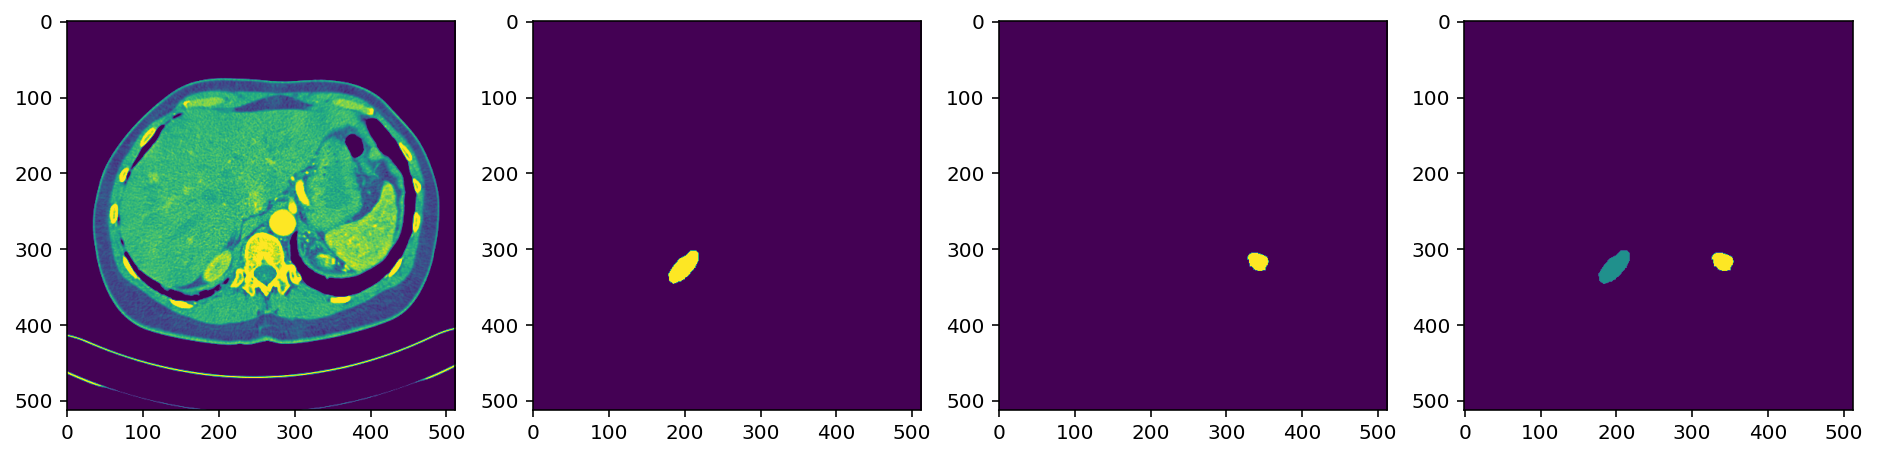

In [ ]:
##input과 label이 맞나 확인
images,labels,a = next(iter(train_loader))
# print(images.shape)
# print(labels.shape)
plt.figure(figsize=(16,18))
plt.subplot(1,4,1)
plt.imshow(images[0][0])
plt.subplot(1,4,2)
plt.imshow(labels[0][0])
plt.subplot(1,4,3)
plt.imshow(labels[0][1])
plt.subplot(1,4,4)
plt.imshow(a[0])
plt.show()

In [ ]:
def compute_per_channel_dice(input, target, epsilon=1e-5,ignore_index=None, weight=None):
    # assumes that input is a normalized probability
    # input and target shapes must match
    assert input.size() == target.size(), "'input' and 'target' must have the same shape"

    # mask ignore_index if present
    if ignore_index is not None:
        mask = target.clone().ne_(ignore_index)
        mask.requires_grad = False

        input = input * mask
        target = target * mask

    input = flatten(input)
    target = flatten(target)

    # Compute per channel Dice Coefficient
    intersect = (input * target).sum(-1)
    if weight is not None:
        intersect = weight * intersect

    denominator = (input + target).sum(-1)
    return 2. * intersect / denominator.clamp(min=epsilon)

def flatten(tensor):
    """Flattens a given tensor such that the channel axis is first.
    The shapes are transformed as follows:
       (N, C, D, H, W) -> (C, N * D * H * W)
    """
    C = tensor.size(1)
    # new axis order
    axis_order = (1, 0) + tuple(range(2, tensor.dim()))
    # Transpose: (N, C, D, H, W) -> (C, N, D, H, W)
    transposed = tensor.permute(axis_order).contiguous()
    # Flatten: (C, N, D, H, W) -> (C, N * D * H * W)
    return transposed.view(C, -1)

class DiceLoss(nn.Module):
    """Computes Dice Loss, which just 1 - DiceCoefficient described above.
    Additionally allows per-class weights to be provided.
    """

    def __init__(self, epsilon=1e-5, weight=None, ignore_index=None, sigmoid_normalization=True,
                 skip_last_target=False):
        super(DiceLoss, self).__init__()
        if isinstance(weight, list):
            weight = torch.Tensor(weight)
            
        self.epsilon = epsilon
        self.register_buffer('weight', weight)
        self.ignore_index = ignore_index

        if sigmoid_normalization:
            self.normalization = nn.Sigmoid()
        else:
            self.normalization = nn.Softmax(dim=1)
        # if True skip the last channel in the target
        self.skip_last_target = skip_last_target

    def forward(self, input, target):
        # get probabilities from logits

        input = self.normalization(input)
        if self.weight is not None:
            weight = Variable(self.weight, requires_grad=False).to(input.device)
        else:
            weight = None

        if self.skip_last_target:
            target = target[:, :-1, ...]

        per_channel_dice = compute_per_channel_dice(input, target, epsilon=self.epsilon, ignore_index=self.ignore_index, weight=weight)
        # Average the Dice score across all channels/classes
        return torch.mean(1. - per_channel_dice)

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True):
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size, stride=stride, padding=padding,
                                 bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]

            cbr = nn.Sequential(*layers)

            return cbr


        self.enc1_1 = CBR2d(in_channels=3, out_channels=64)
        self.enc1_2 = CBR2d(in_channels=64, out_channels=64)

        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.enc2_1 = CBR2d(in_channels=64, out_channels=128)
        self.enc2_2 = CBR2d(in_channels=128, out_channels=128)

        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.enc3_1 = CBR2d(in_channels=128, out_channels=256)
        self.enc3_2 = CBR2d(in_channels=256, out_channels=256)

        self.pool3 = nn.MaxPool2d(kernel_size=2)

        self.enc4_1 = CBR2d(in_channels=256, out_channels=512)
        self.enc4_2 = CBR2d(in_channels=512, out_channels=512)

        self.pool4 = nn.MaxPool2d(kernel_size=2)

        self.enc5_1 = CBR2d(in_channels=512, out_channels=1024)
        

        self.dec5_1 = CBR2d(in_channels=1024, out_channels=512)

        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec4_2 = CBR2d(in_channels=2 * 512, out_channels=512)
        self.dec4_1 = CBR2d(in_channels=512, out_channels=256)

        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec3_2 = CBR2d(in_channels=2 * 256, out_channels=256)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128)

        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec2_2 = CBR2d(in_channels=2 * 128, out_channels=128)
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64)

        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec1_2 = CBR2d(in_channels=2 * 64, out_channels=64)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)

        self.fc = nn.Conv2d(in_channels=64, out_channels=2, kernel_size=1, stride=1, padding=0, bias=True)

    def forward(self, x):
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)

        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)

        enc5_1 = self.enc5_1(pool4)
        dec5_1 = self.dec5_1(enc5_1)

        unpool4 = self.unpool4(dec5_1)
        cat4 = torch.cat((unpool4, enc4_2), dim=1)
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)

        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_2), dim=1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)

        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2, enc2_2), dim=1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)

        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((unpool1, enc1_2), dim=1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)

        x = self.fc(dec1_1)
        return x

In [ ]:

from sklearn.metrics import confusion_matrix  
 #mport numpy as np

def compute_iou(y_pred, y_true):
    y_pred=y_pred.detach().cpu()
    y_true=y_true.detach().cpu()
    # ytrue, ypred is a flatten vector
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()
    current = confusion_matrix(y_true, y_pred, labels=[0, 1])
    # compute mean iou
    intersection = np.diag(current)
    ground_truth_set = current.sum(axis=1)
    predicted_set = current.sum(axis=0)
    union = ground_truth_set + predicted_set - intersection
    IoU = intersection / union.astype(np.float32)
    return np.mean(IoU)

In [ ]:
import torch.optim as optim
criterion =  DiceLoss(sigmoid_normalization=True)
model = UNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=6)
model.load_state_dict(torch.load('model_unet_light.pt'))

<All keys matched successfully>

In [ ]:
sum([param.nelement() for param in model.parameters()])

23381186

  0%|          | 0/2240 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


nan


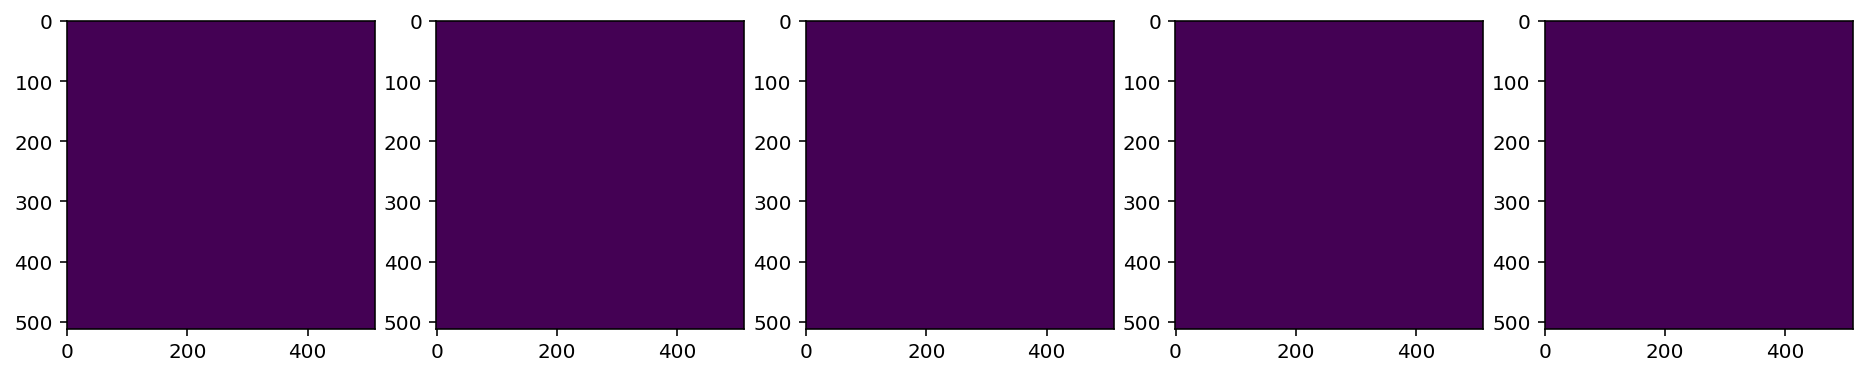

0.4999990463256836


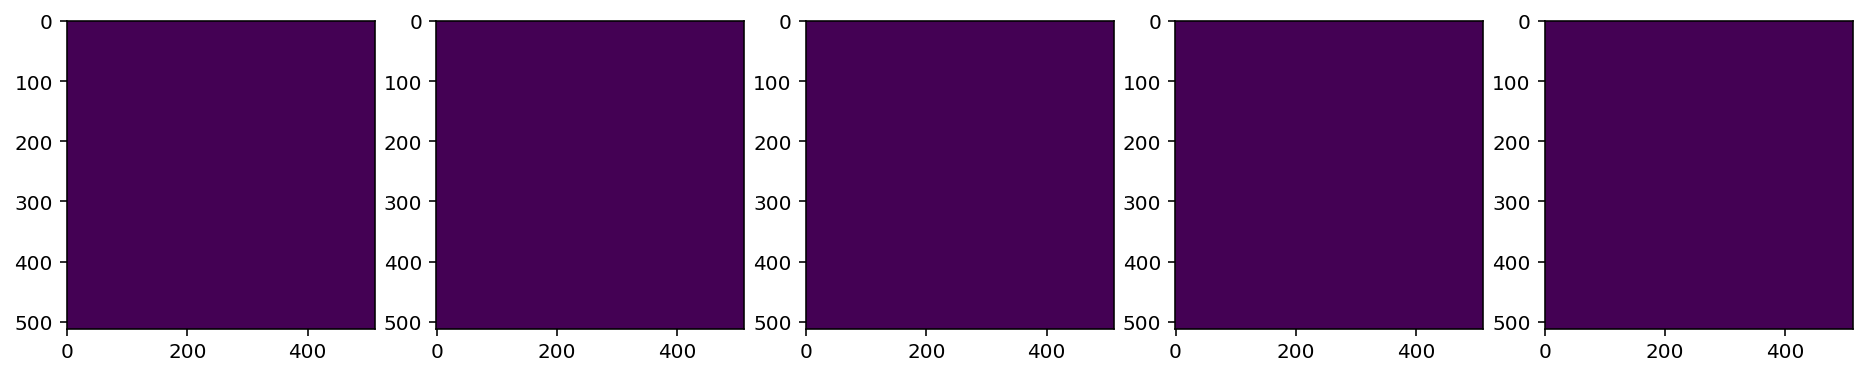

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 0 	Training Loss: 0.406970 	Validation Loss: 0.503379


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9914730484708281


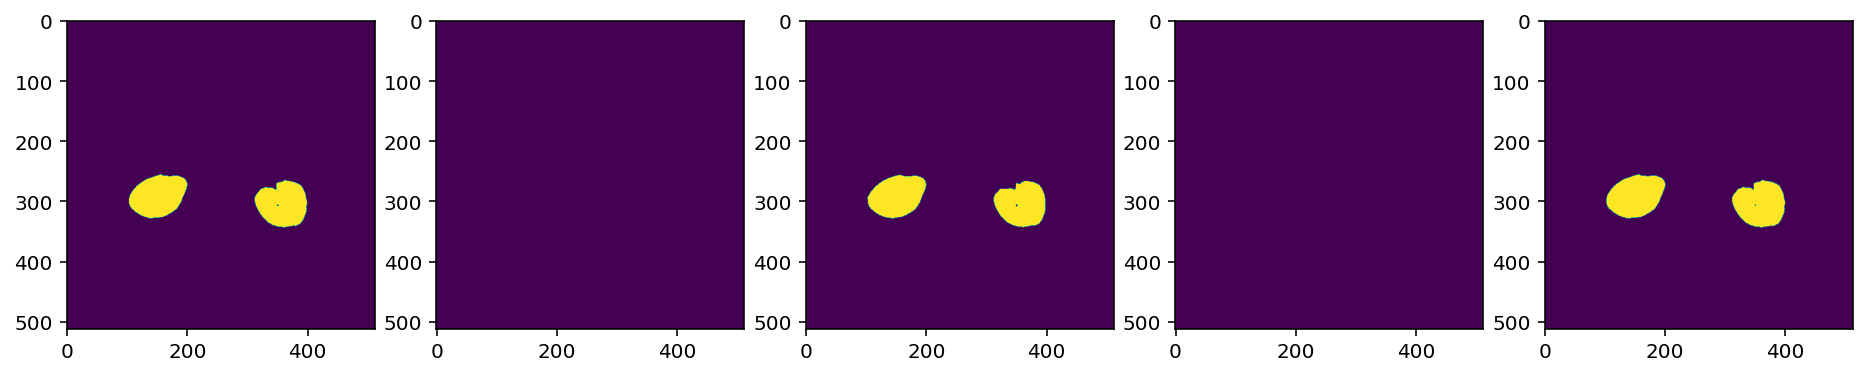

0.976137539827201


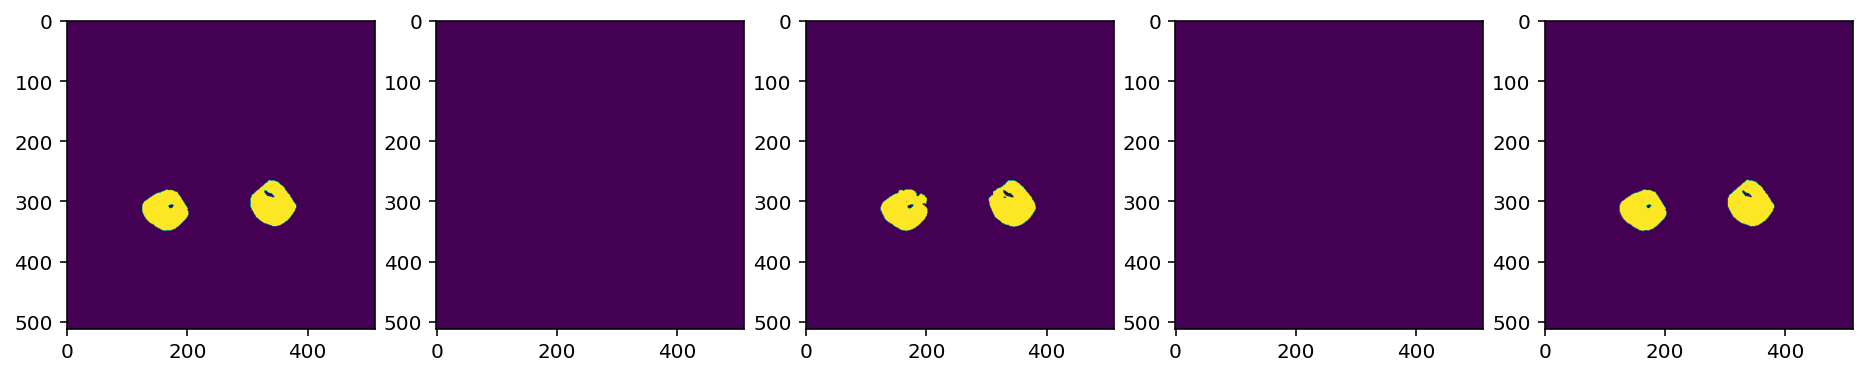

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 0.409823 	Validation Loss: 0.499781


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9485370757218596


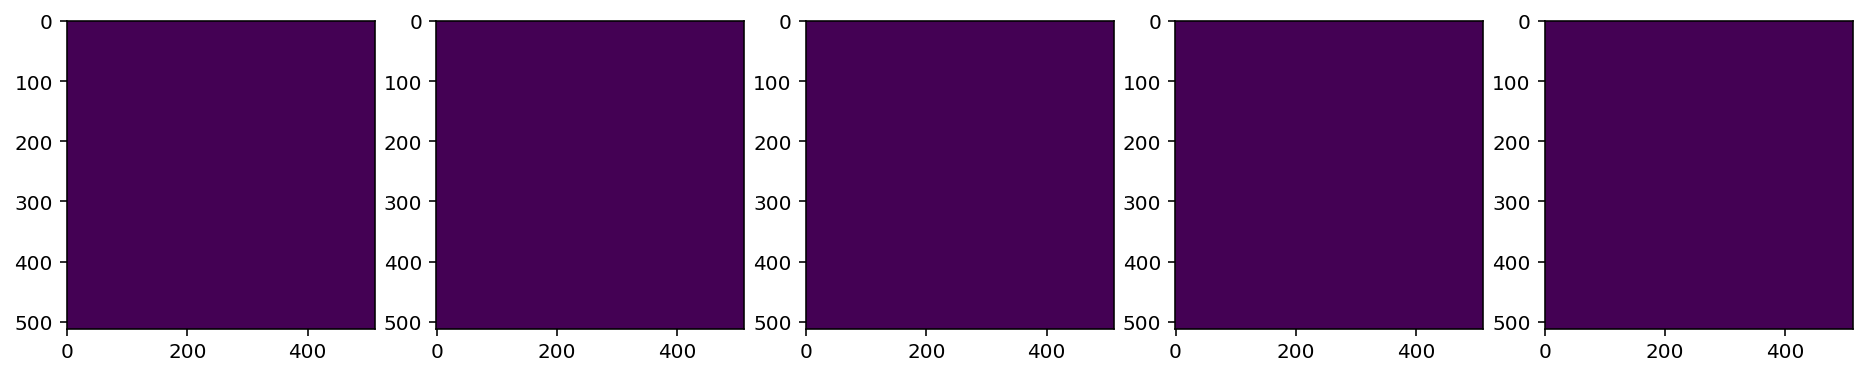

0.9542267574556964


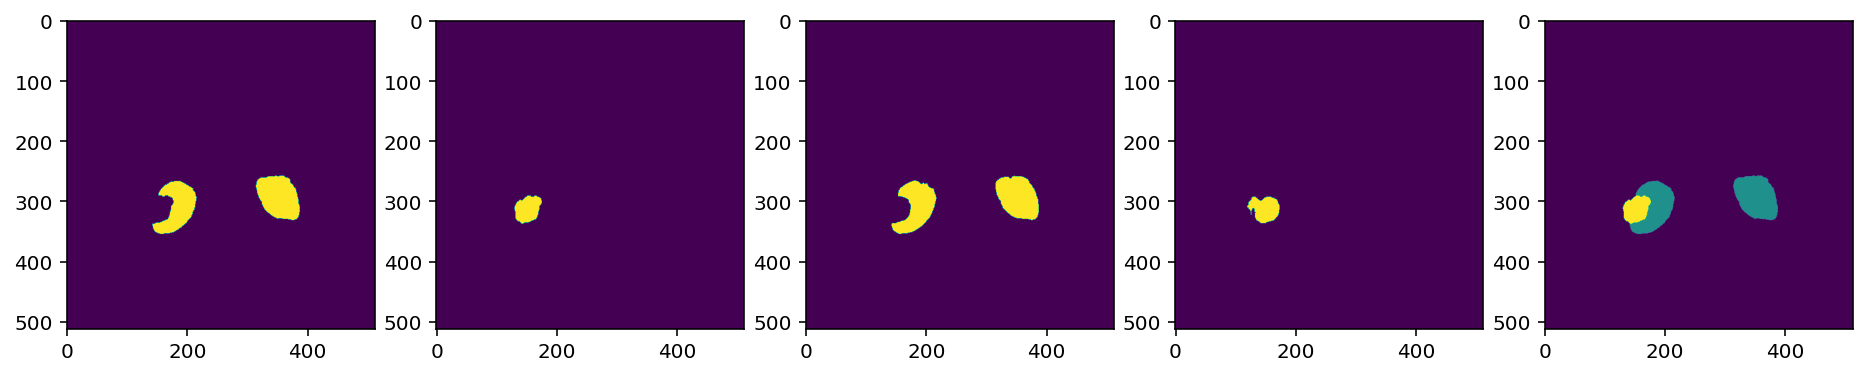

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 0.412364 	Validation Loss: 0.503732


  0%|          | 0/2240 [00:00<?, ?it/s]

0.8747746287528266


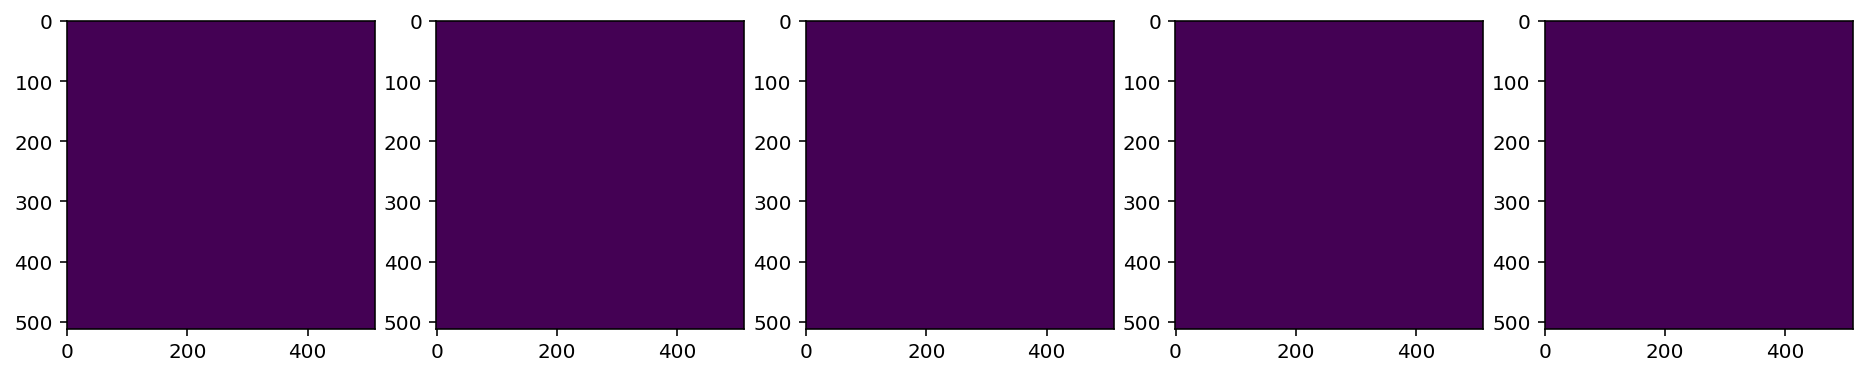

0.49987077713012695


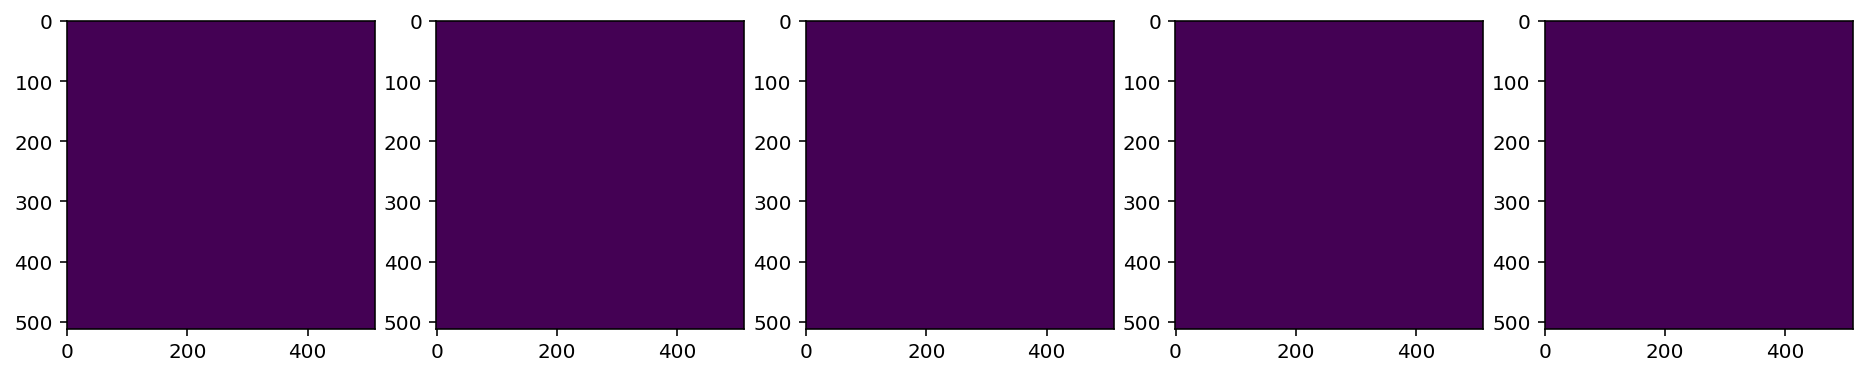

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 0.414284 	Validation Loss: 0.504917


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9508175284976517


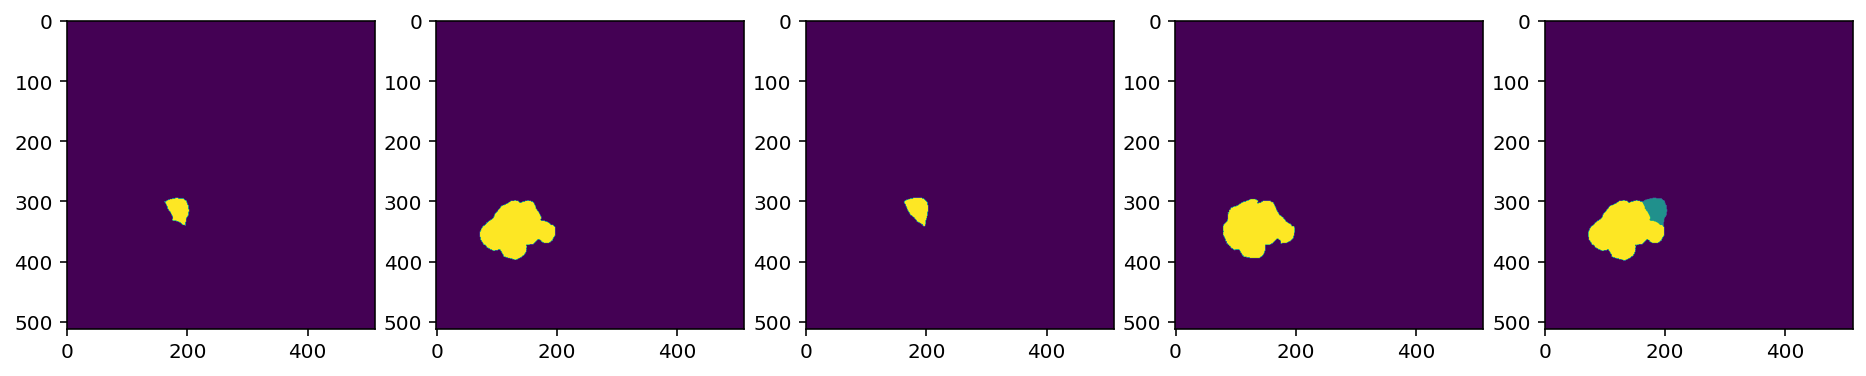

0.977594362797026


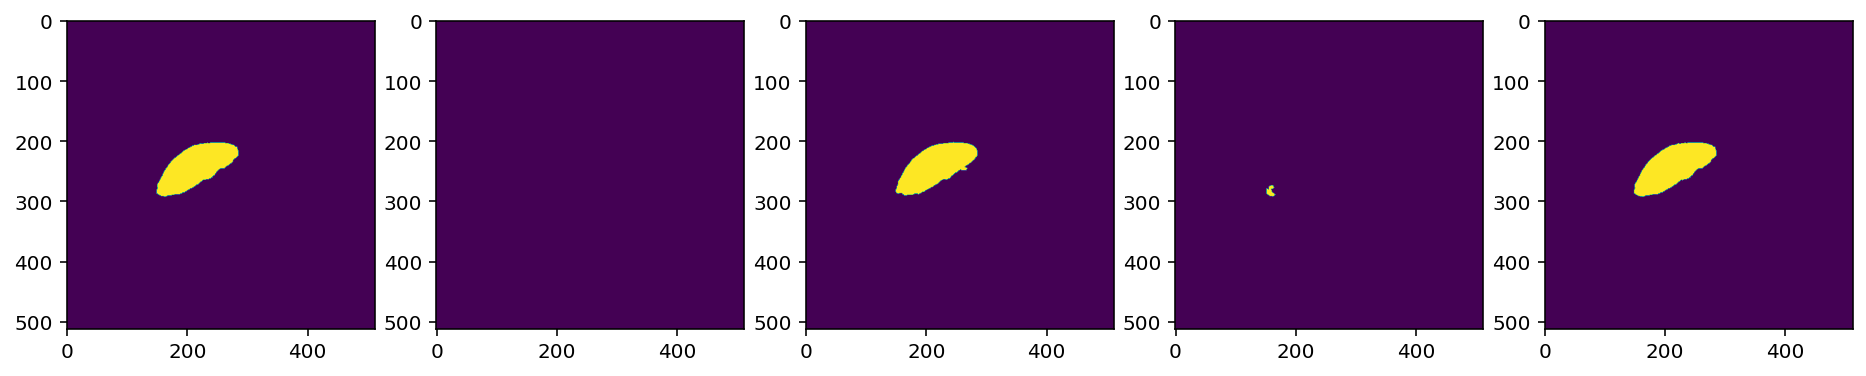

0.9216612545071909


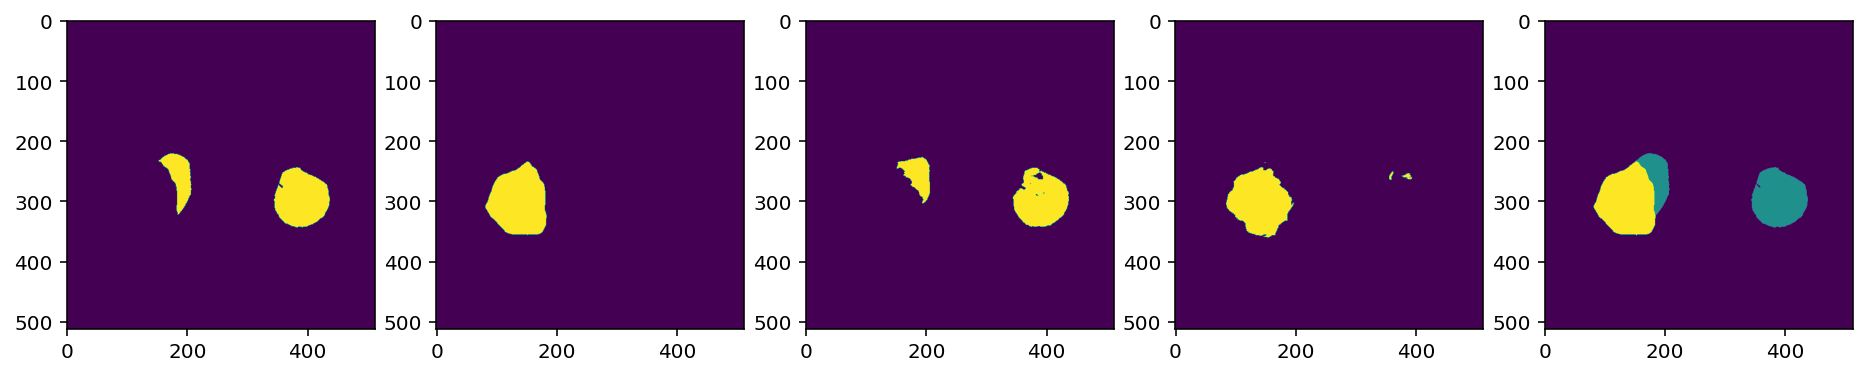

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 0.413621 	Validation Loss: 0.525140


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9791912658628426


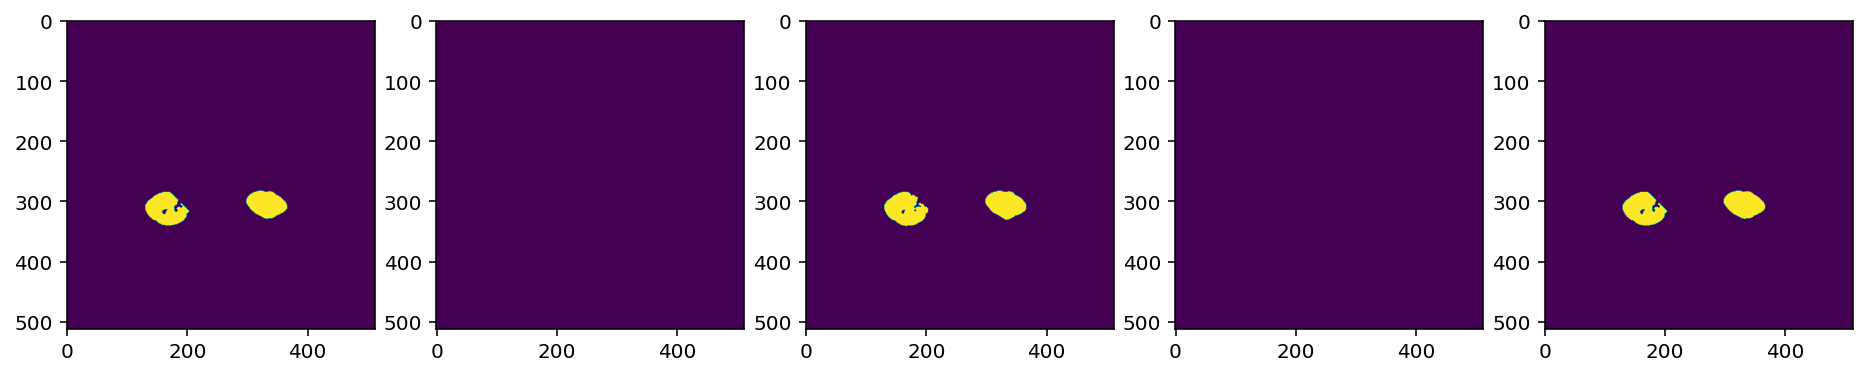

0.9856483277096242


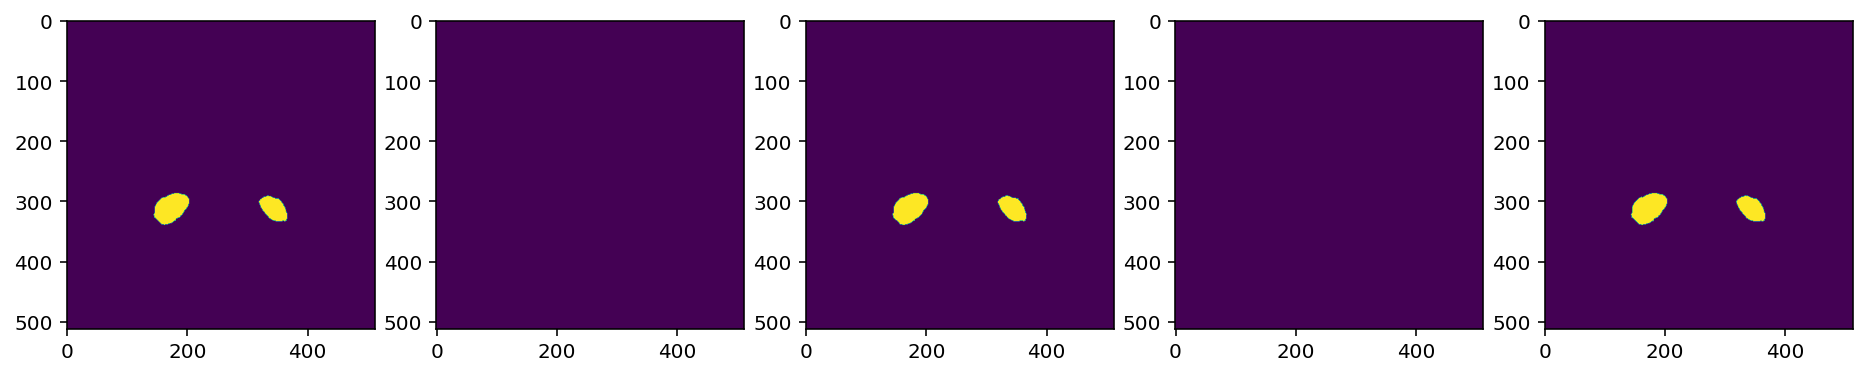

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 0.404528 	Validation Loss: 0.503396


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9367984915126312


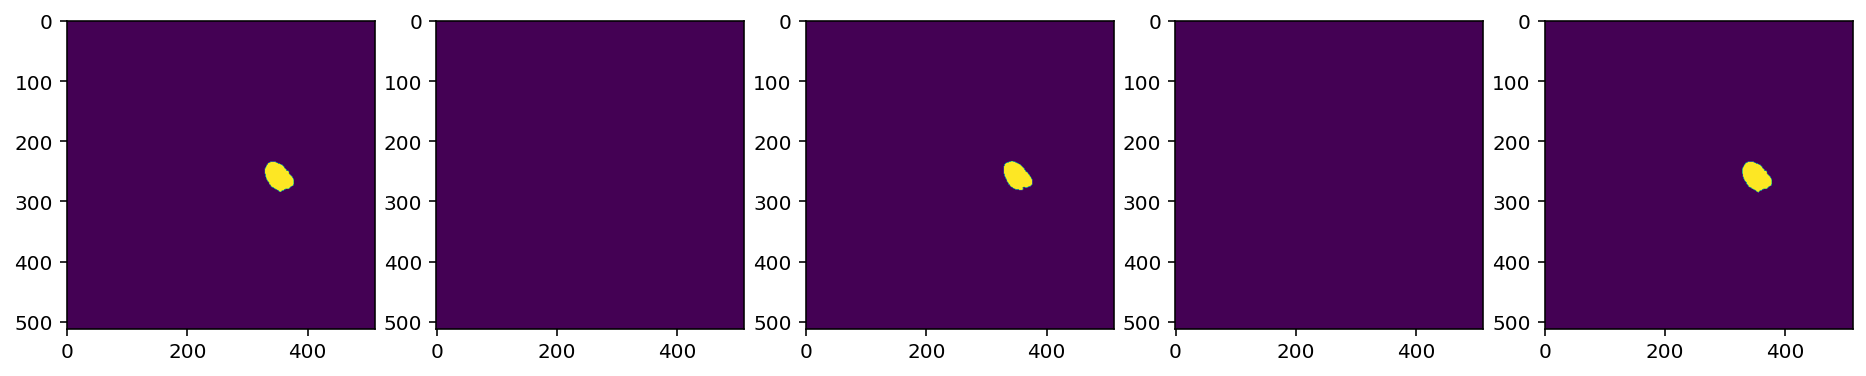

0.9803179829008093


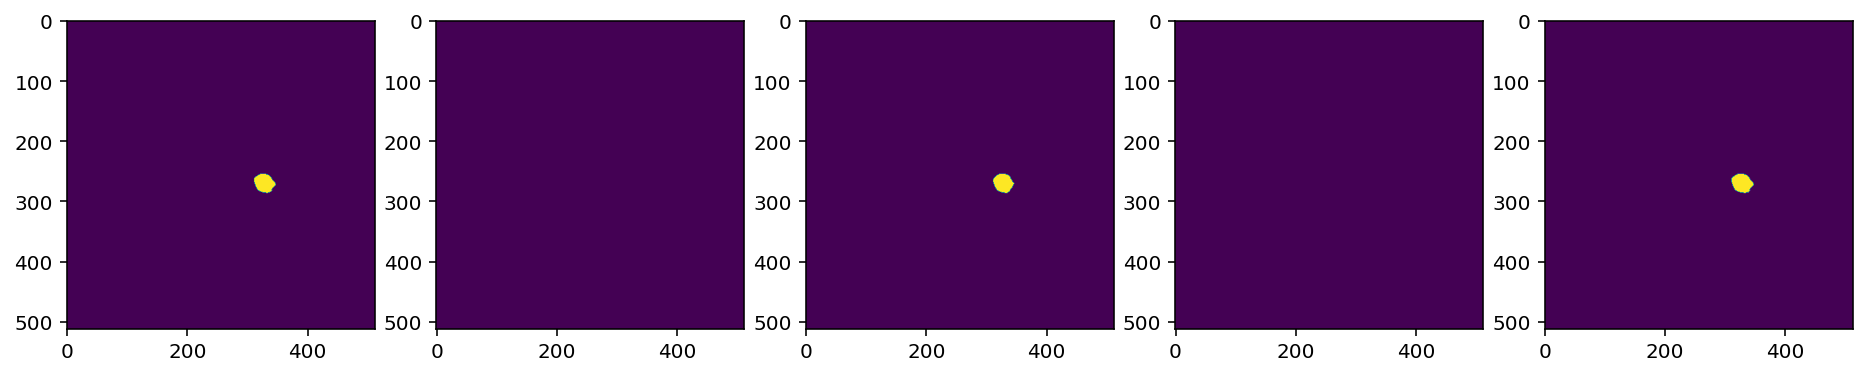

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 0.402300 	Validation Loss: 0.519065


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9340578211675674


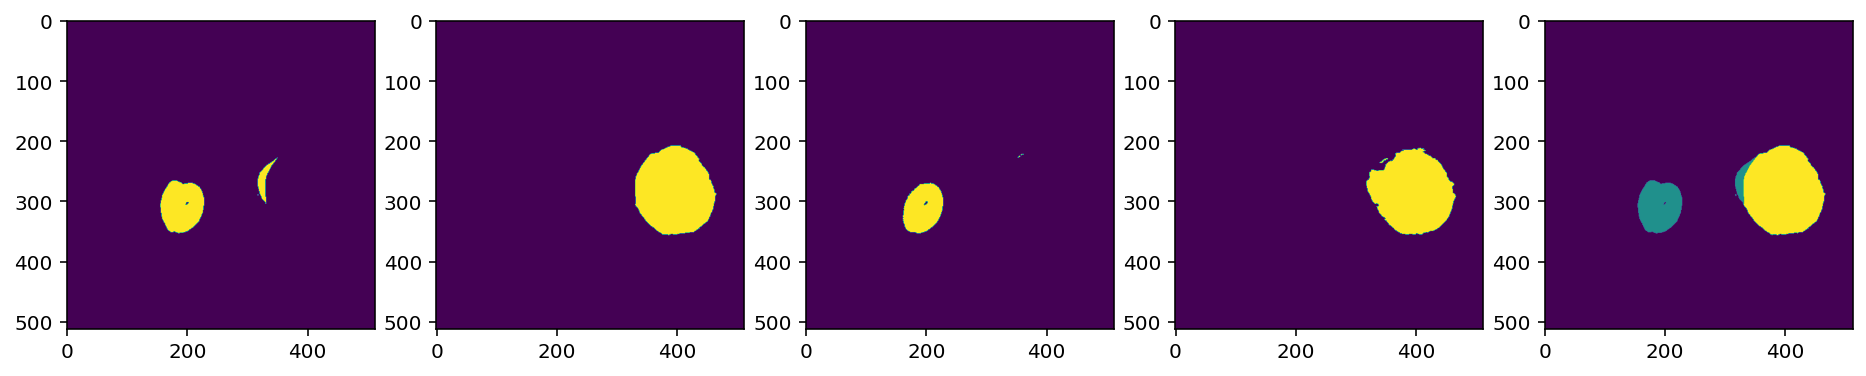

0.9547910416387992


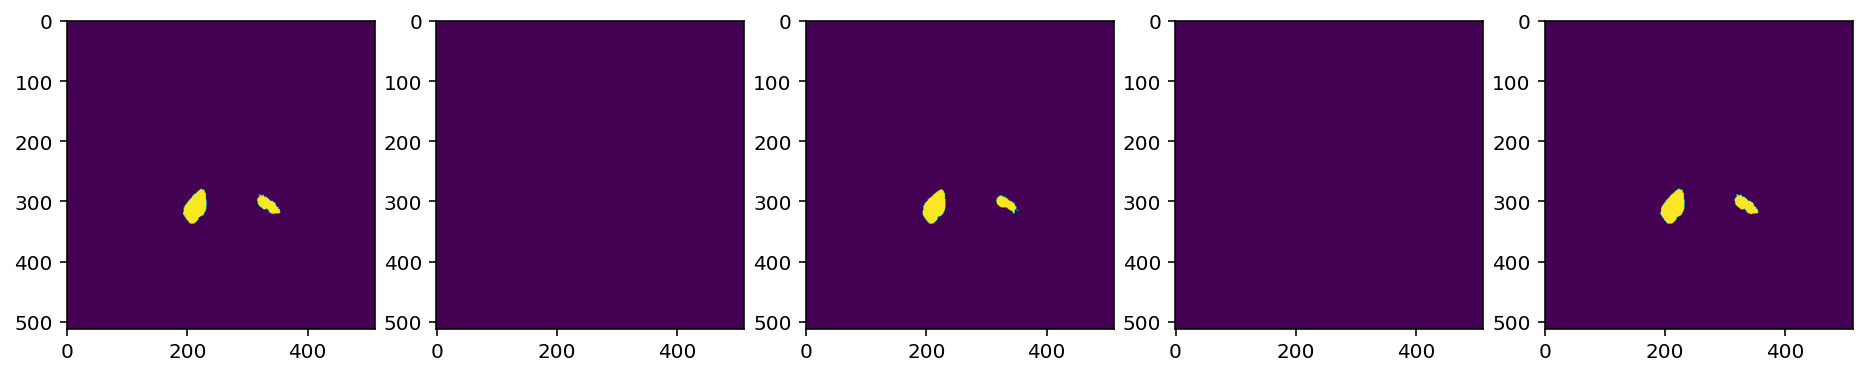

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 0.405451 	Validation Loss: 0.504094


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9831868254295478


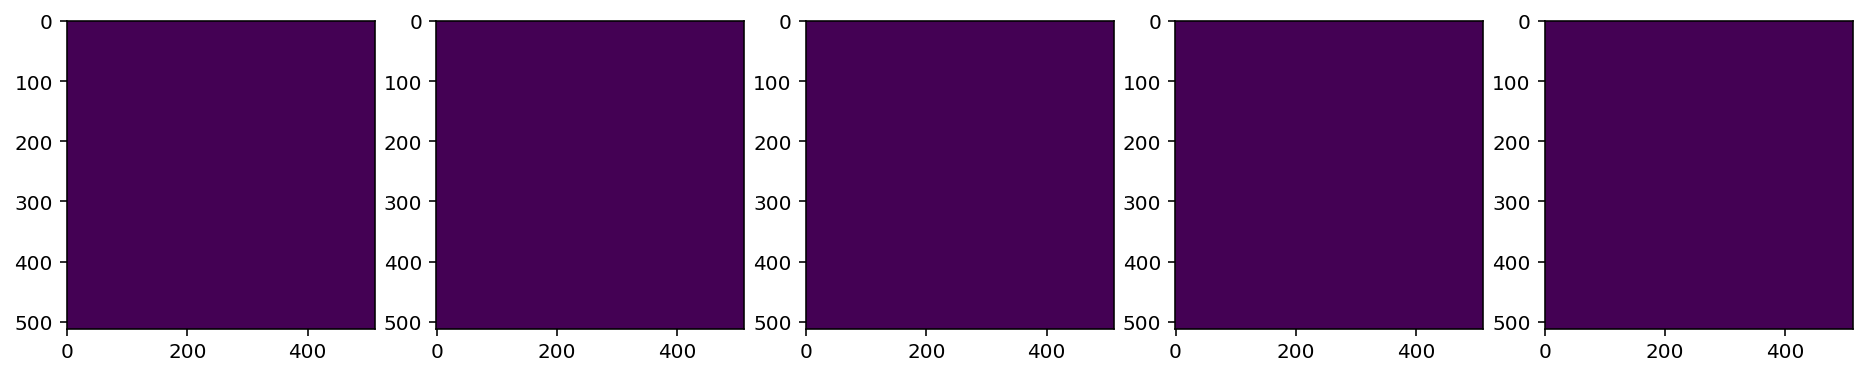

0.49999332427978516


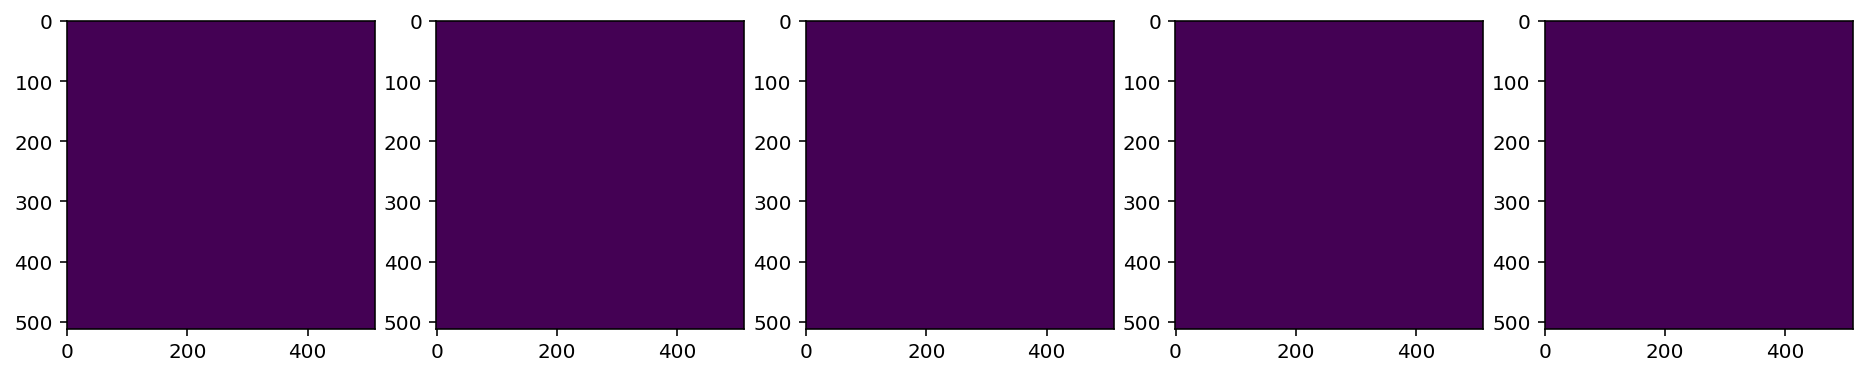

0.9918636350865213


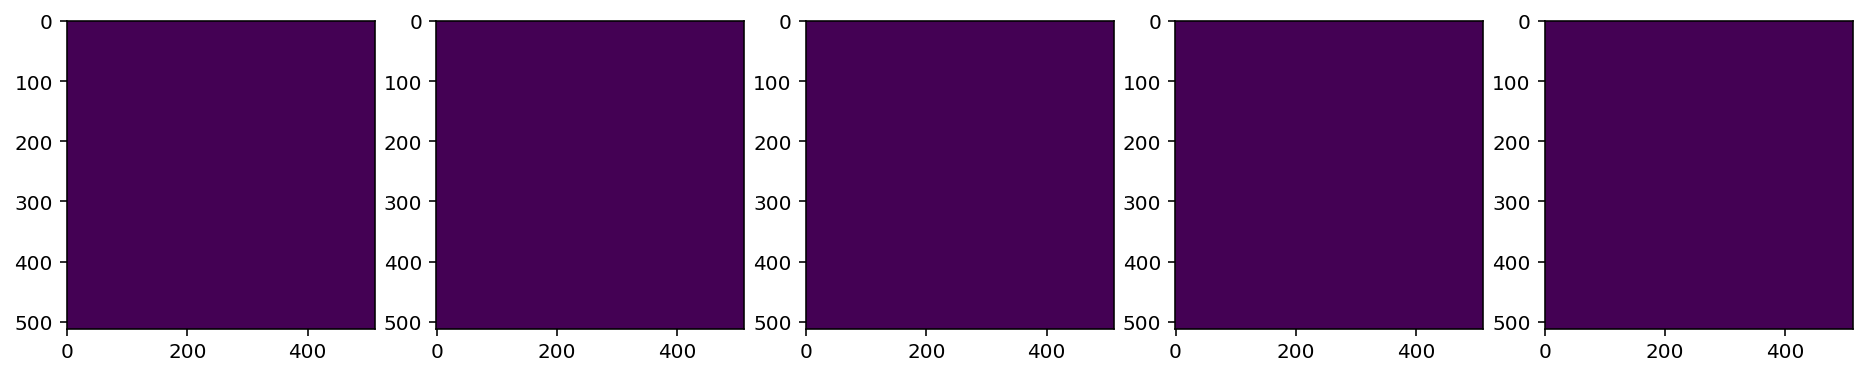

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 0.402781 	Validation Loss: 0.514844


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9867642604424278


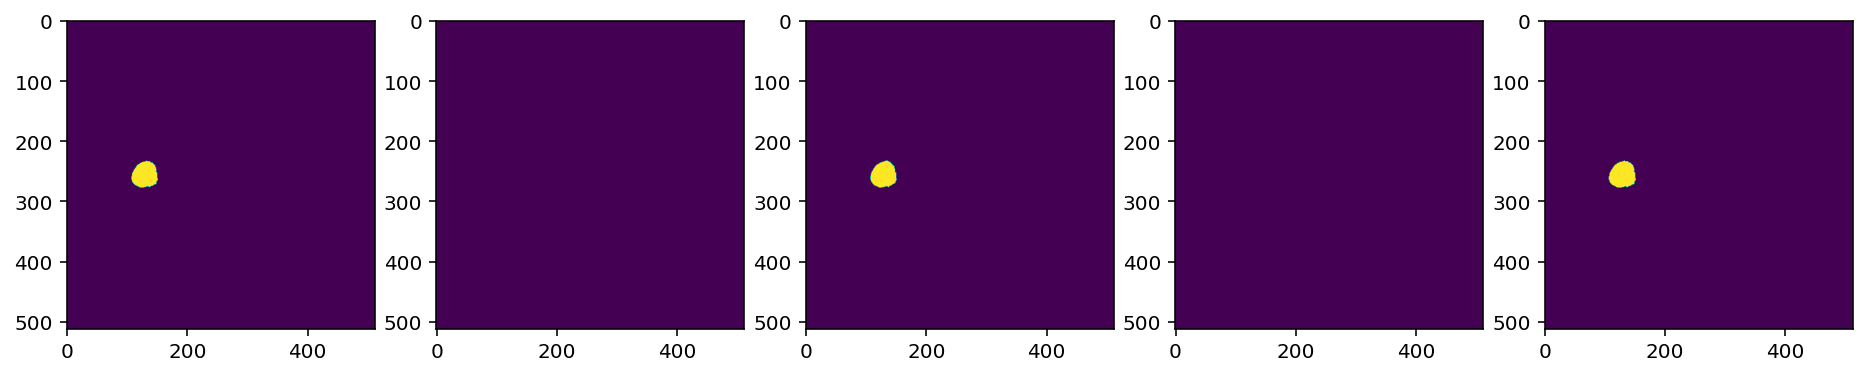

0.9868941914294531


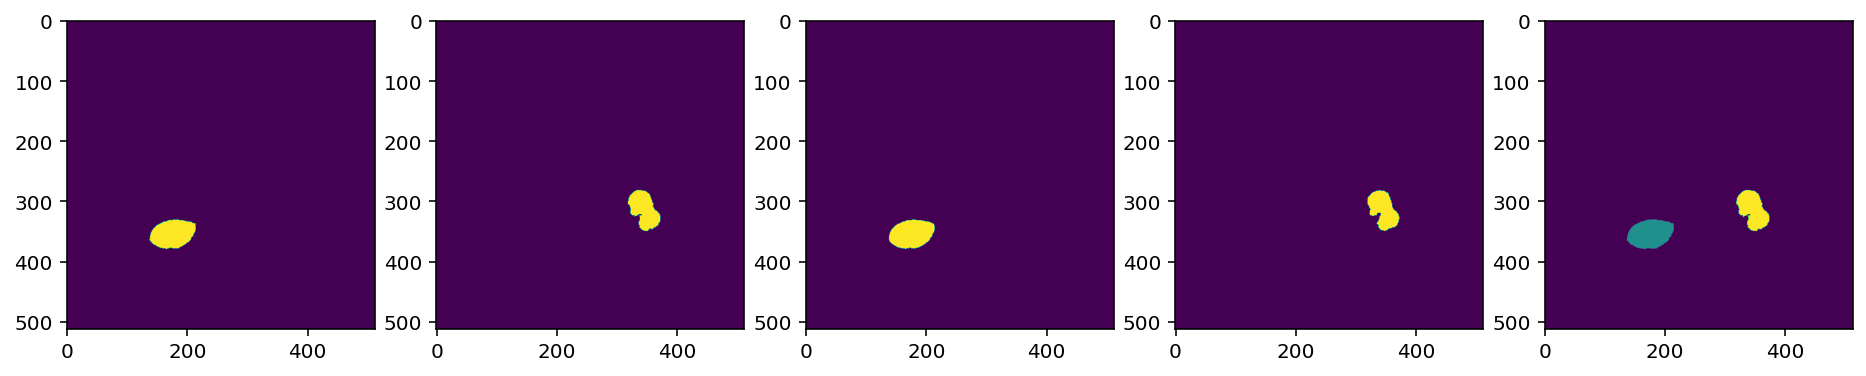

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 0.392553 	Validation Loss: 0.520442


  0%|          | 0/2240 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


nan


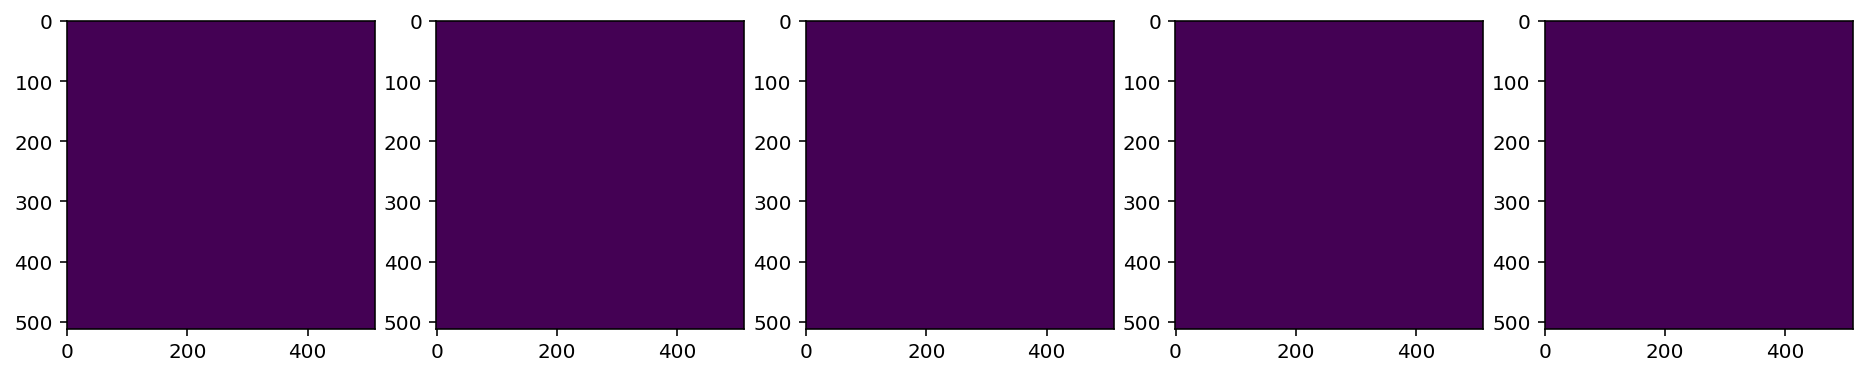

0.9808885712543713


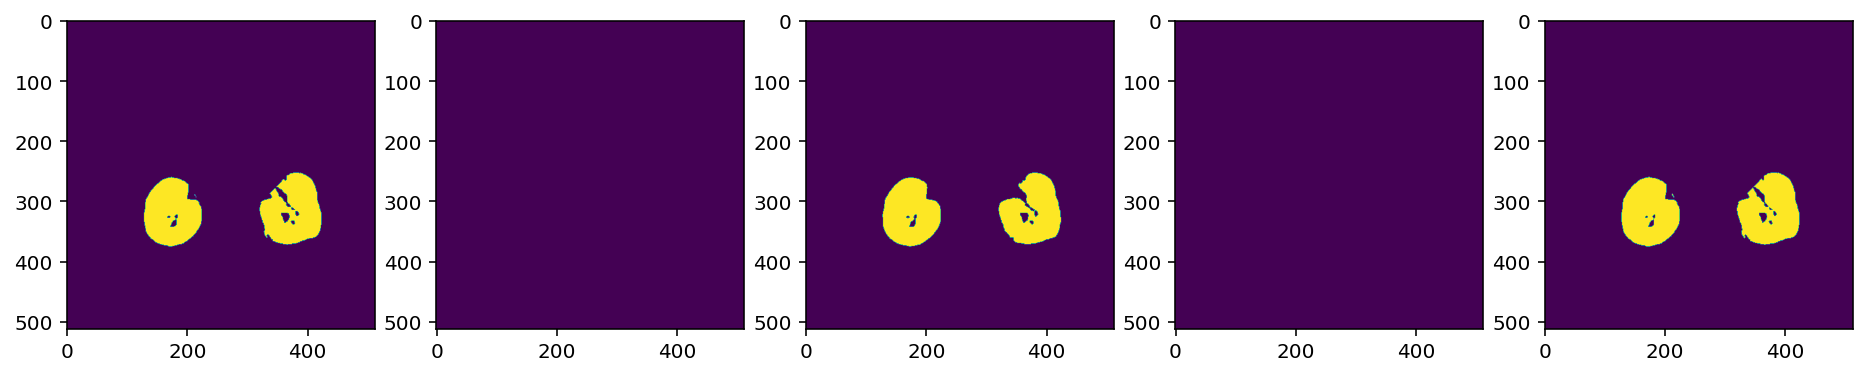

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 0.389747 	Validation Loss: 0.503253


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9529401026041983


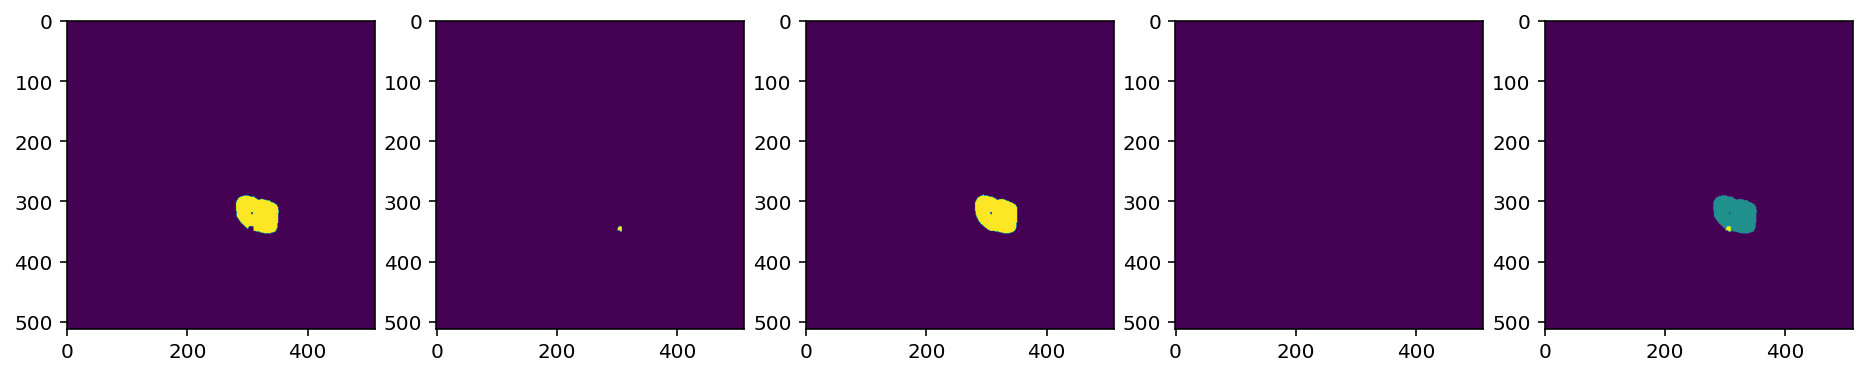

0.9882836524995751


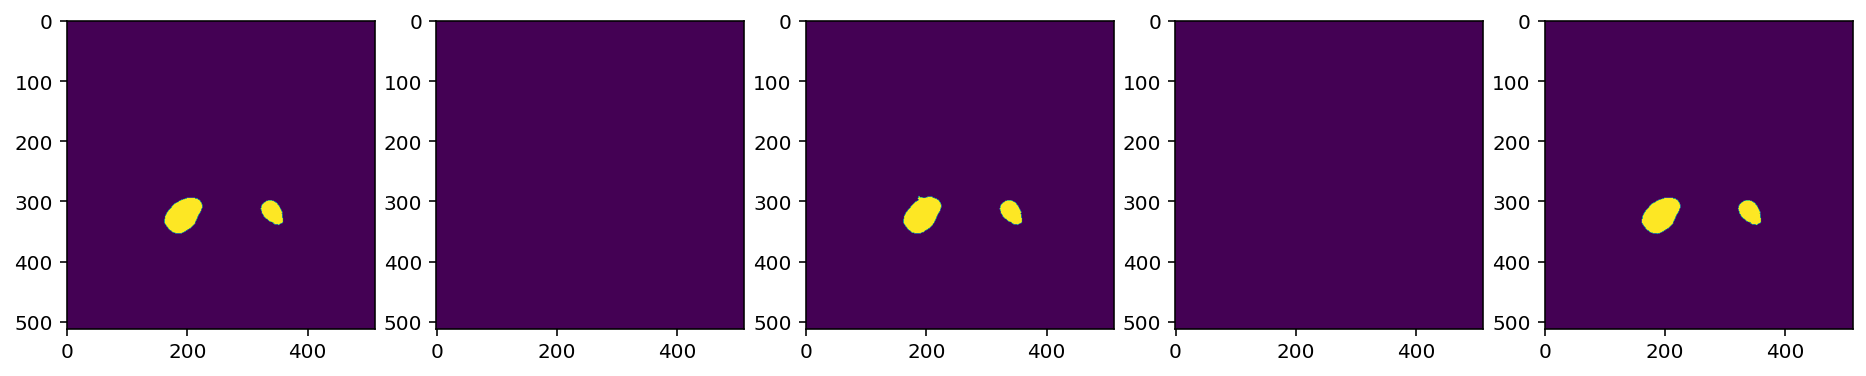

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 11 	Training Loss: 0.391662 	Validation Loss: 0.511297


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9378278119370509


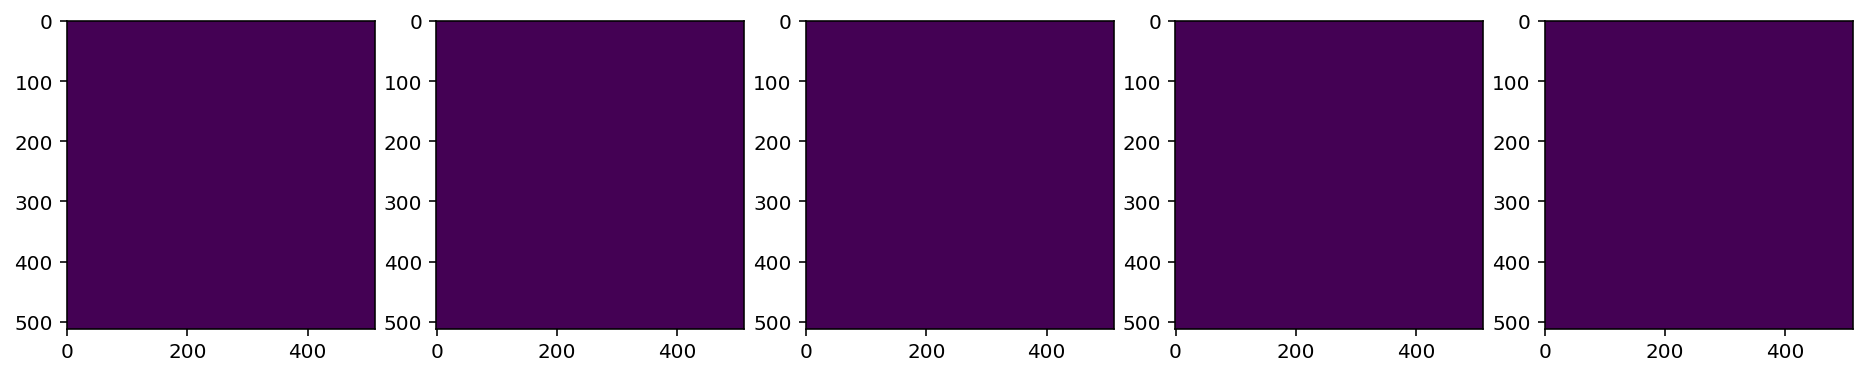

0.9701687071666962


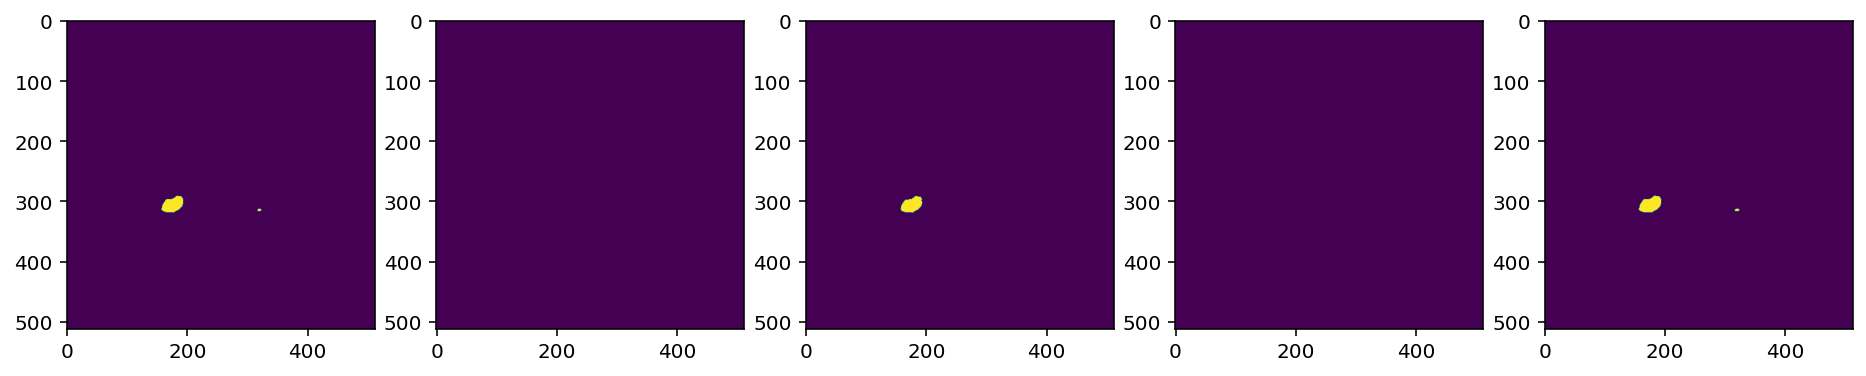

0.9835130033737506


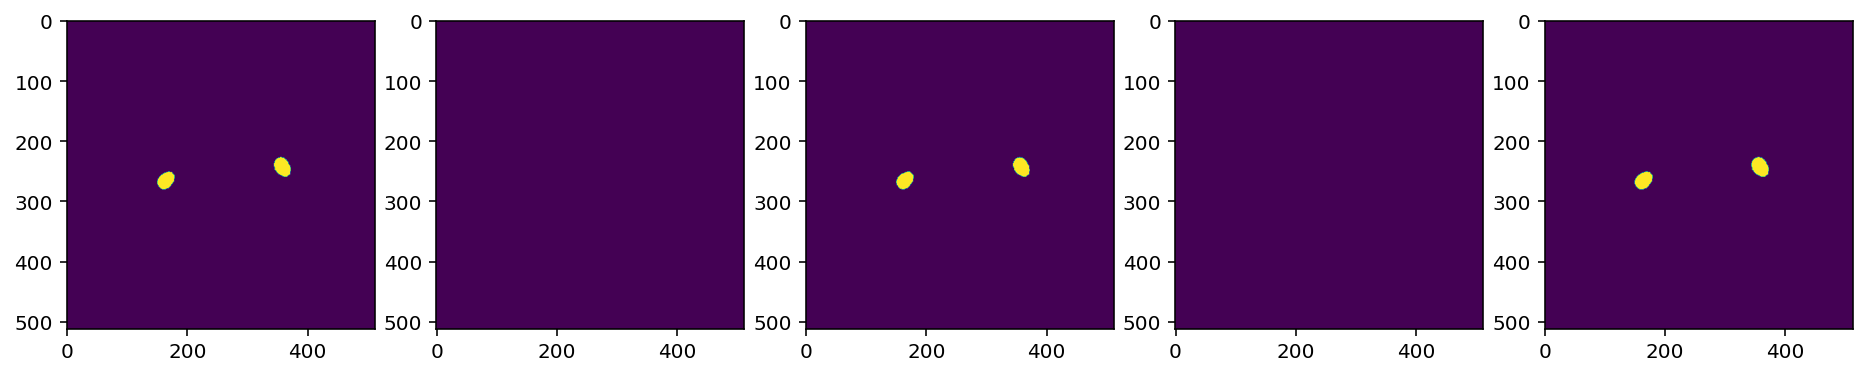

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 12 	Training Loss: 0.389903 	Validation Loss: 0.504959


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9710178272583694


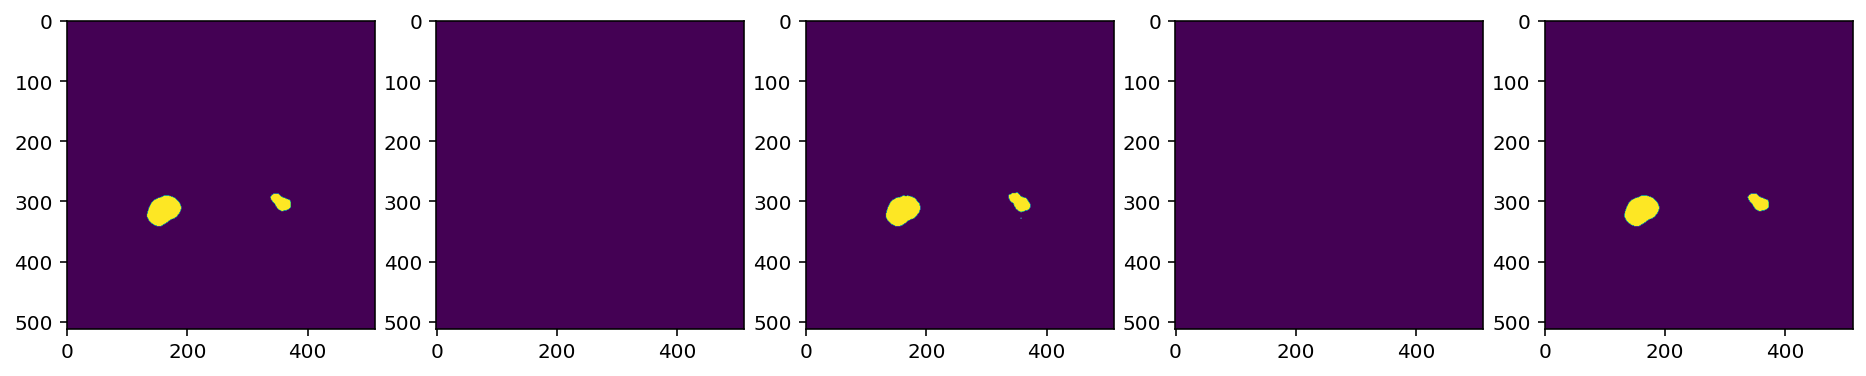

0.9897120250635277


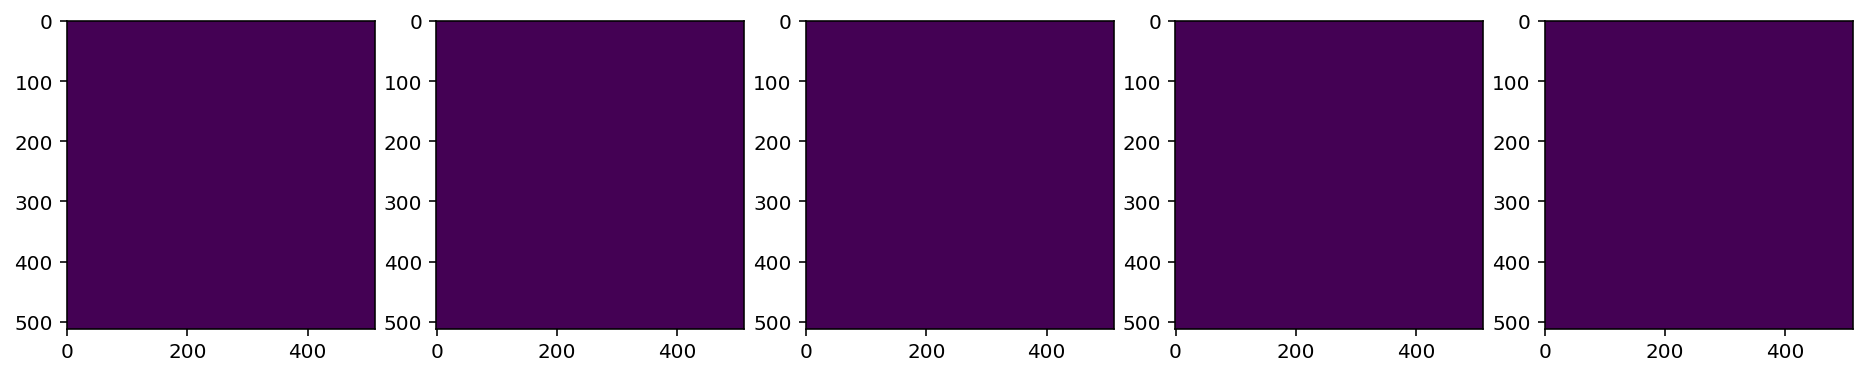

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 13 	Training Loss: 0.391739 	Validation Loss: 0.505931


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9869868380950119


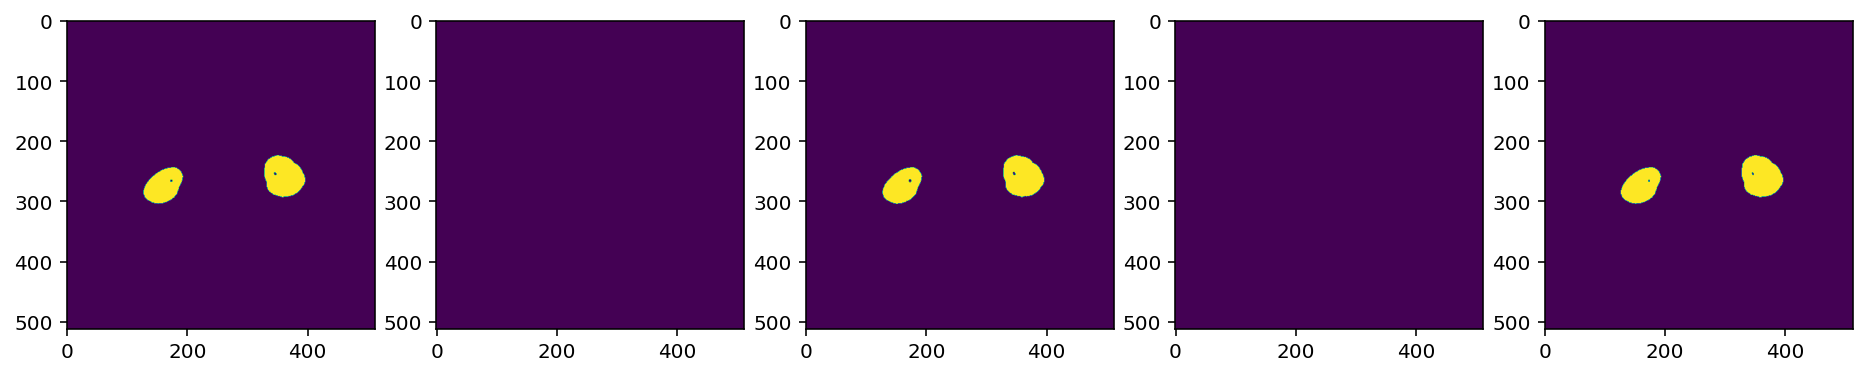

0.9937898452026106


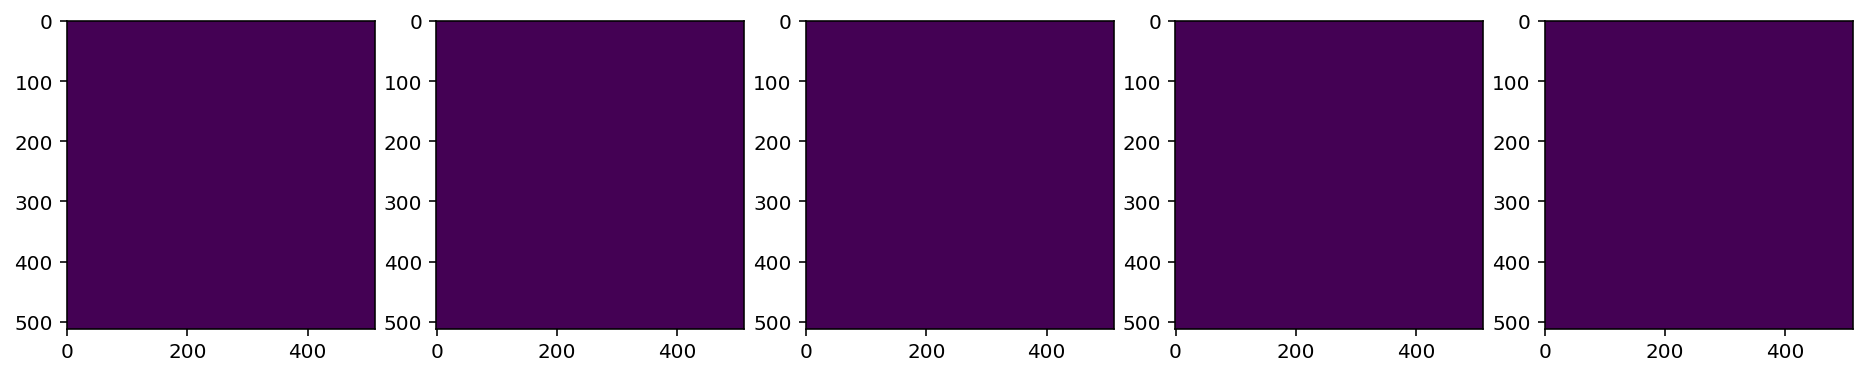

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 14 	Training Loss: 0.387298 	Validation Loss: 0.510846


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9297125754615057


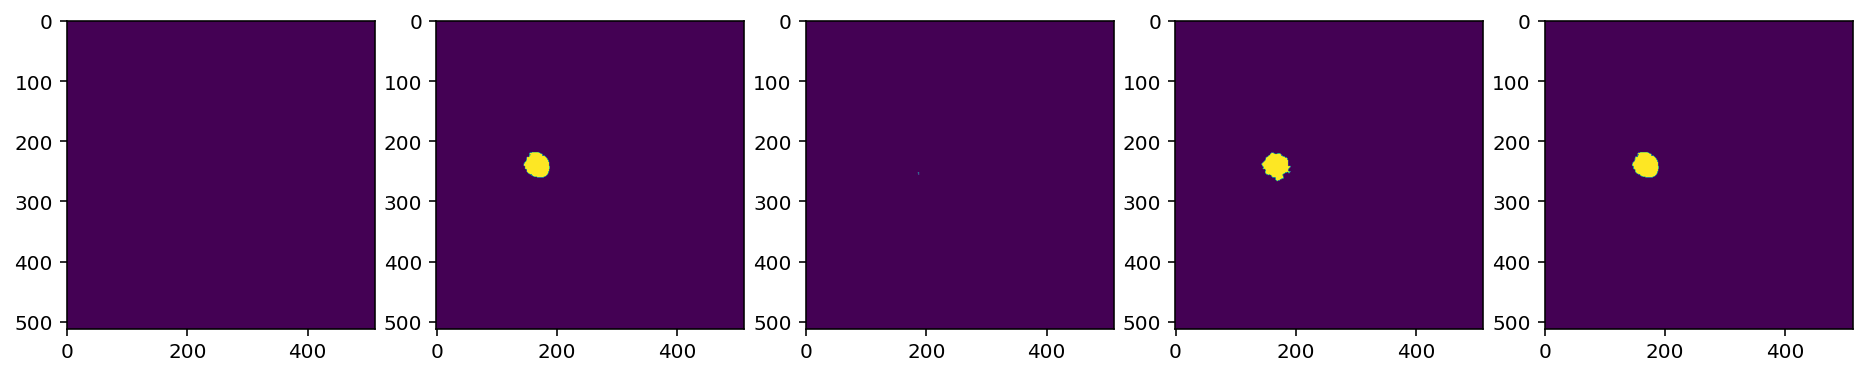

0.9706669116839501


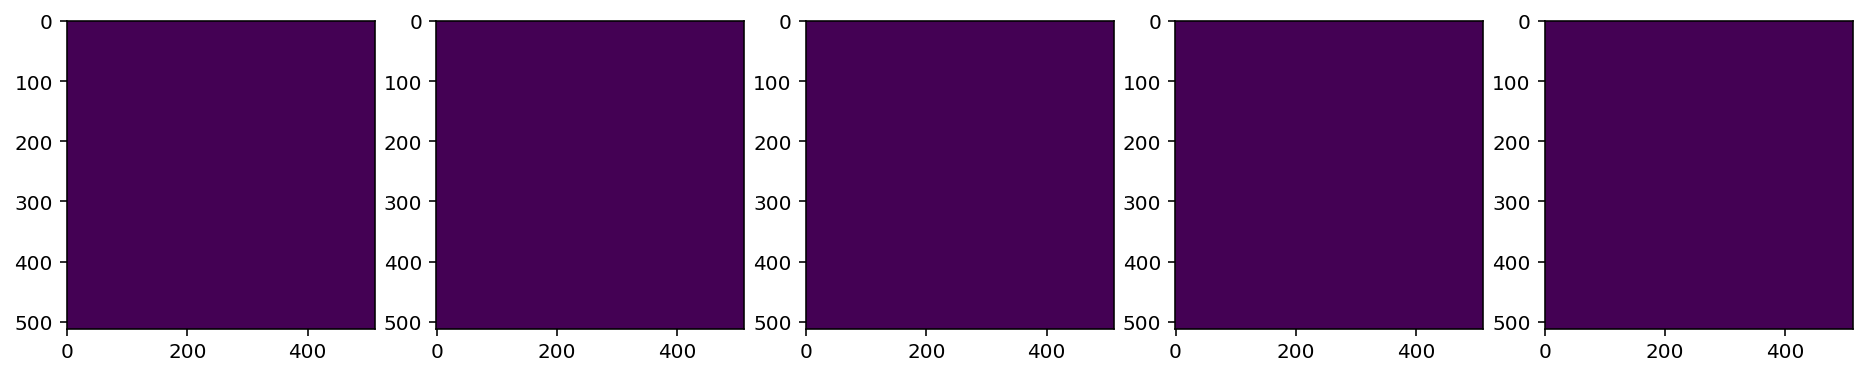

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 15 	Training Loss: 0.383122 	Validation Loss: 0.511802


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9381820268565161


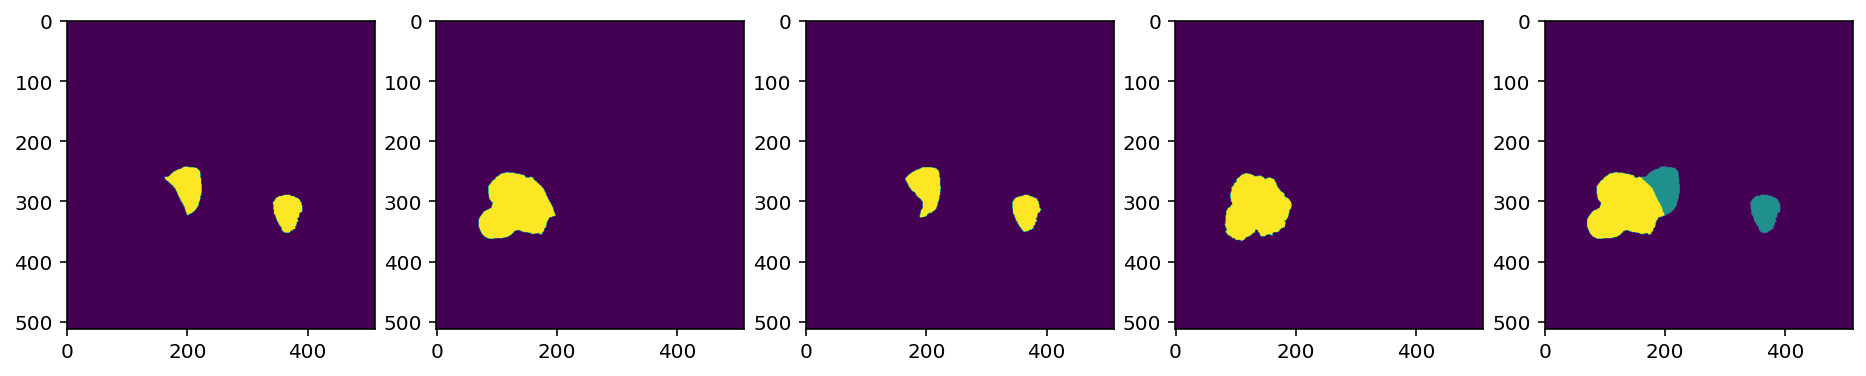

0.9849469666342222


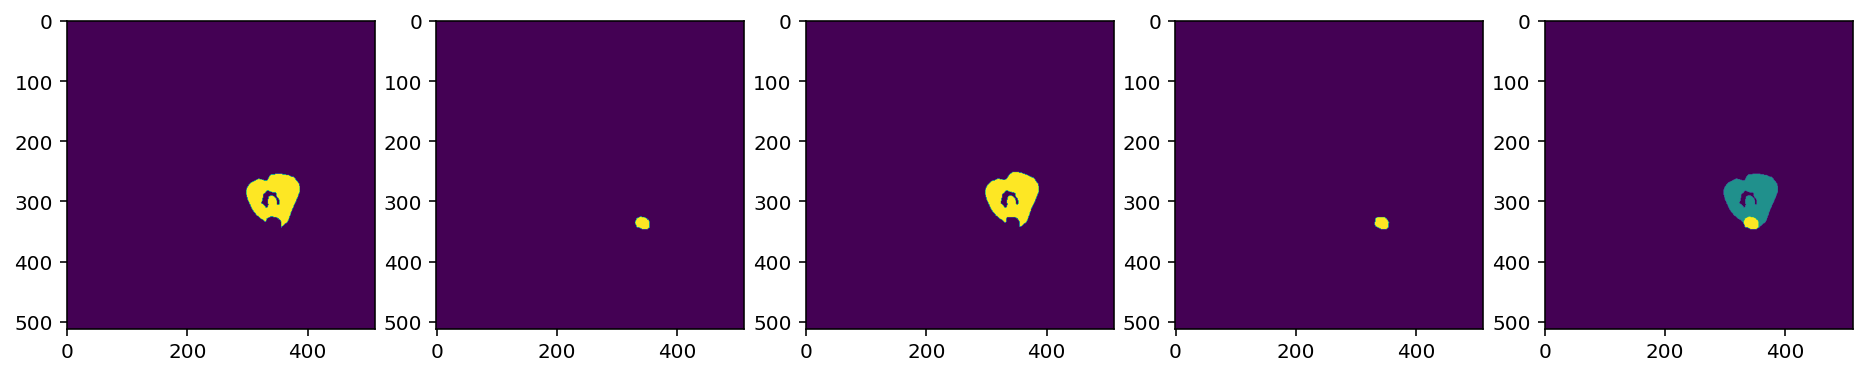

0.9380181875321738


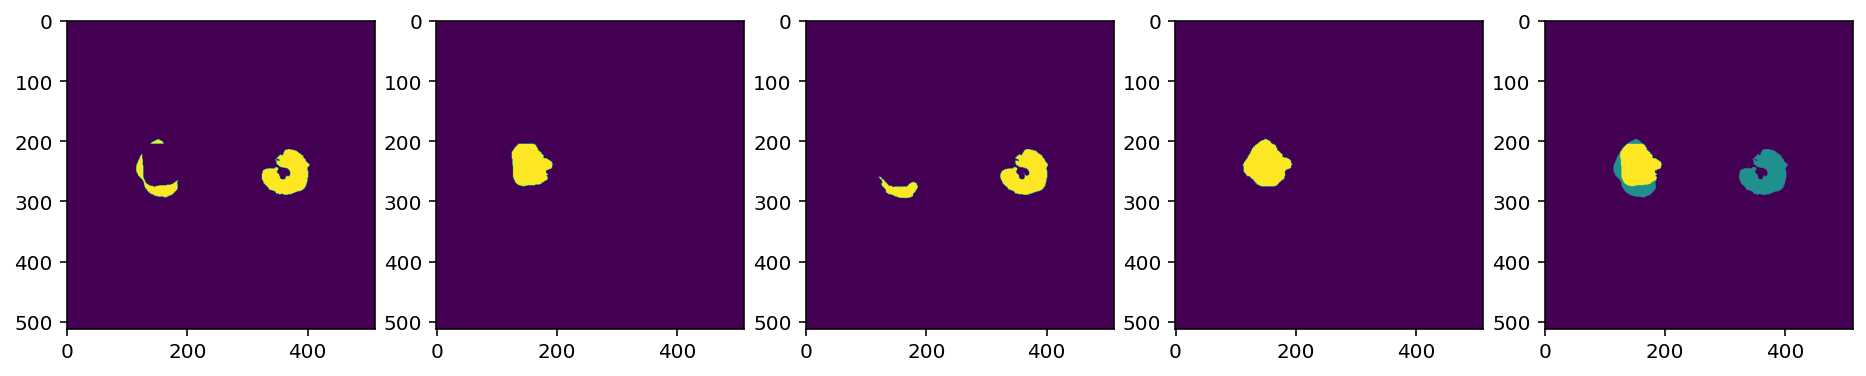

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 16 	Training Loss: 0.386868 	Validation Loss: 0.506383


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9813587991651194


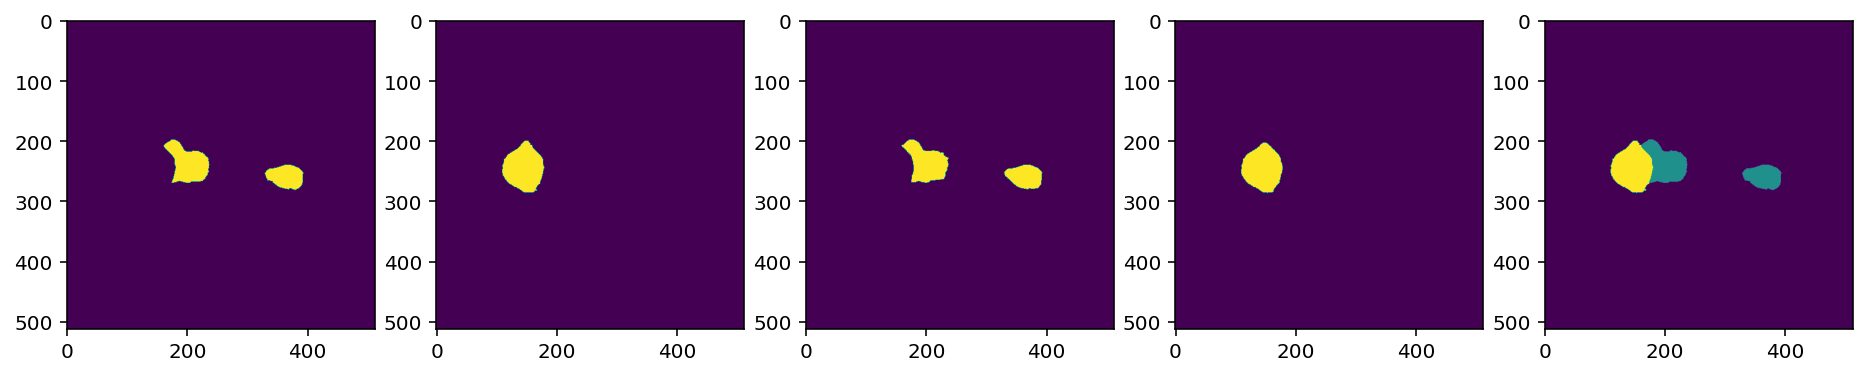

0.9719205239100686


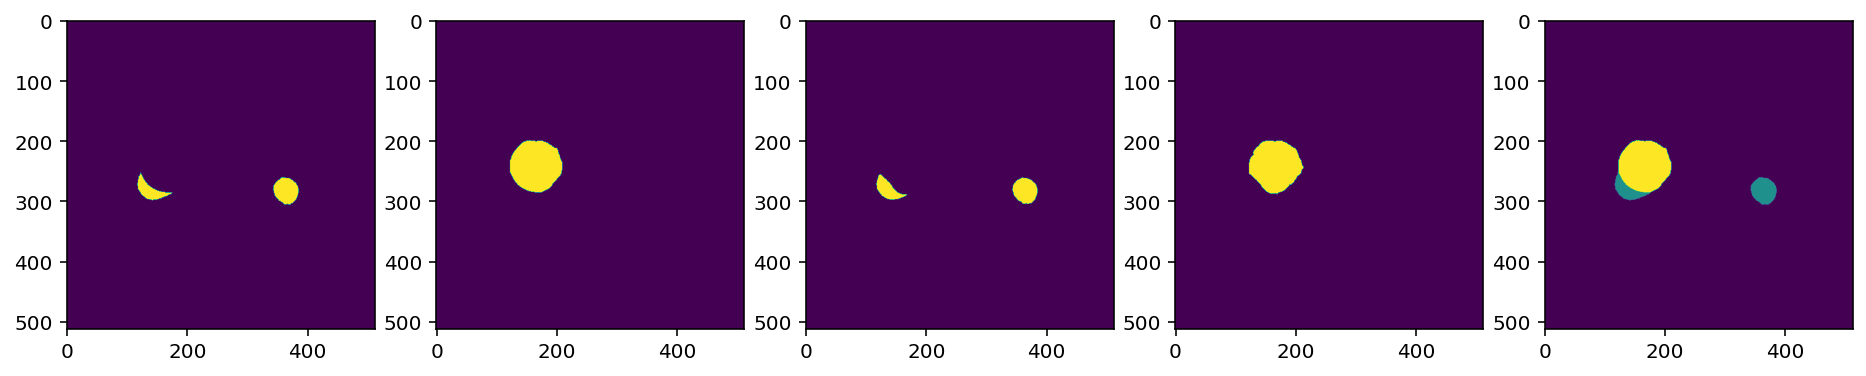

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 17 	Training Loss: 0.382465 	Validation Loss: 0.508718


  0%|          | 0/2240 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


nan


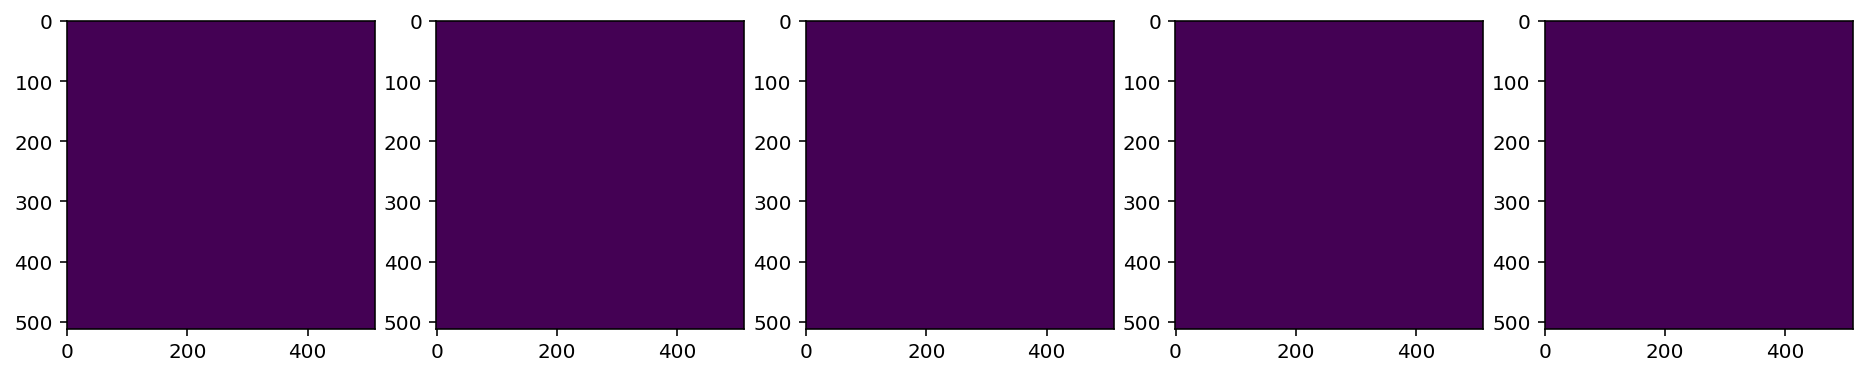

0.924712595216832


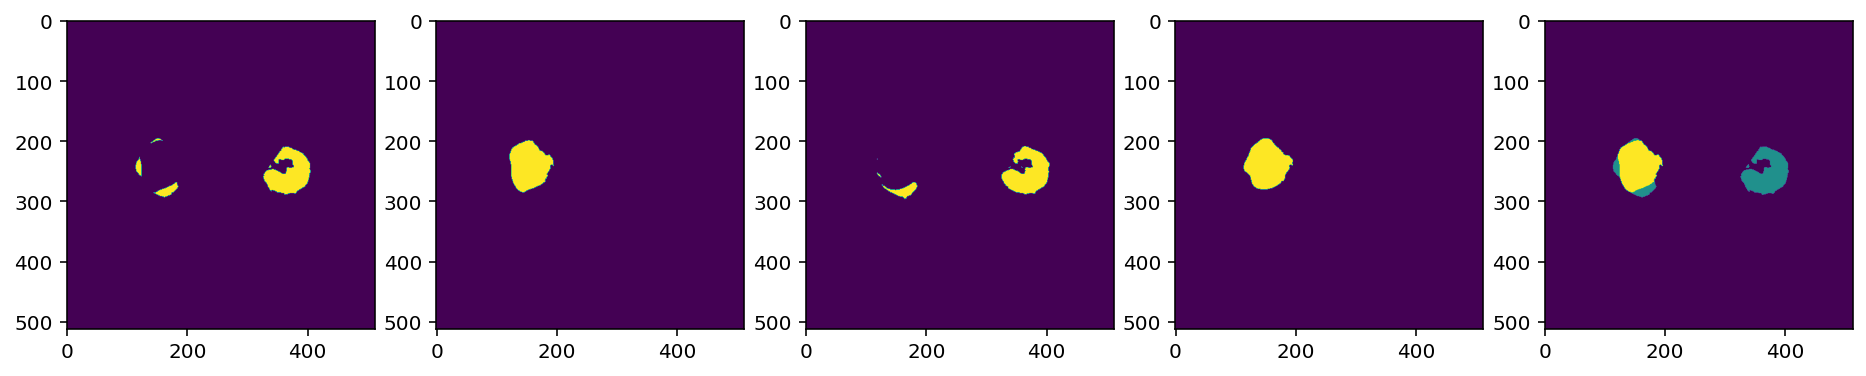

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 18 	Training Loss: 0.387114 	Validation Loss: 0.510424


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9761820882321641


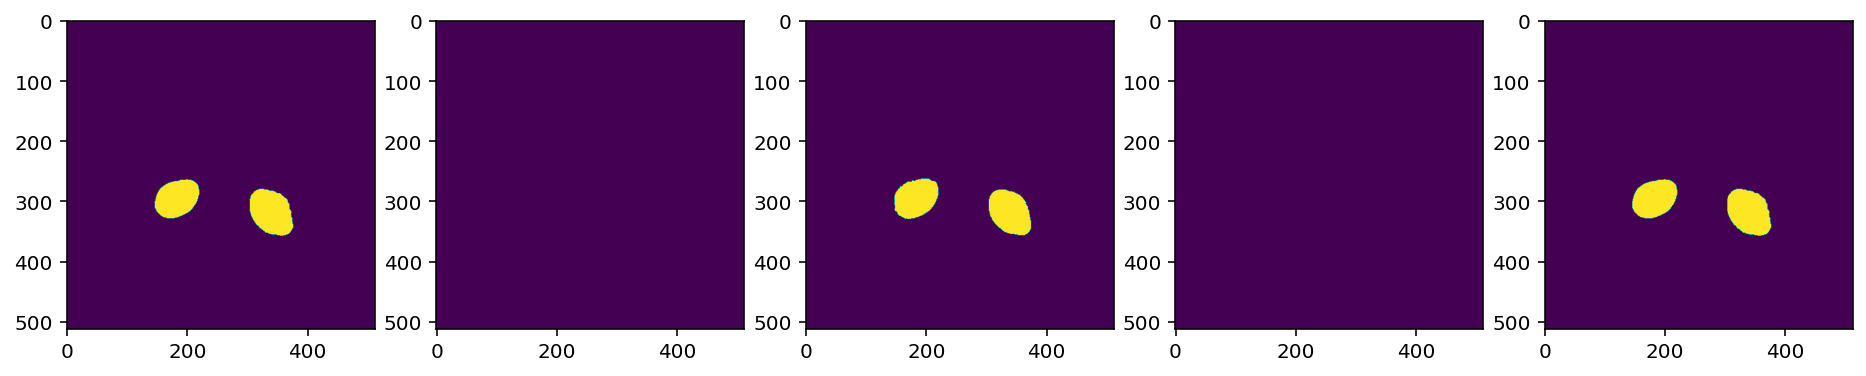

0.9853777155594761


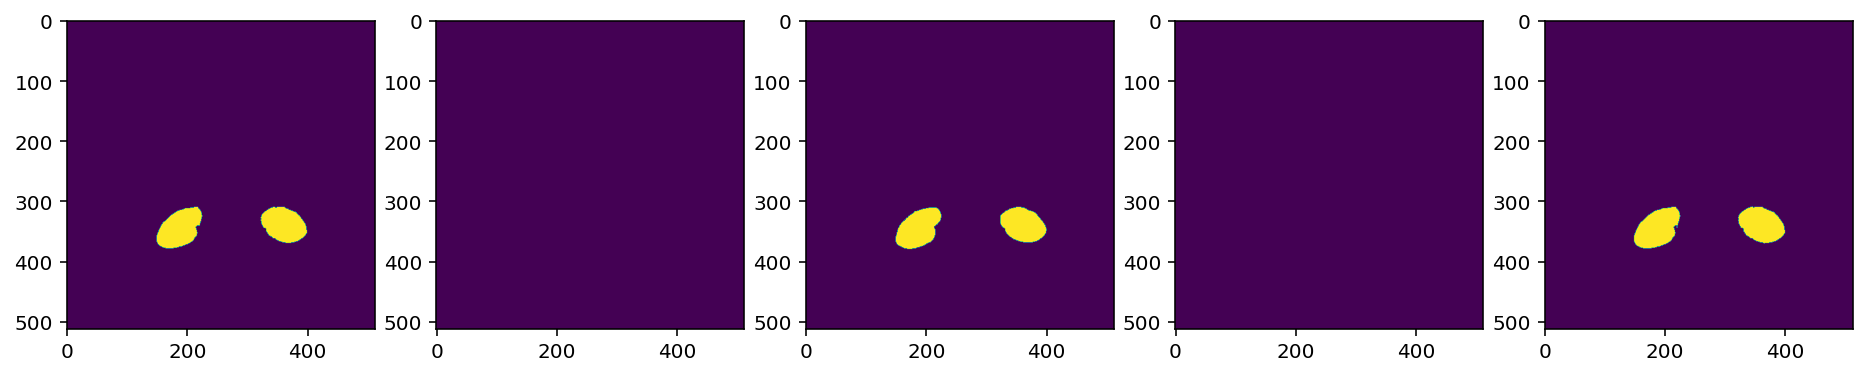

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 19 	Training Loss: 0.388068 	Validation Loss: 0.502478


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9812937508478483


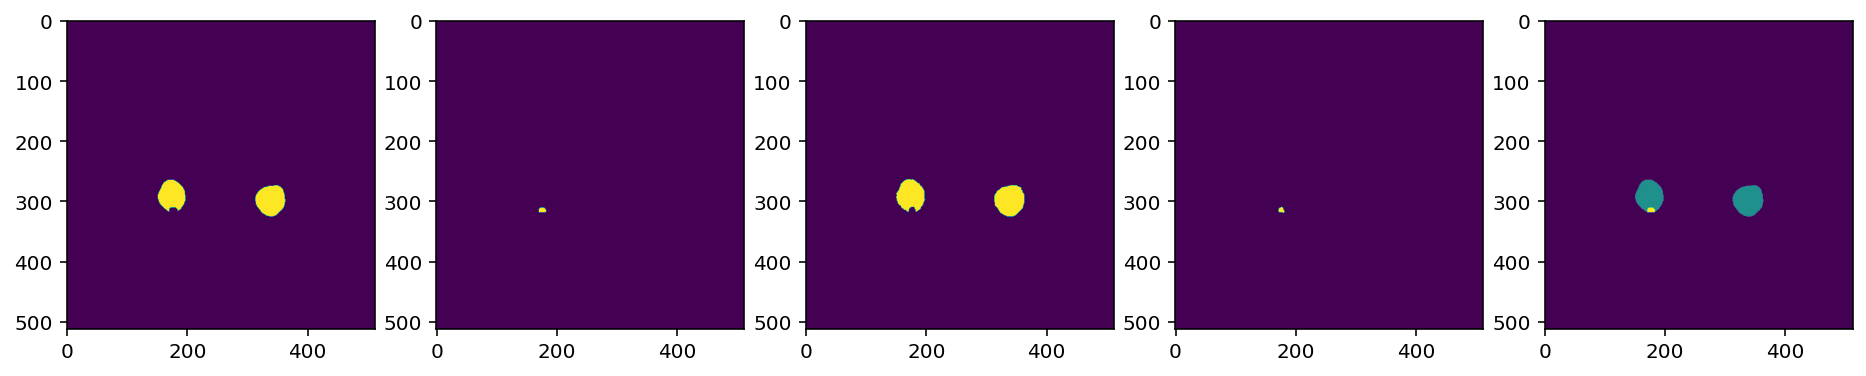

0.9802640327246033


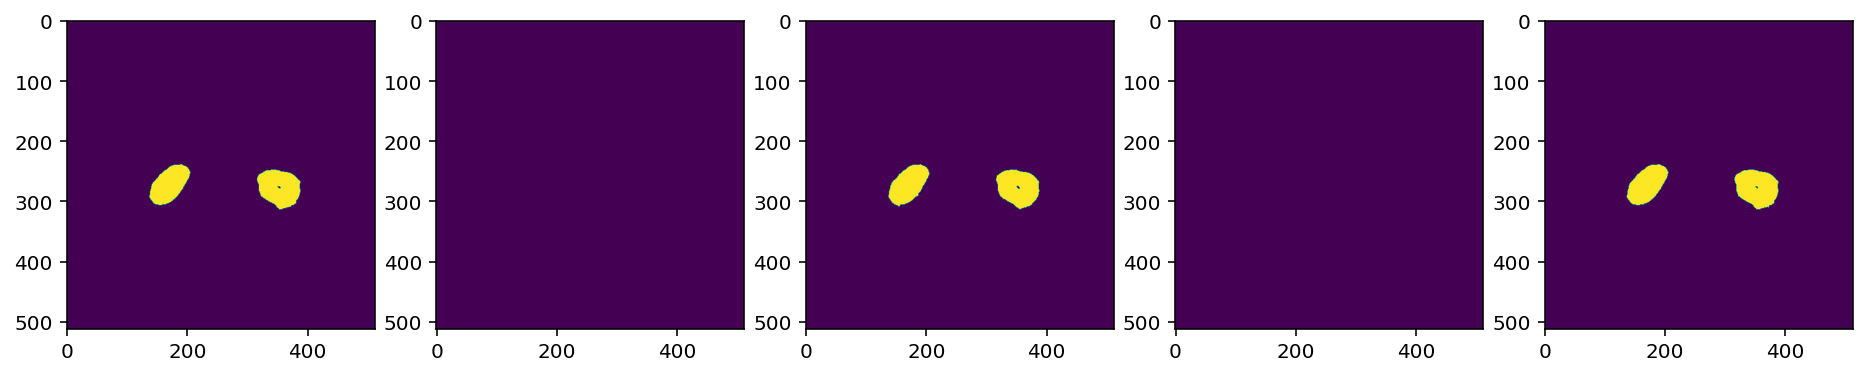

0.9646283778045237


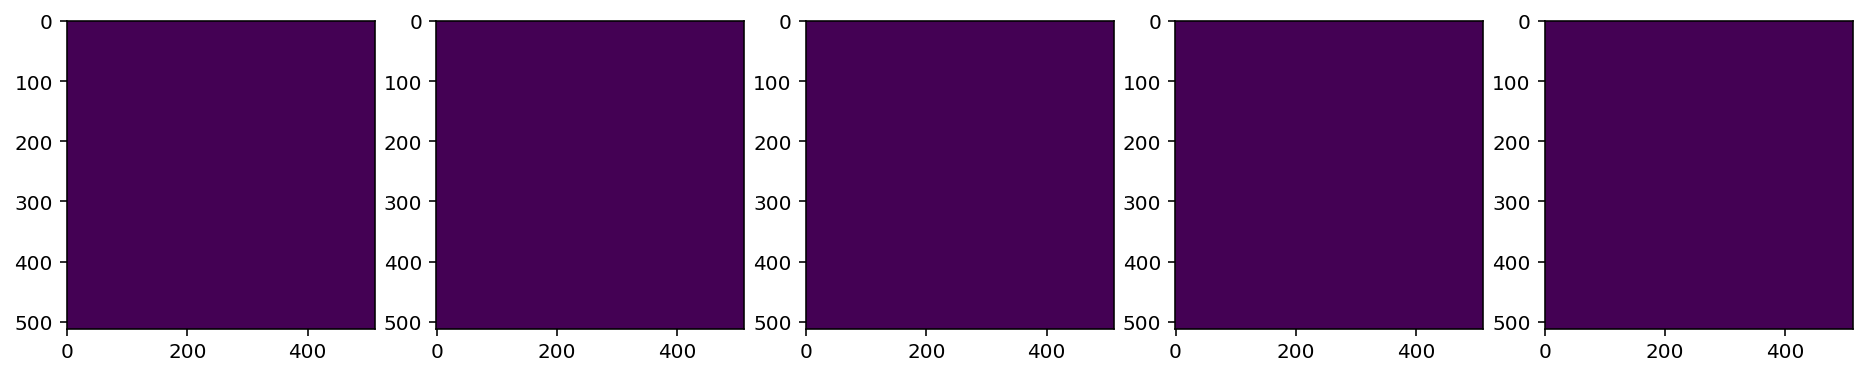

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 20 	Training Loss: 0.382220 	Validation Loss: 0.503743


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9885346587400077


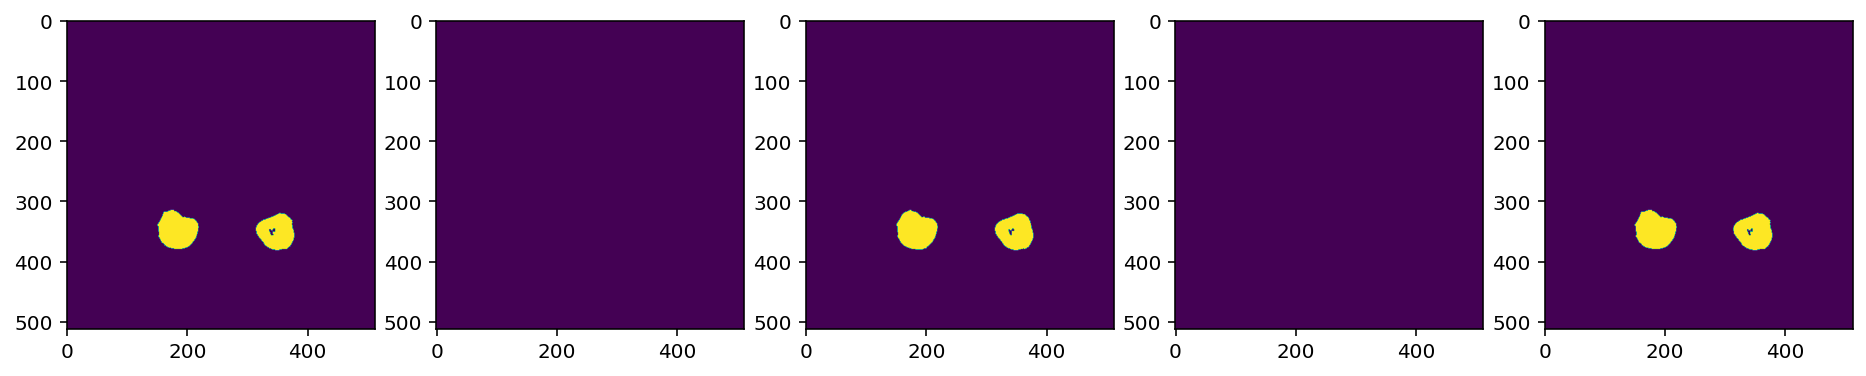

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


nan


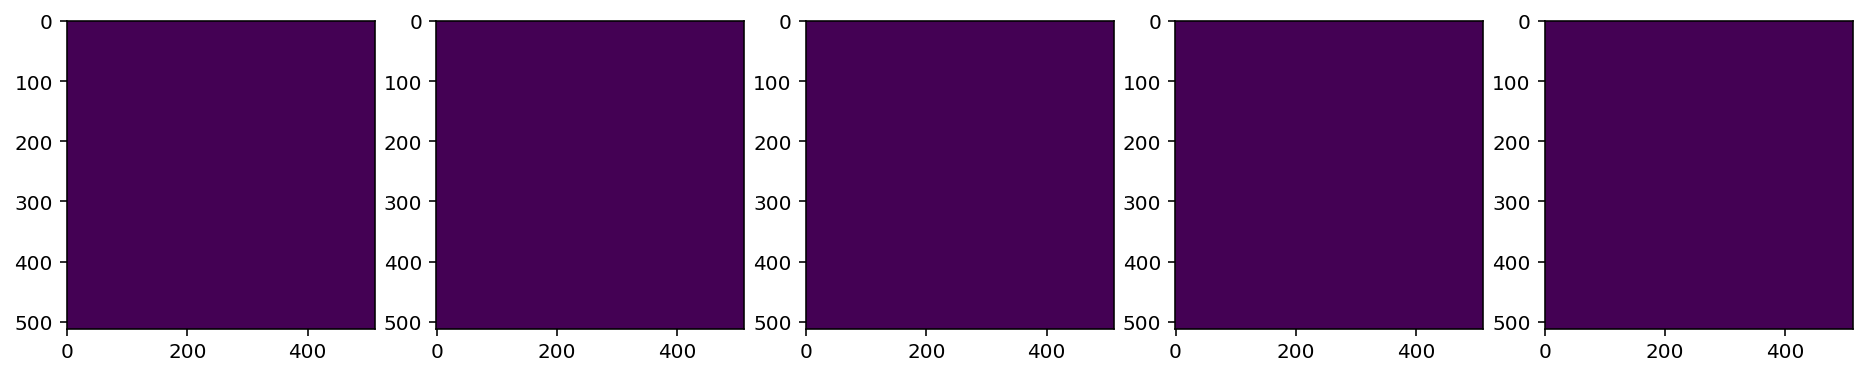

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 21 	Training Loss: 0.380588 	Validation Loss: 0.515515


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9644619637270722


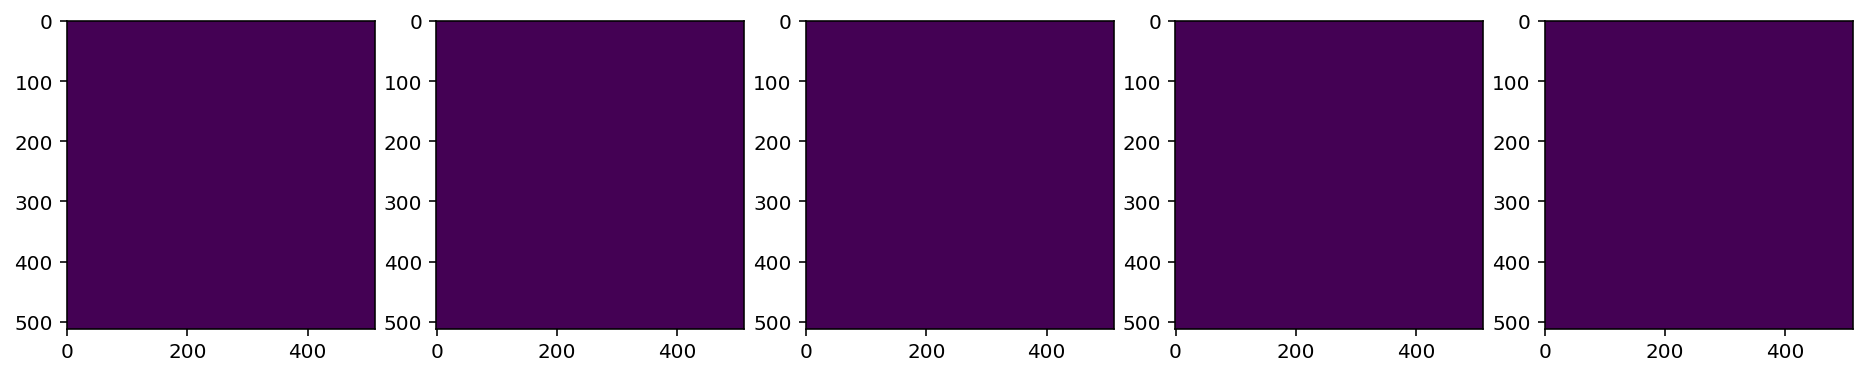

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


nan


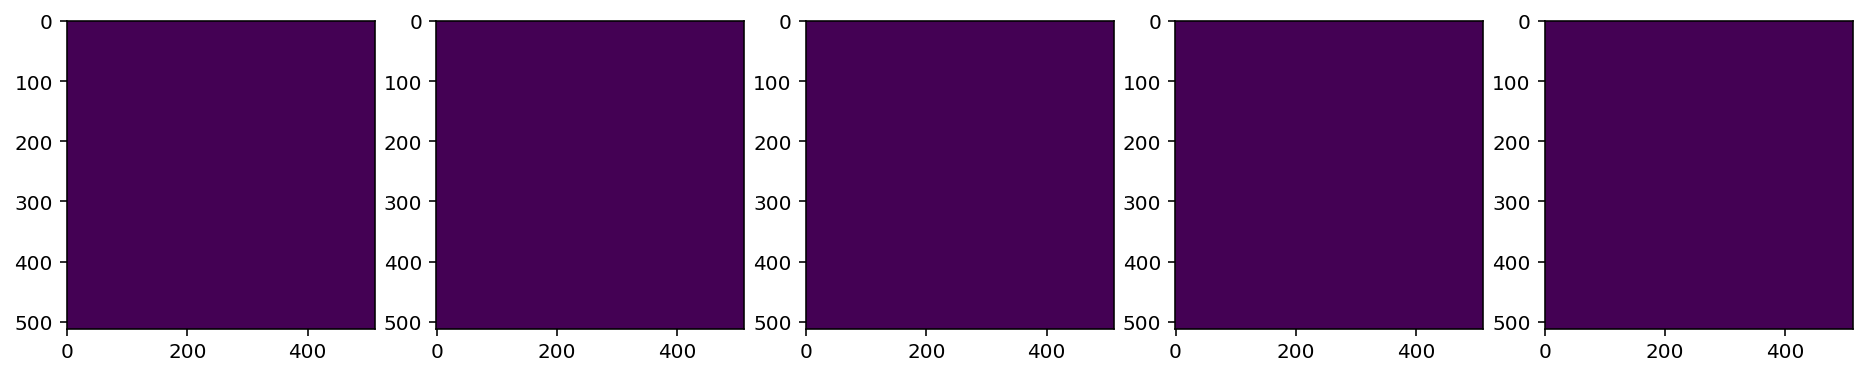

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 22 	Training Loss: 0.387944 	Validation Loss: 0.509168


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9910000035166715


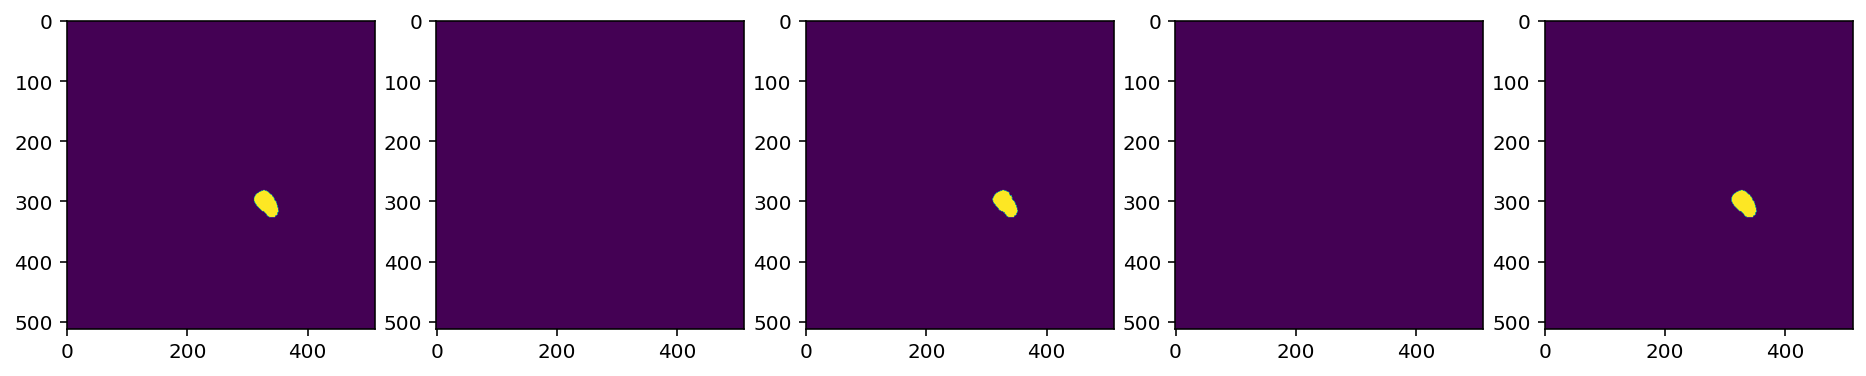

0.9697648037410729


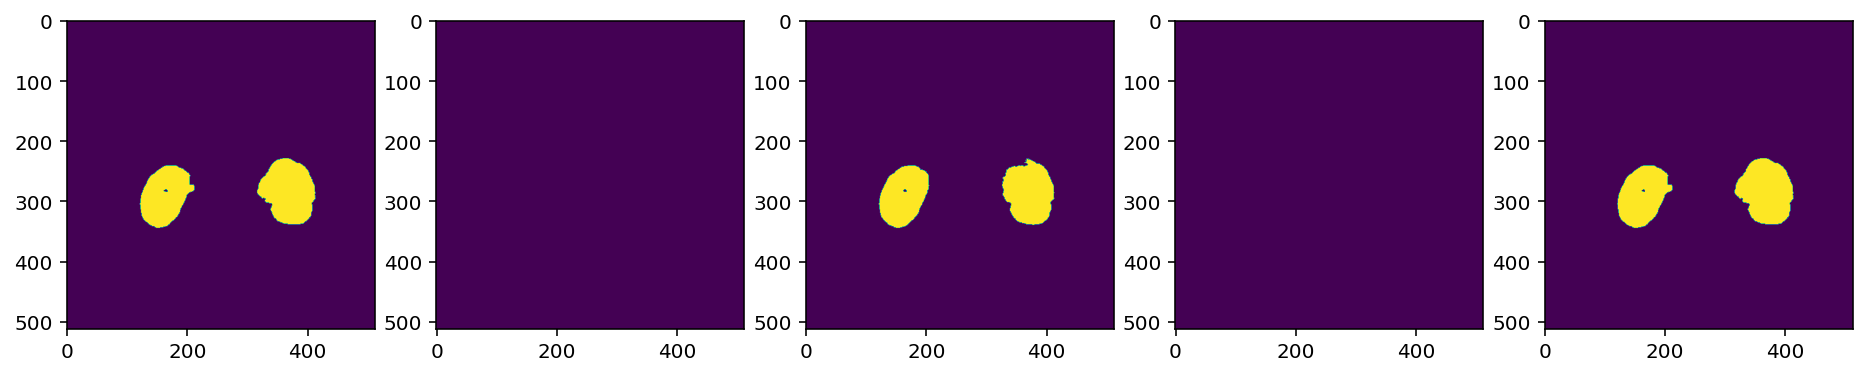

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 23 	Training Loss: 0.387520 	Validation Loss: 0.518441


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9812130737985276


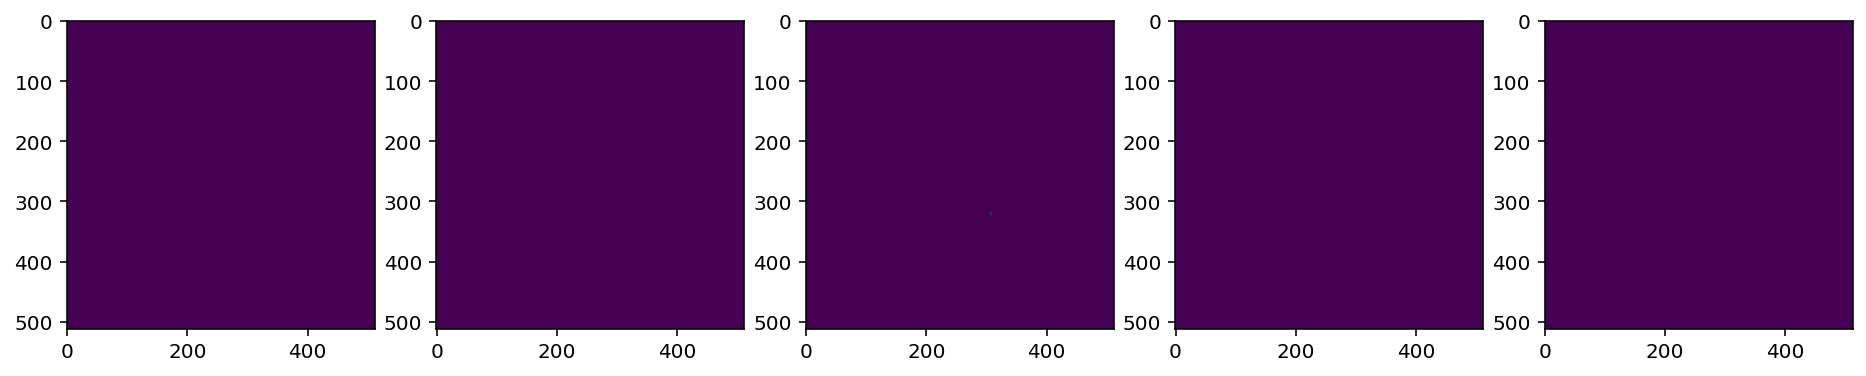

0.9831473890606808


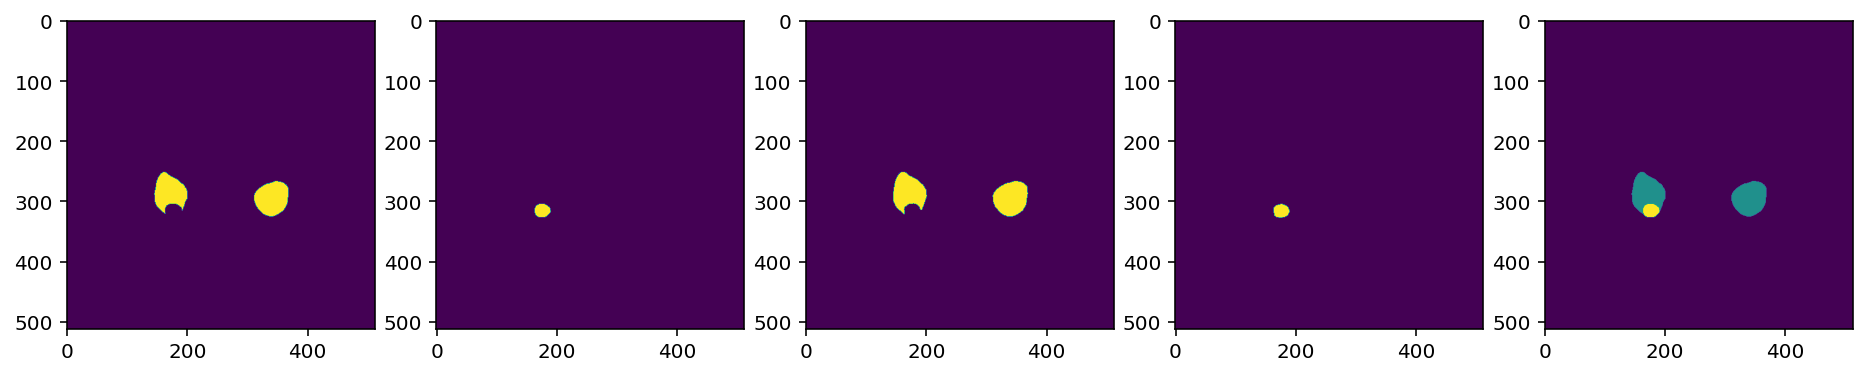

0.9861768903469779


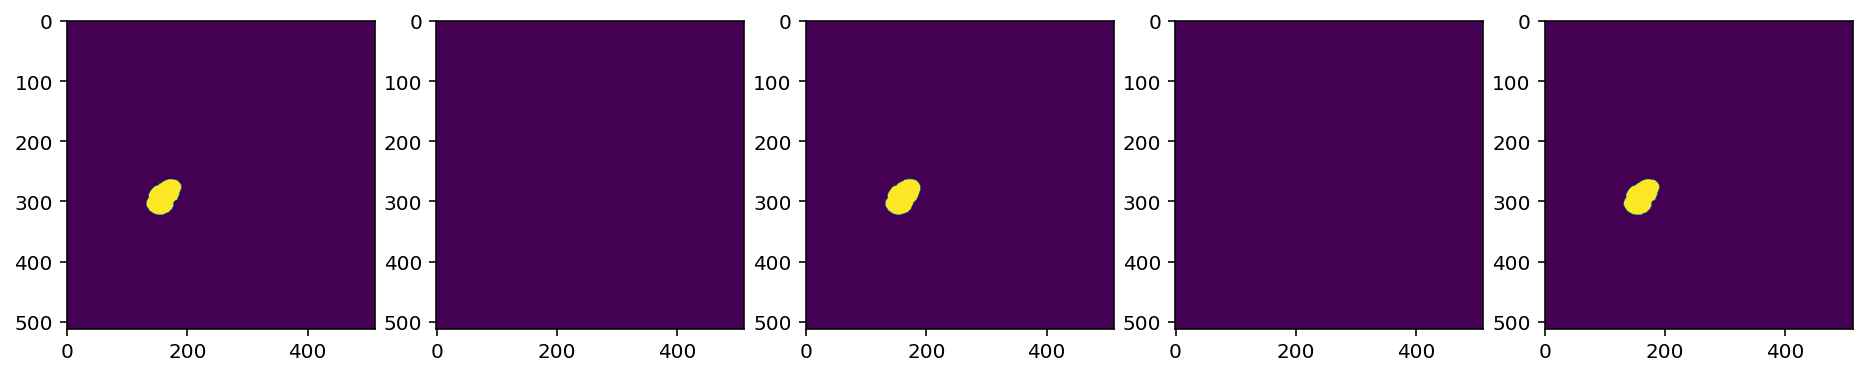

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 24 	Training Loss: 0.381013 	Validation Loss: 0.514016


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9613059301168163


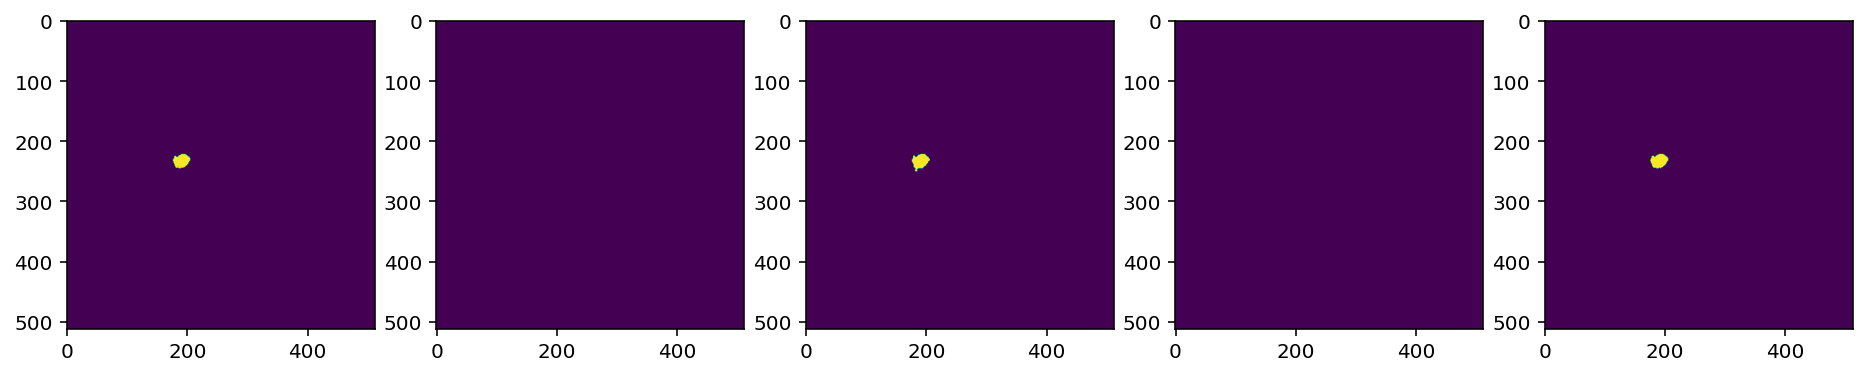

0.8901837952765405


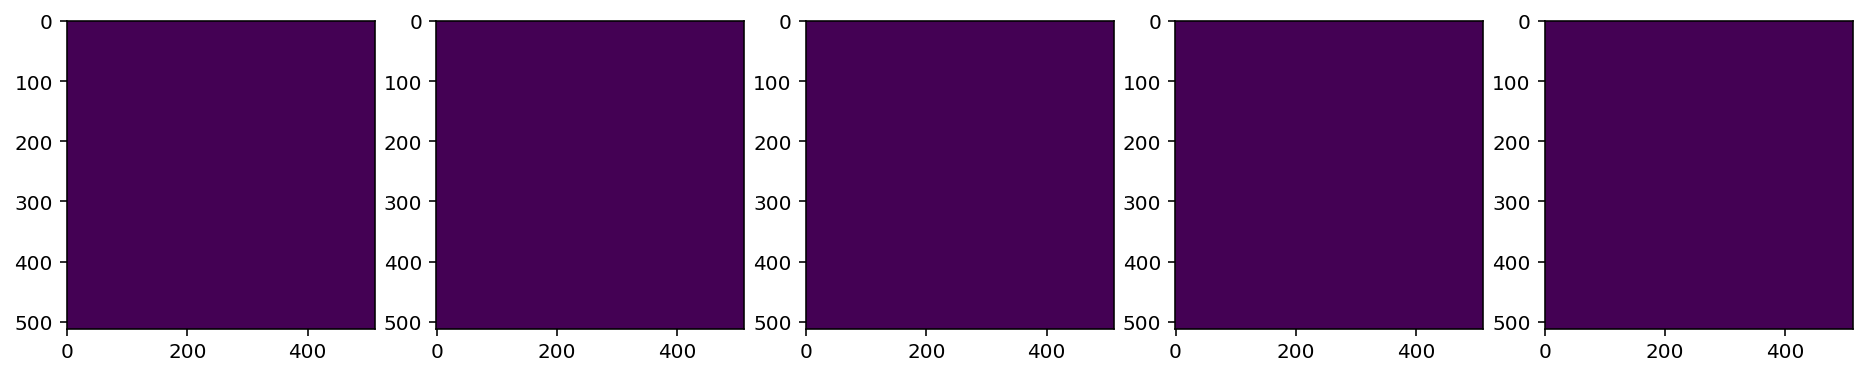

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 25 	Training Loss: 0.381441 	Validation Loss: 0.508344


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9745327732097511


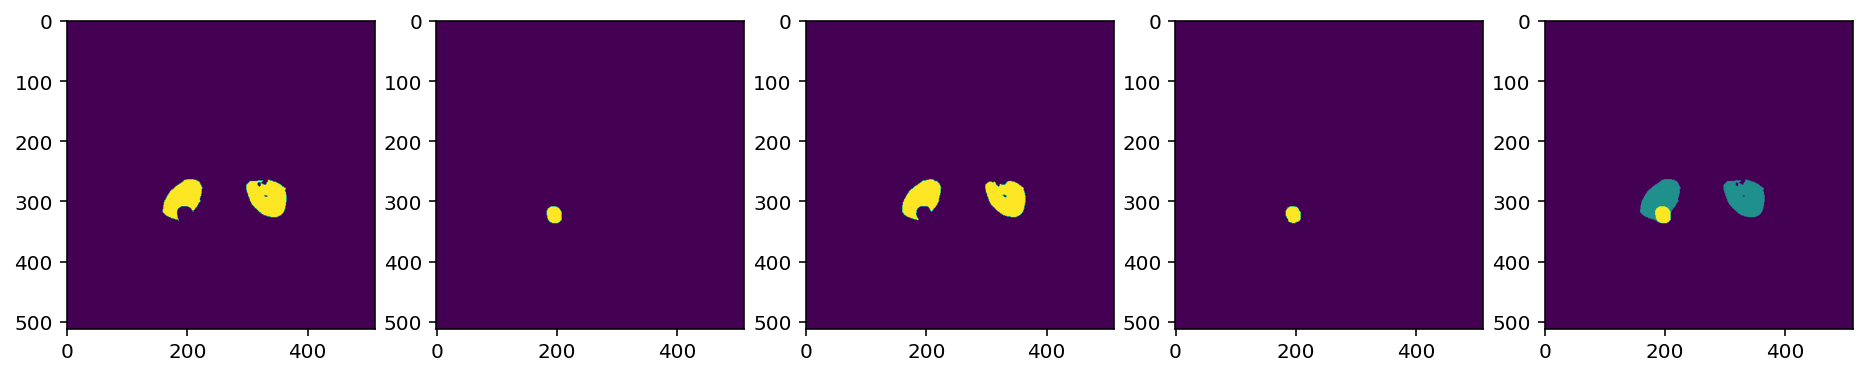

0.9891306226836492


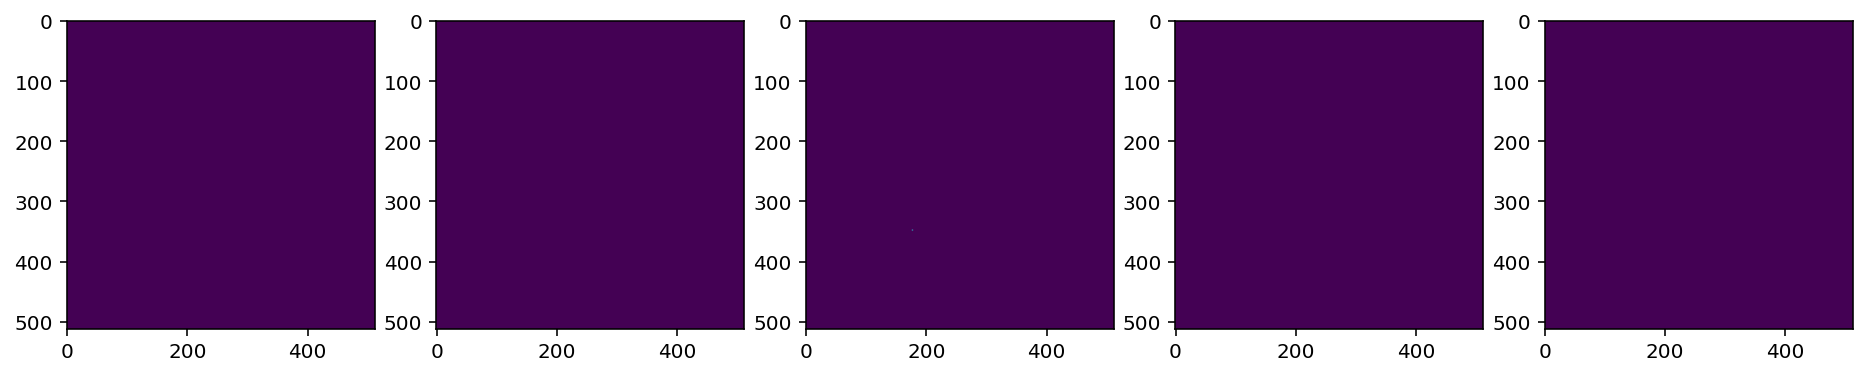

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 26 	Training Loss: 0.385162 	Validation Loss: 0.511629


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9811642135254464


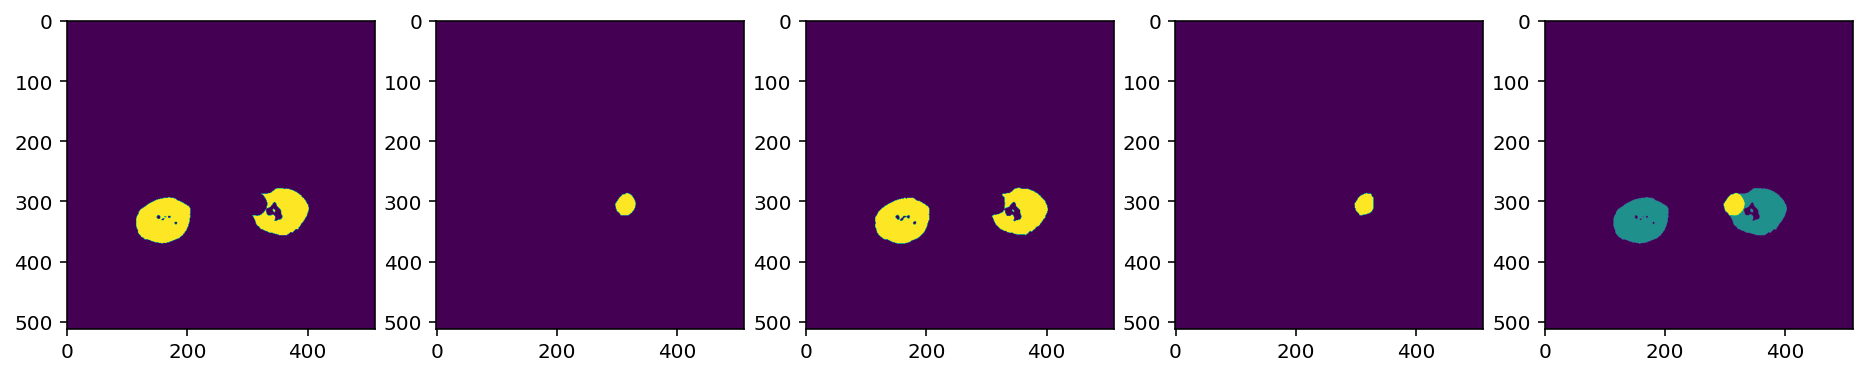

0.9899434843493965


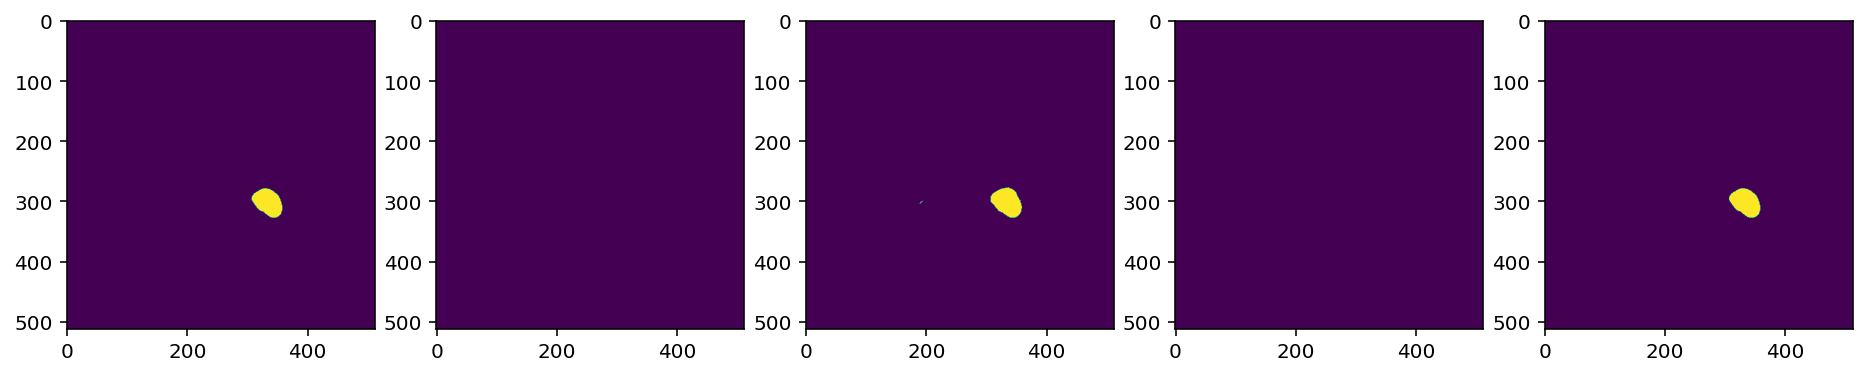

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 27 	Training Loss: 0.384430 	Validation Loss: 0.506927


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9834637562042605


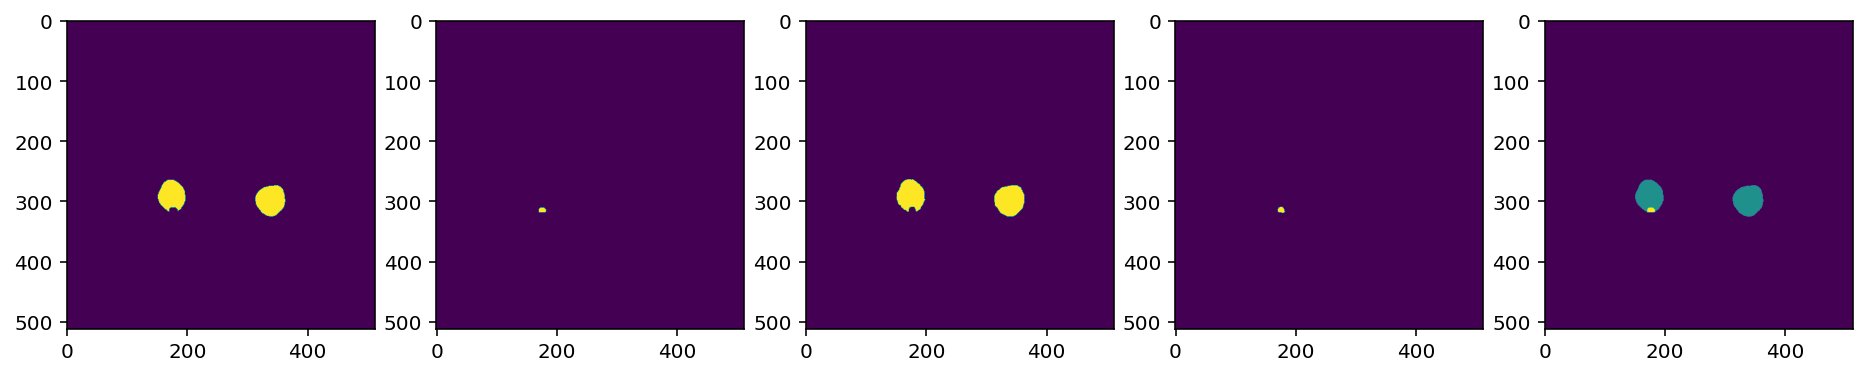

0.9807398295266675


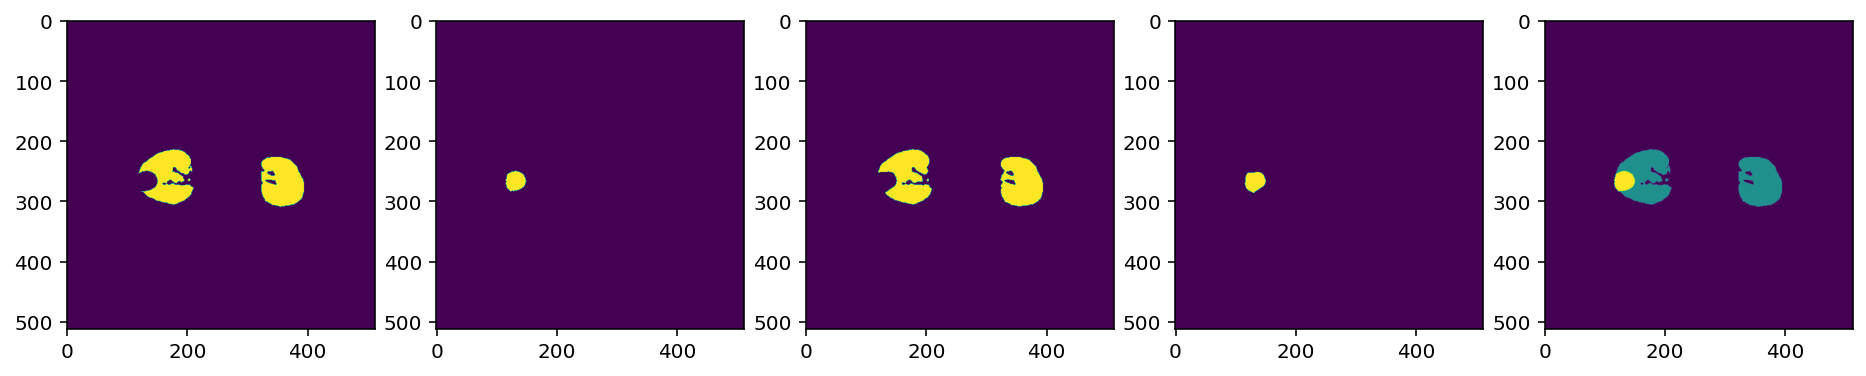

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 28 	Training Loss: 0.380559 	Validation Loss: 0.510732


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9656549618372934


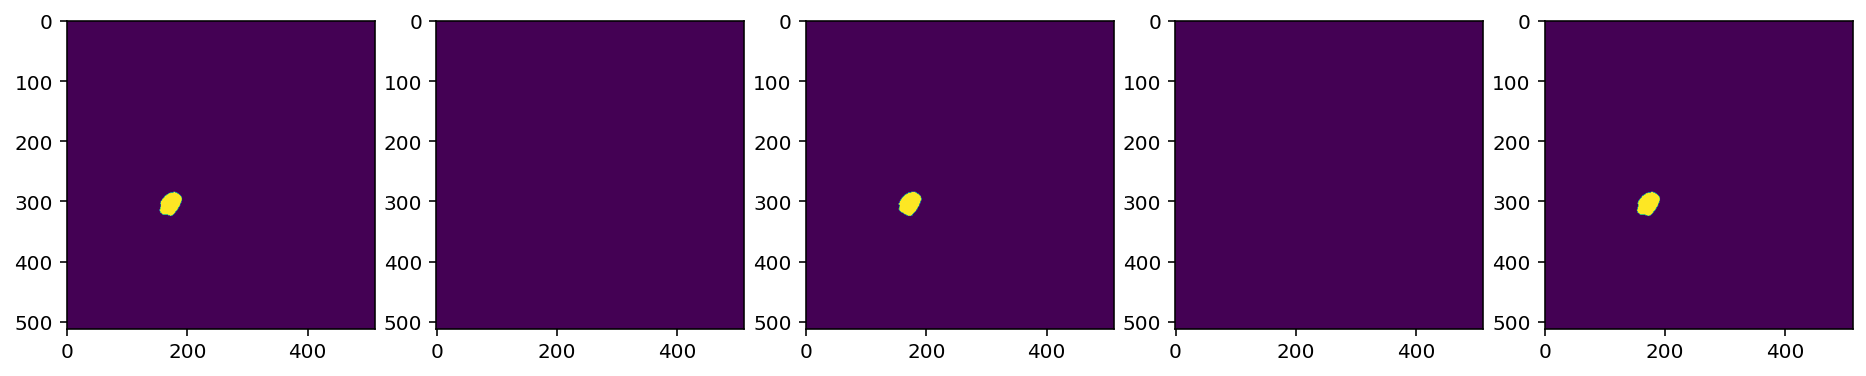

0.9868397836556699


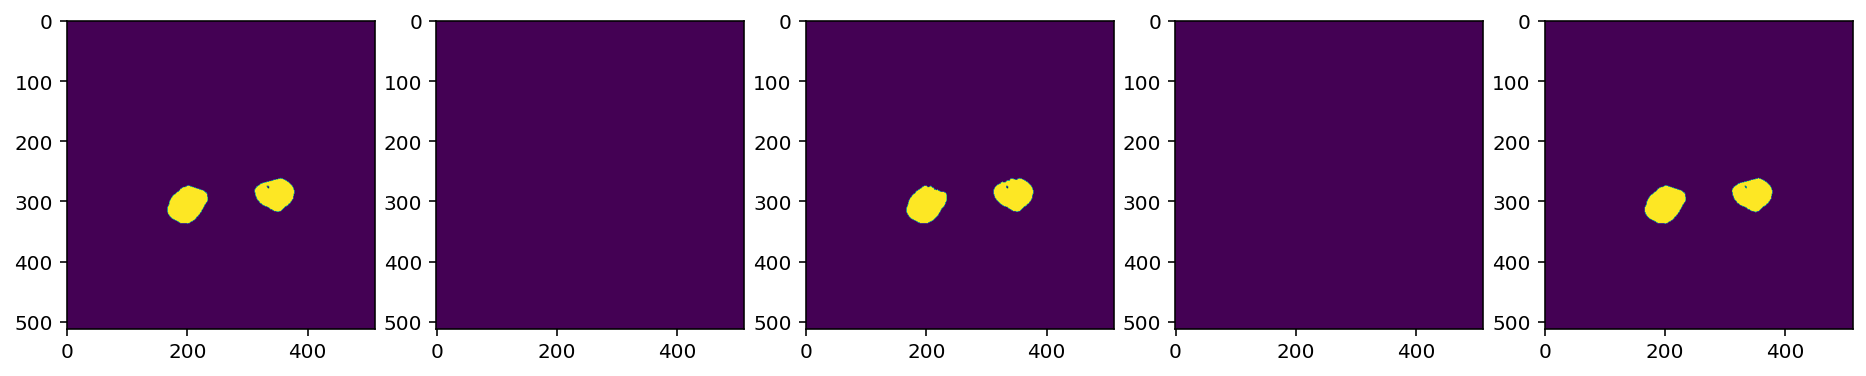

0.9882191999804028


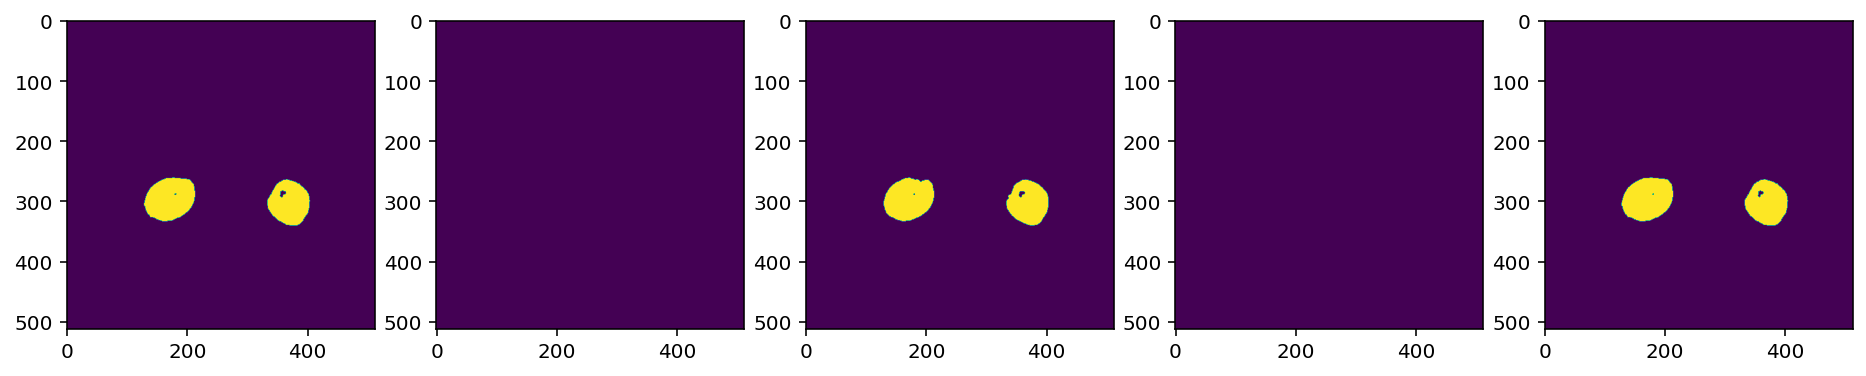

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 29 	Training Loss: 0.384744 	Validation Loss: 0.509443


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9694881813892267


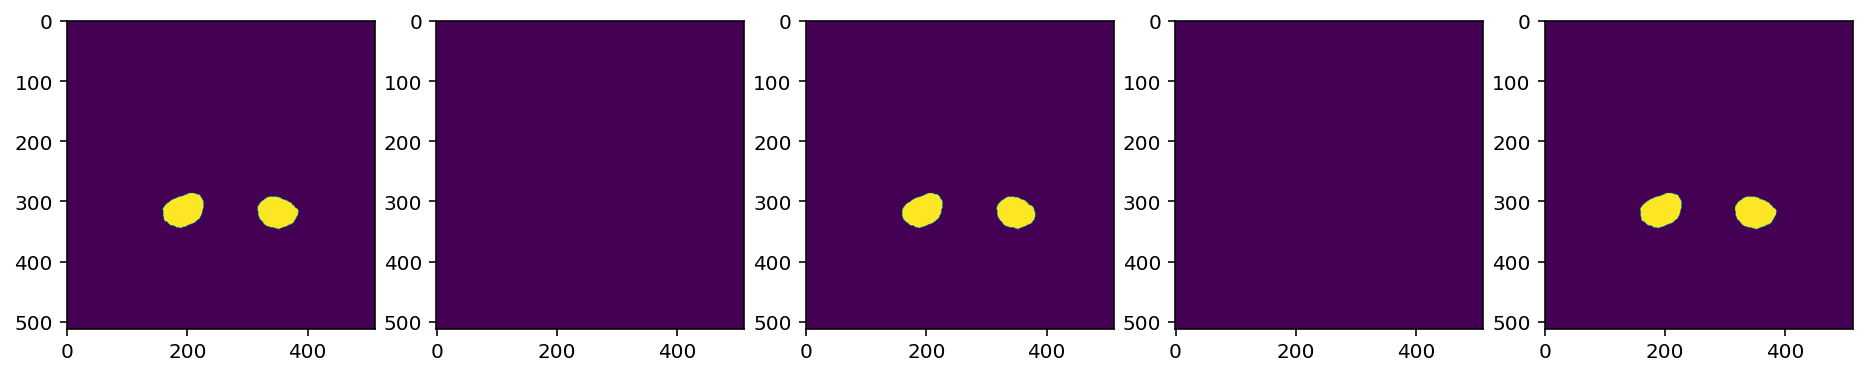

0.8512379420573619


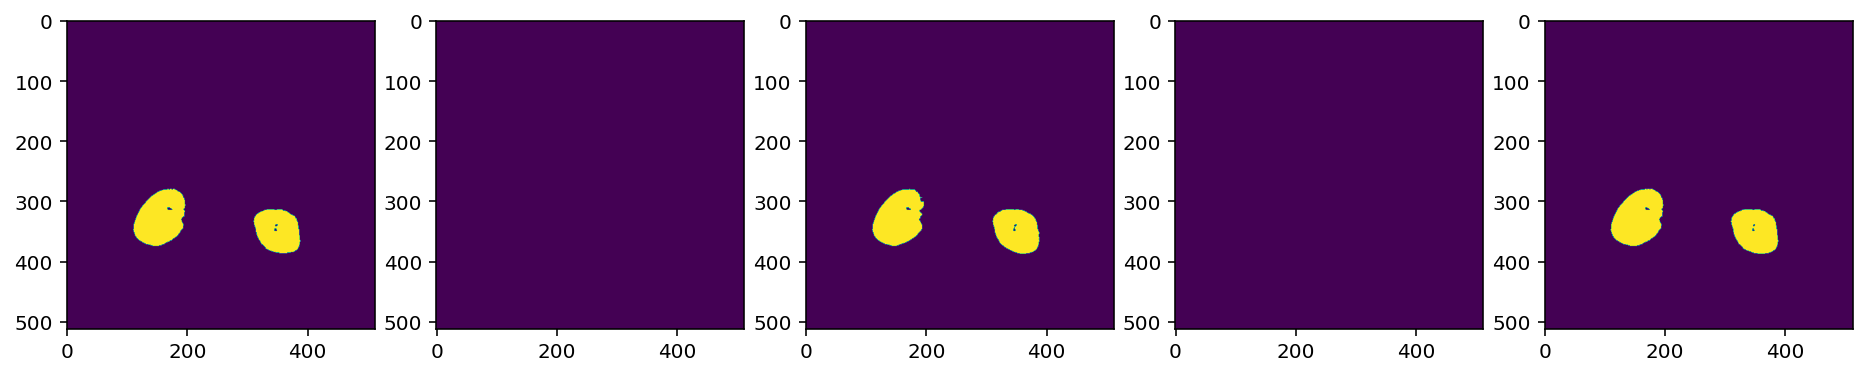

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 30 	Training Loss: 0.383003 	Validation Loss: 0.508099


  0%|          | 0/2240 [00:00<?, ?it/s]

0.973497550010529


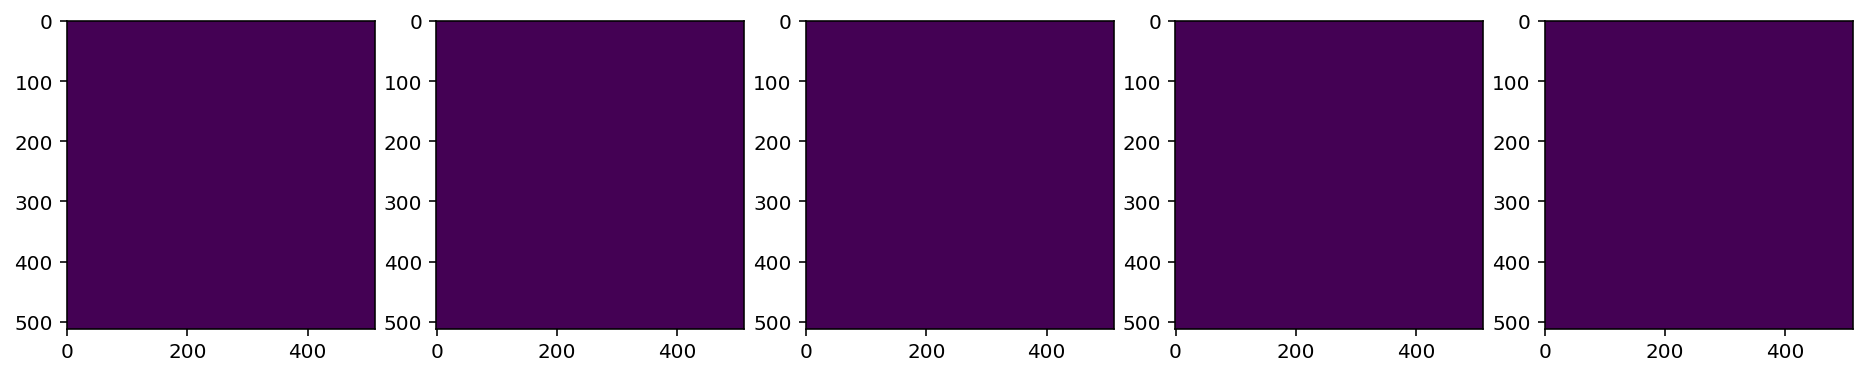

0.9812473551119381


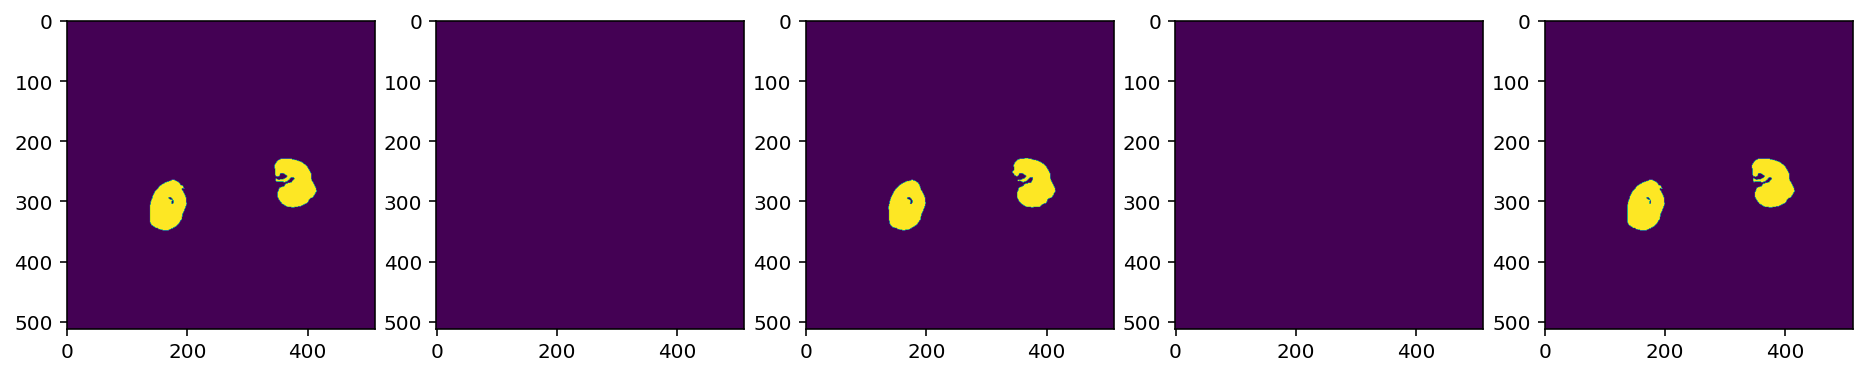

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 31 	Training Loss: 0.387975 	Validation Loss: 0.502624


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9782368087027544


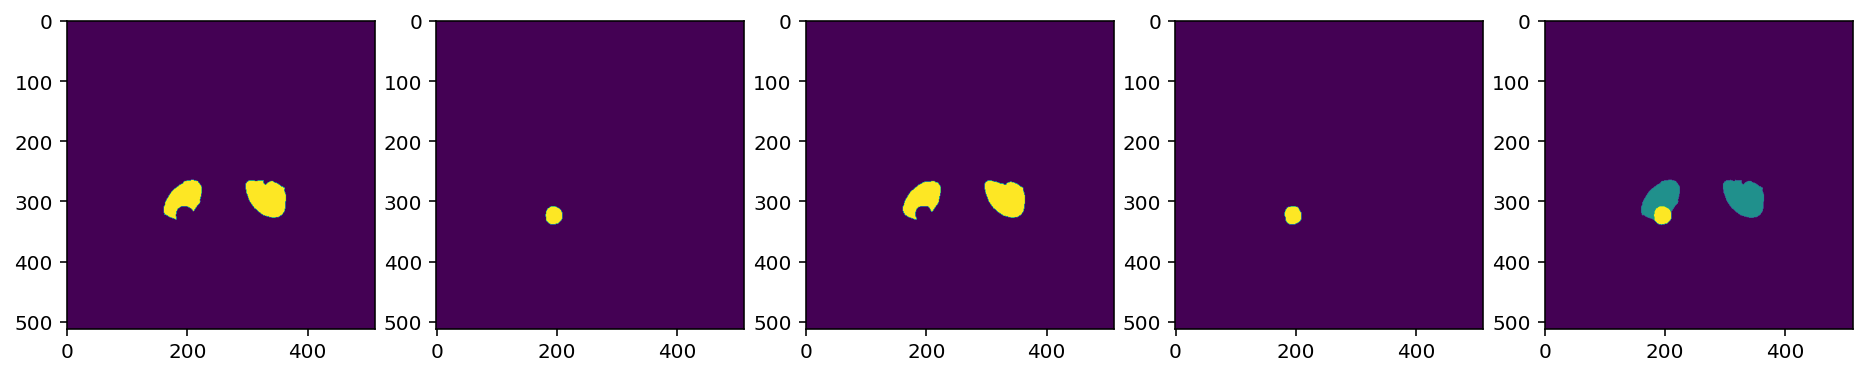

0.9715922527051917


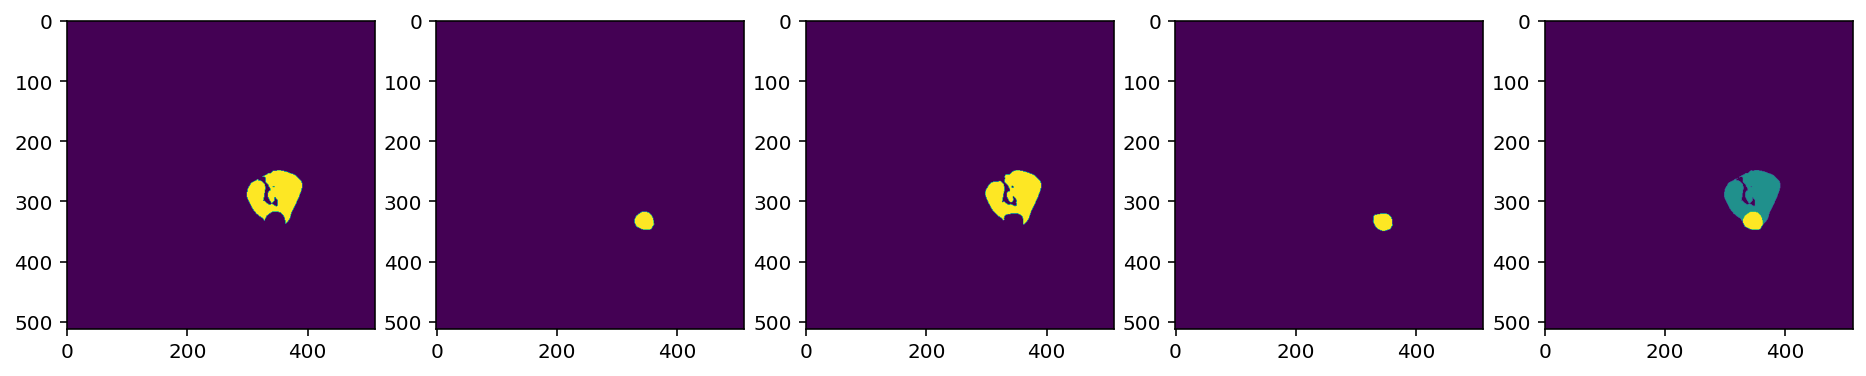

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 32 	Training Loss: 0.385334 	Validation Loss: 0.510461


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9877015604555945


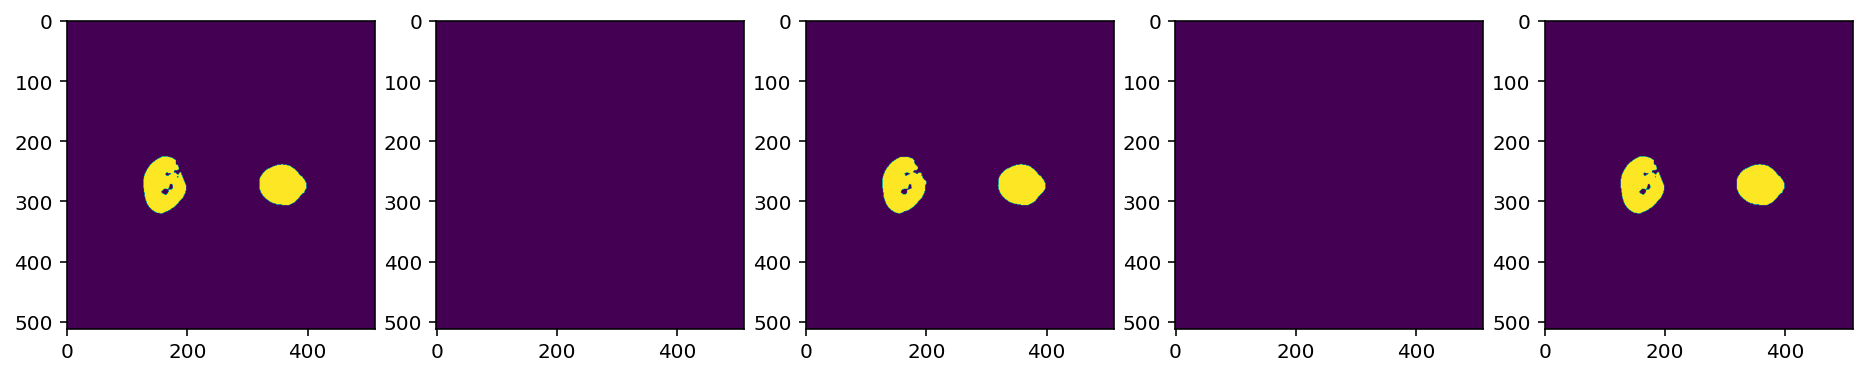

0.9099846155282161


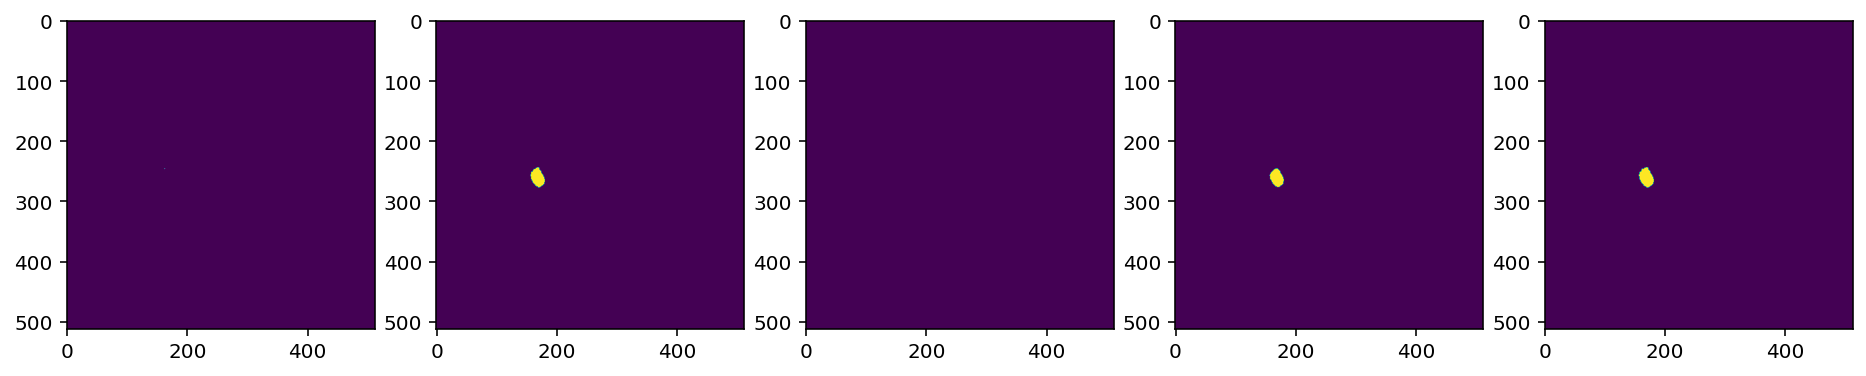

0.9787987319790121


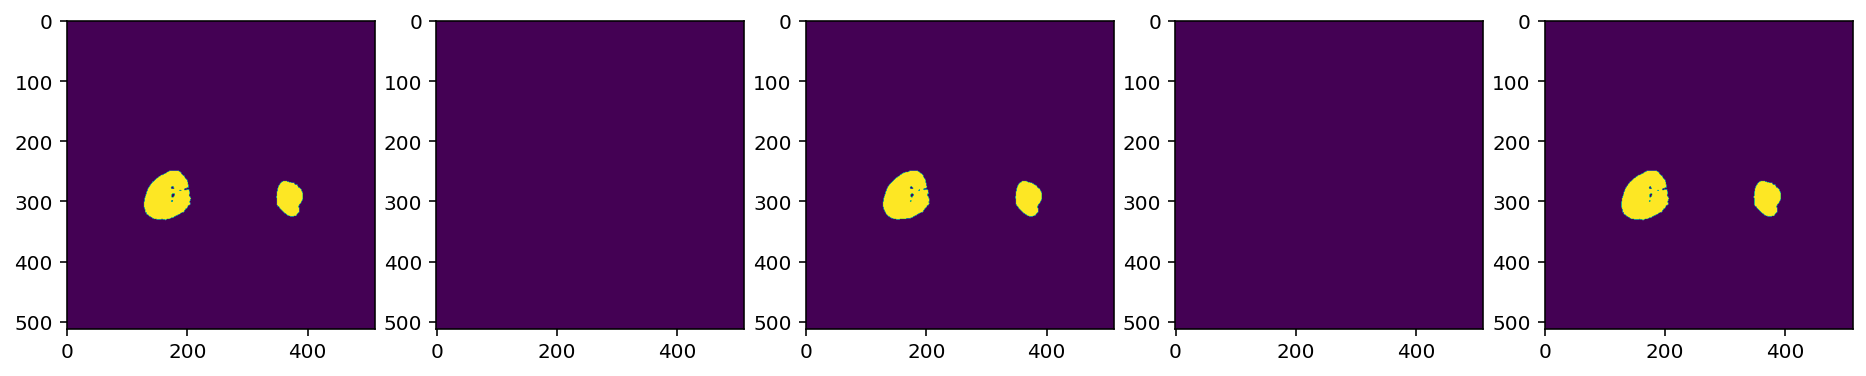

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 33 	Training Loss: 0.380477 	Validation Loss: 0.505879


  0%|          | 0/2240 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


nan


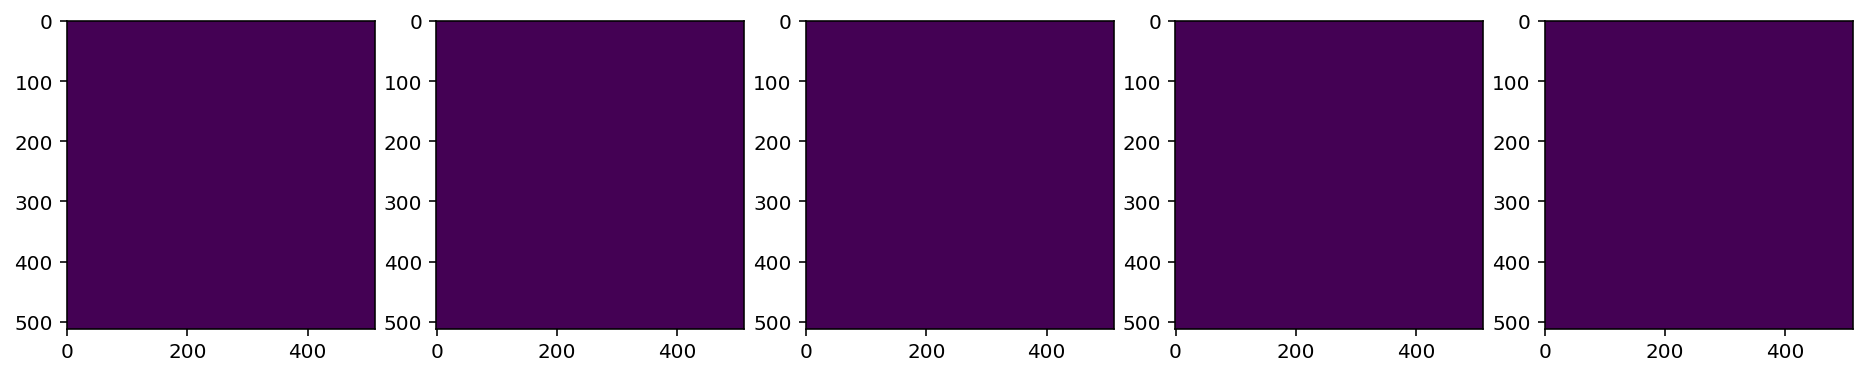

0.9907502585252809


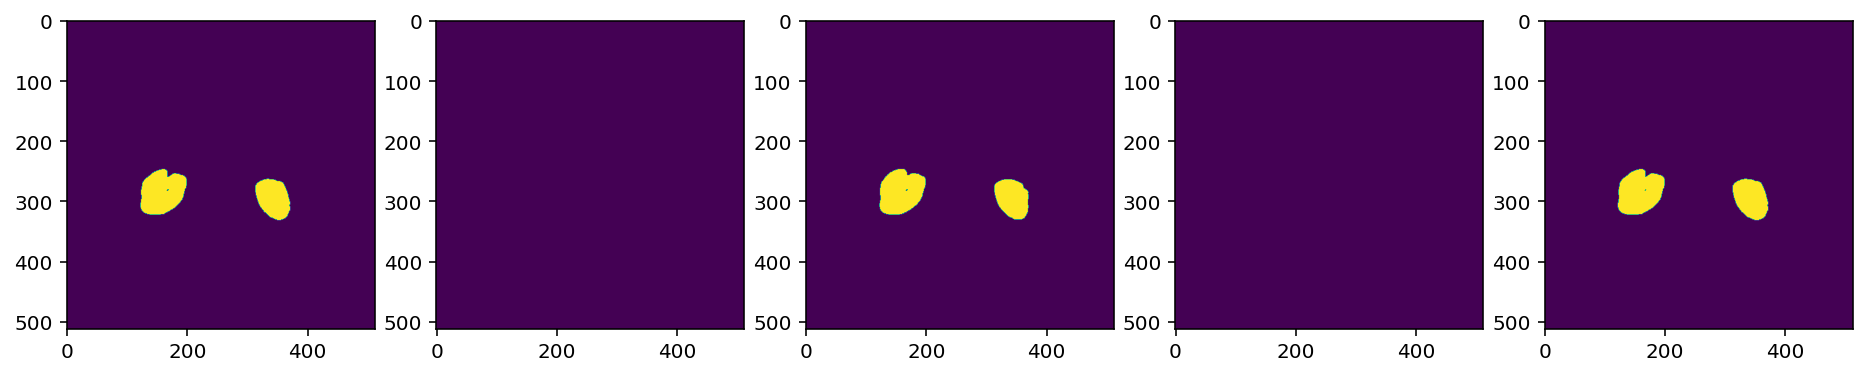

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 34 	Training Loss: 0.381671 	Validation Loss: 0.515635


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9803565638364236


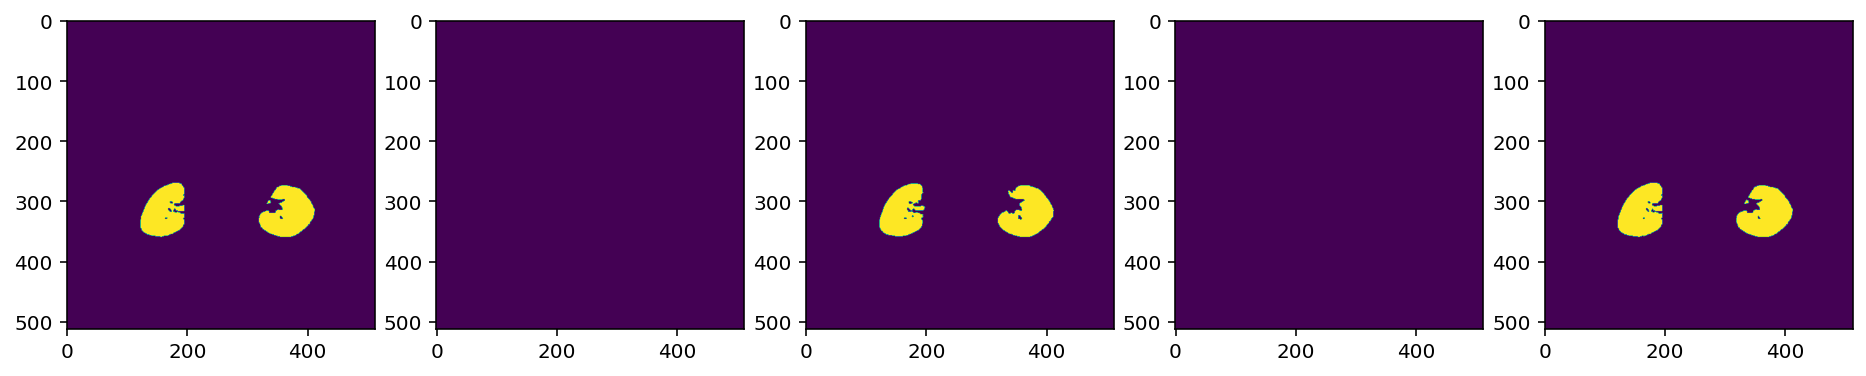

0.9527501828382924


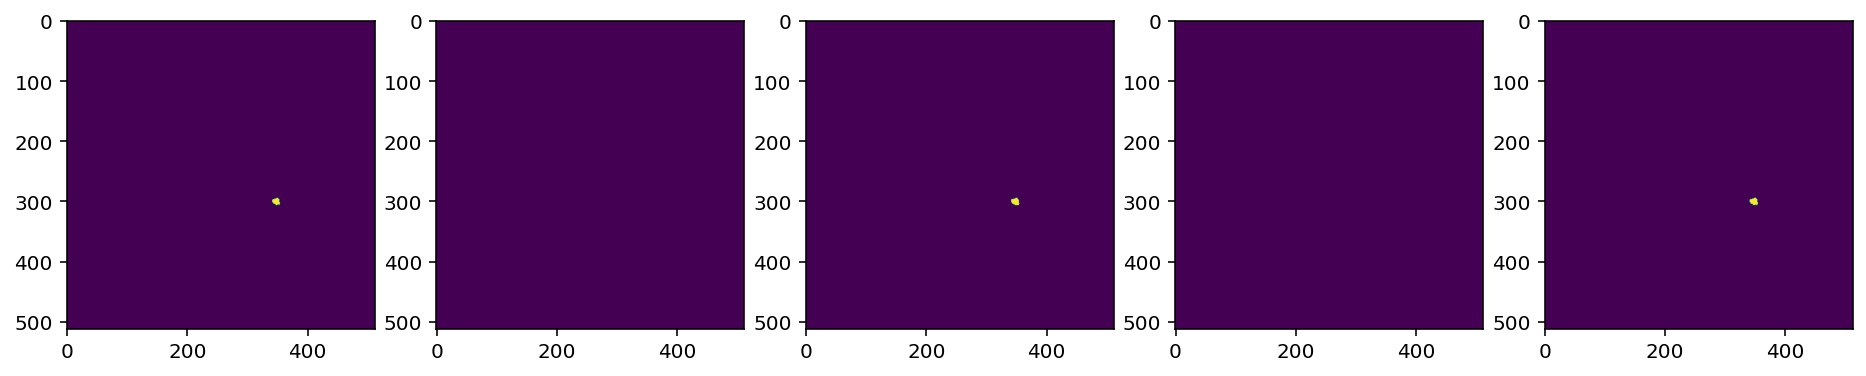

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 35 	Training Loss: 0.387328 	Validation Loss: 0.506290


  0%|          | 0/2240 [00:00<?, ?it/s]

0.8083566644459215


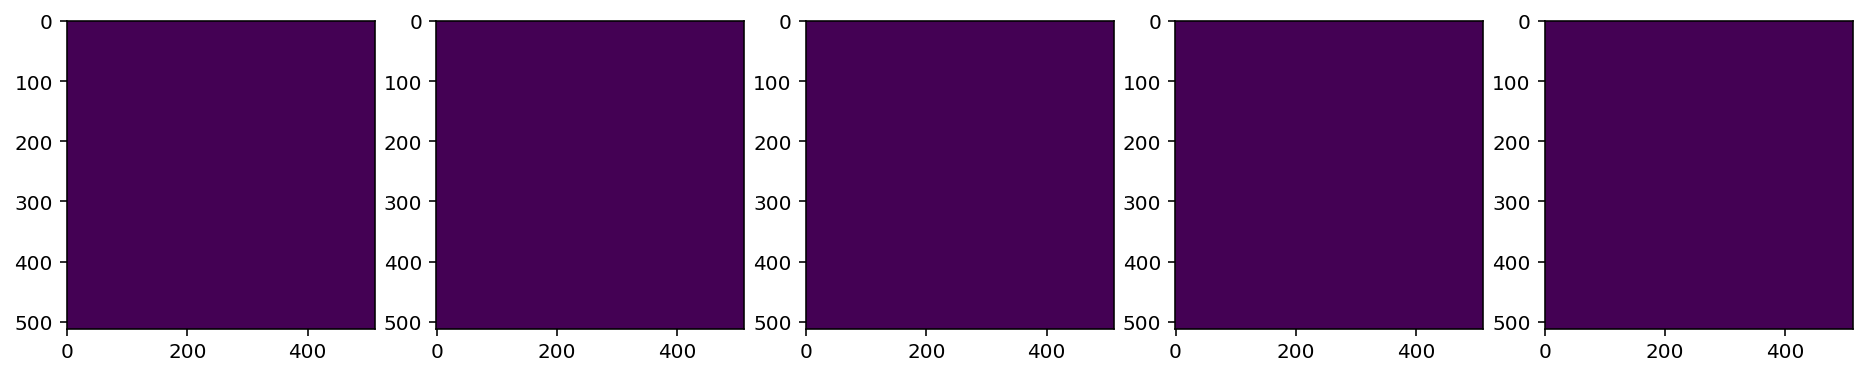

0.9641661308621402


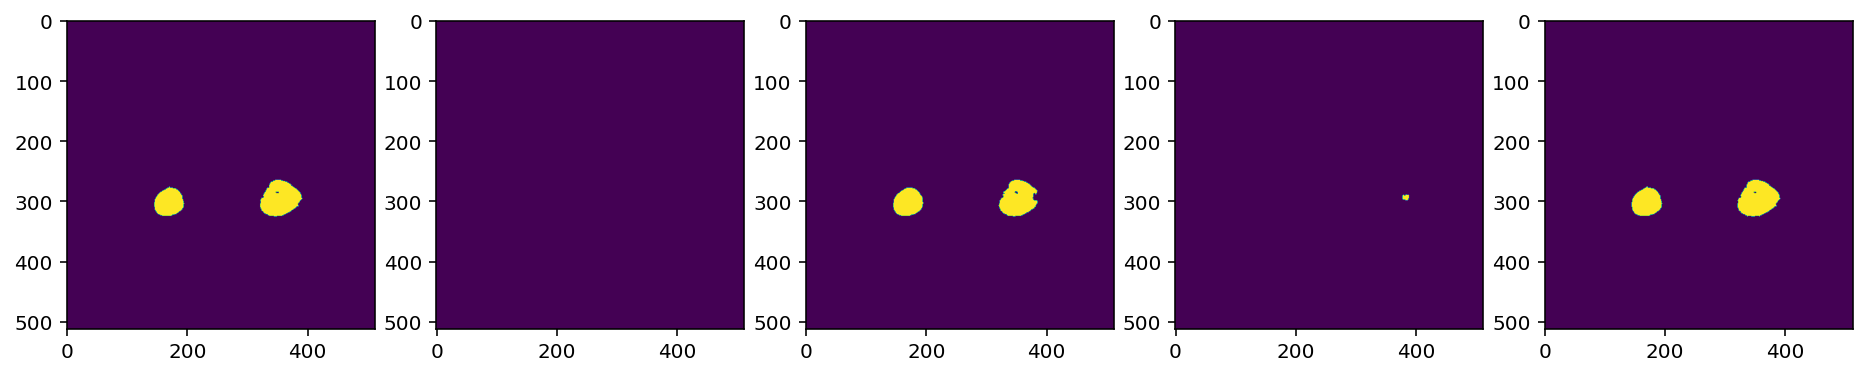

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 36 	Training Loss: 0.384027 	Validation Loss: 0.513493


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9770118086205484


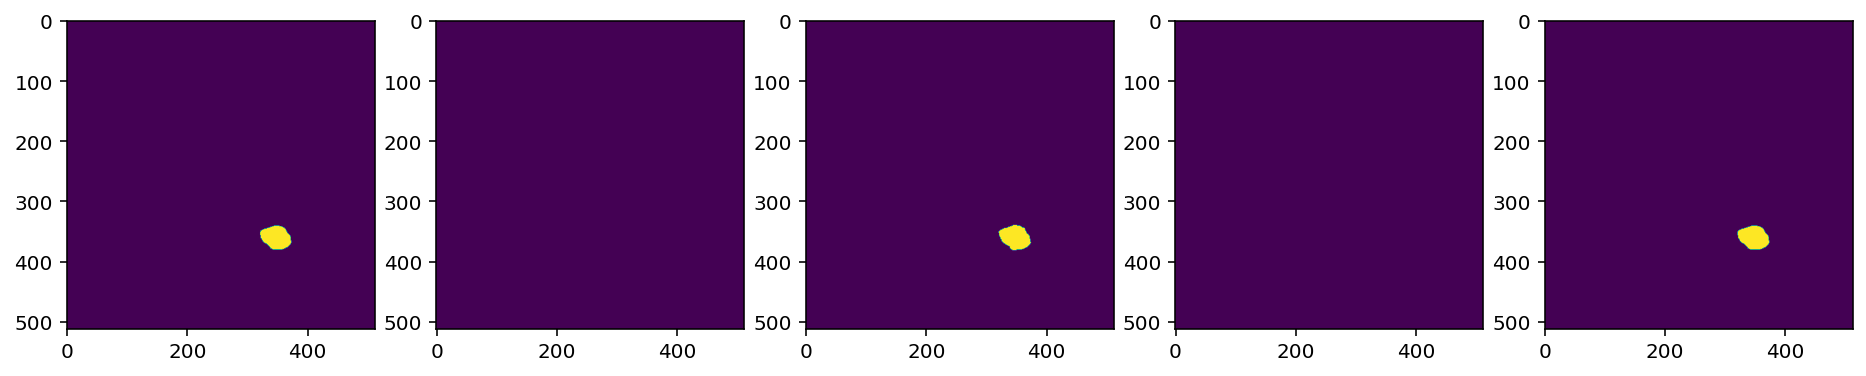

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


nan


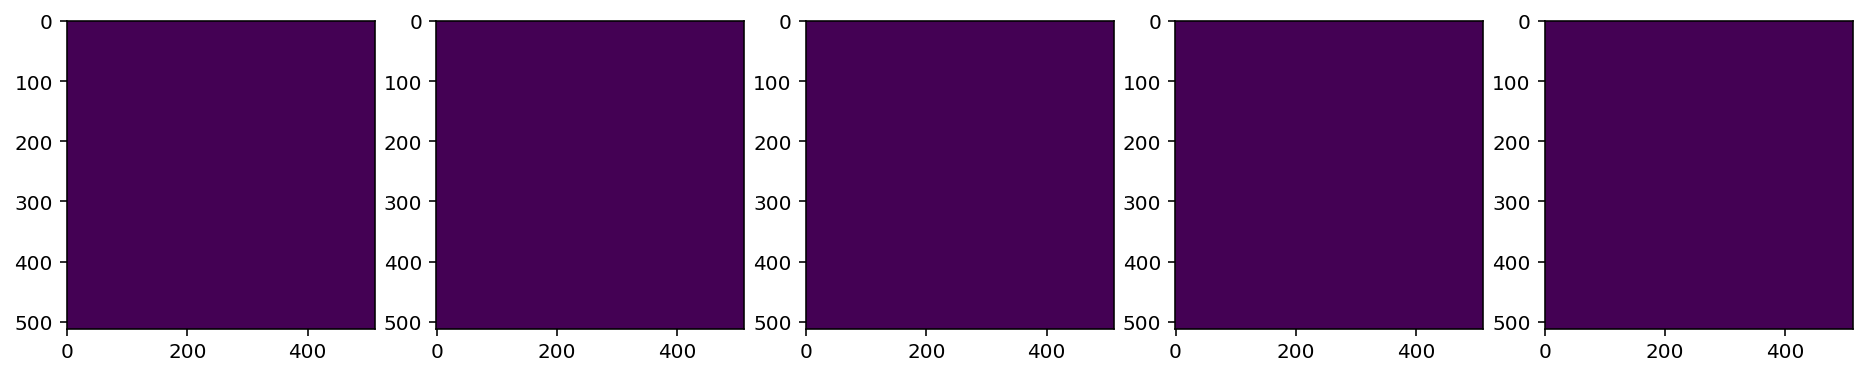

0.9922398833271453


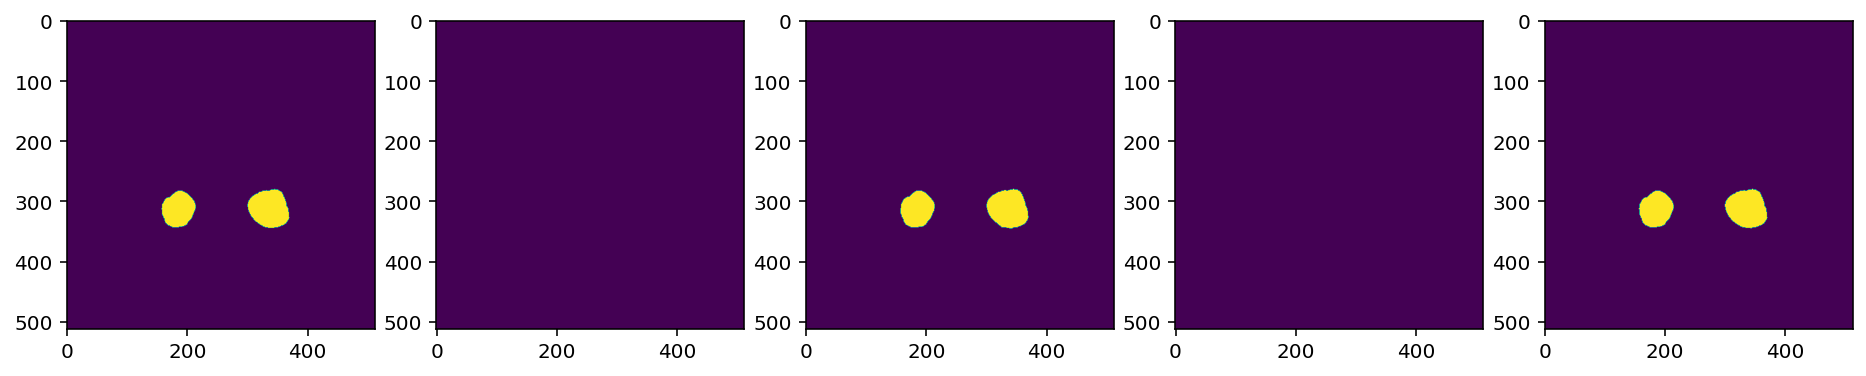

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 37 	Training Loss: 0.381364 	Validation Loss: 0.517400


  0%|          | 0/2240 [00:00<?, ?it/s]

0.992259048127065


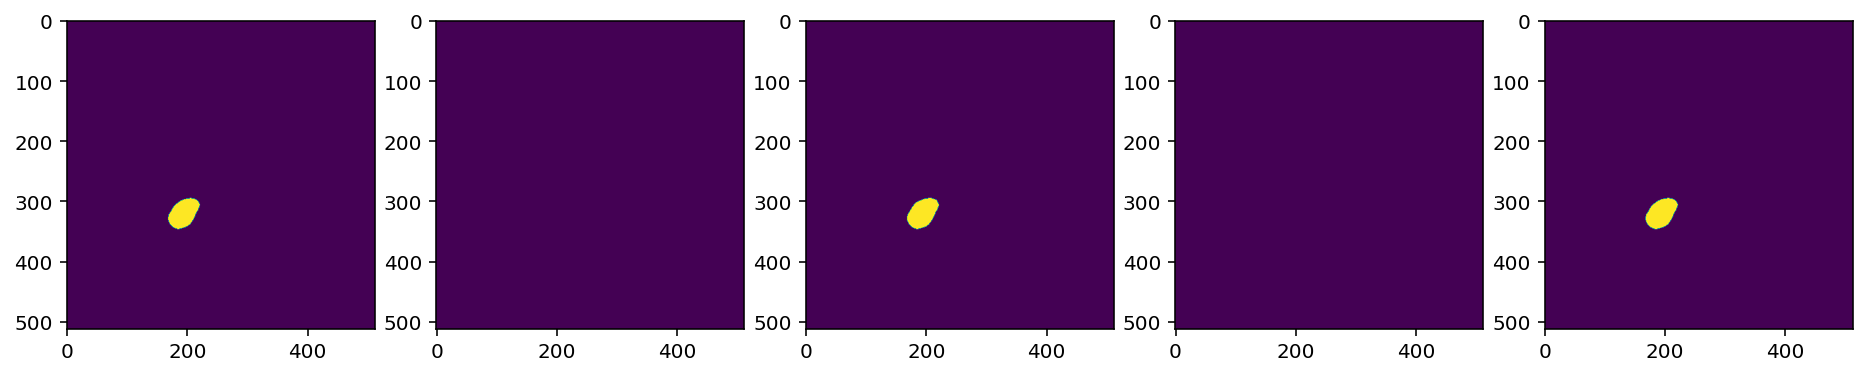

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


nan


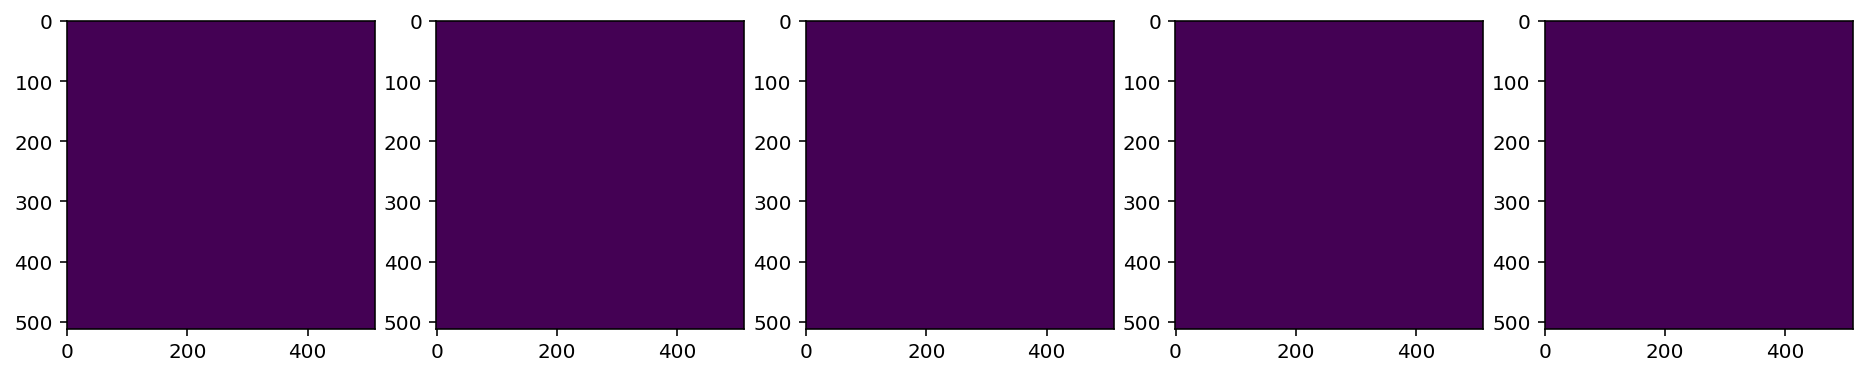

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 38 	Training Loss: 0.385377 	Validation Loss: 0.510023


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9692890386696877


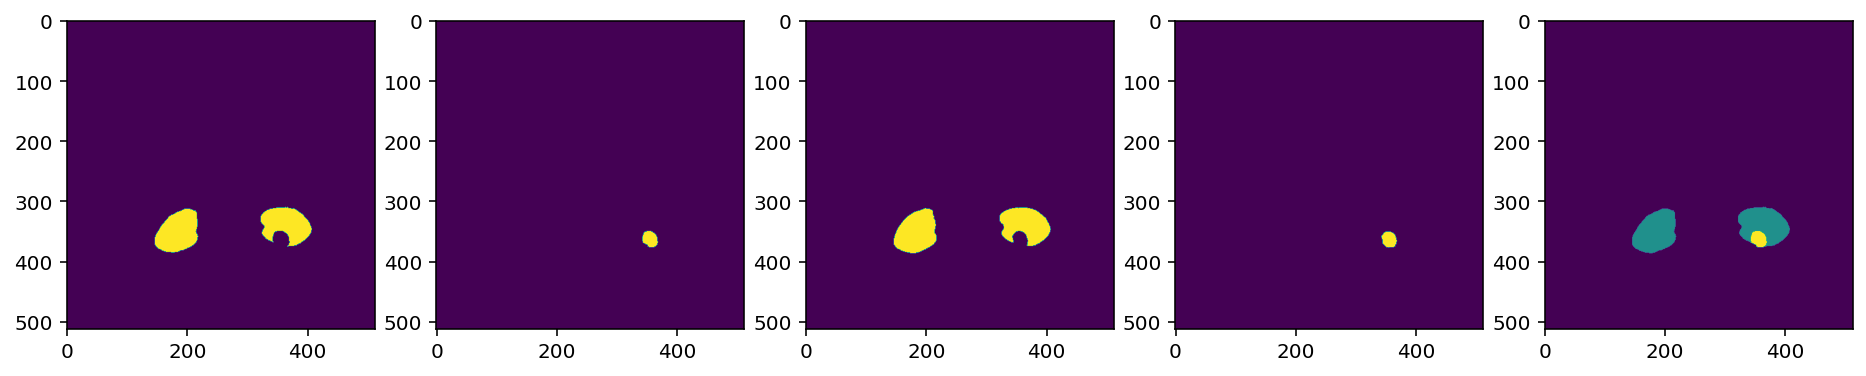

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


nan


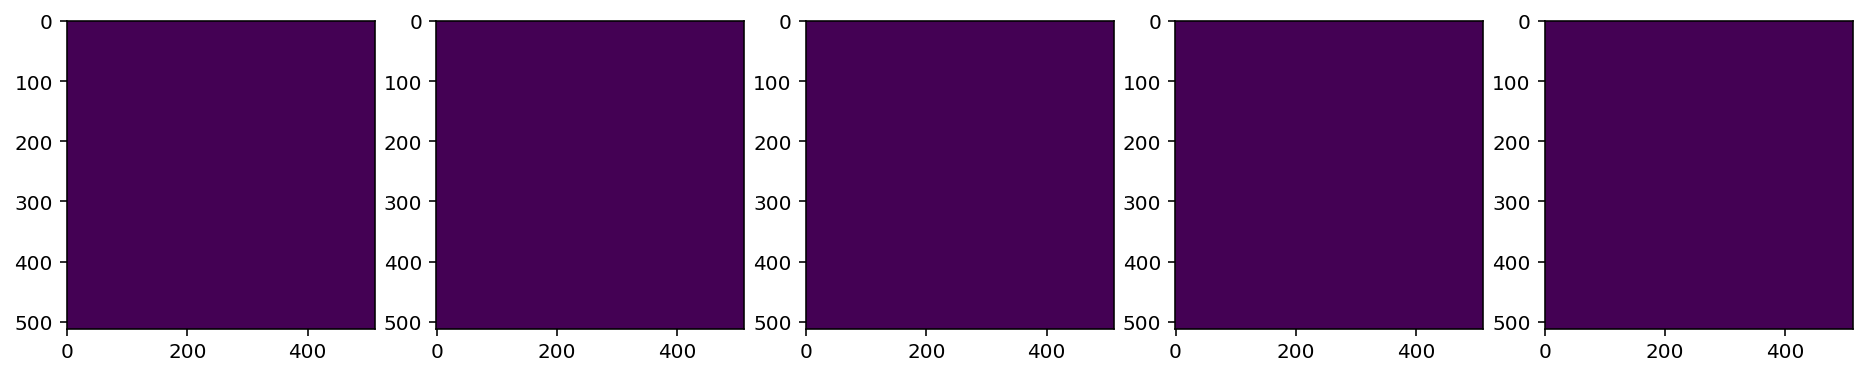

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 39 	Training Loss: 0.382593 	Validation Loss: 0.505409


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9815028792027355


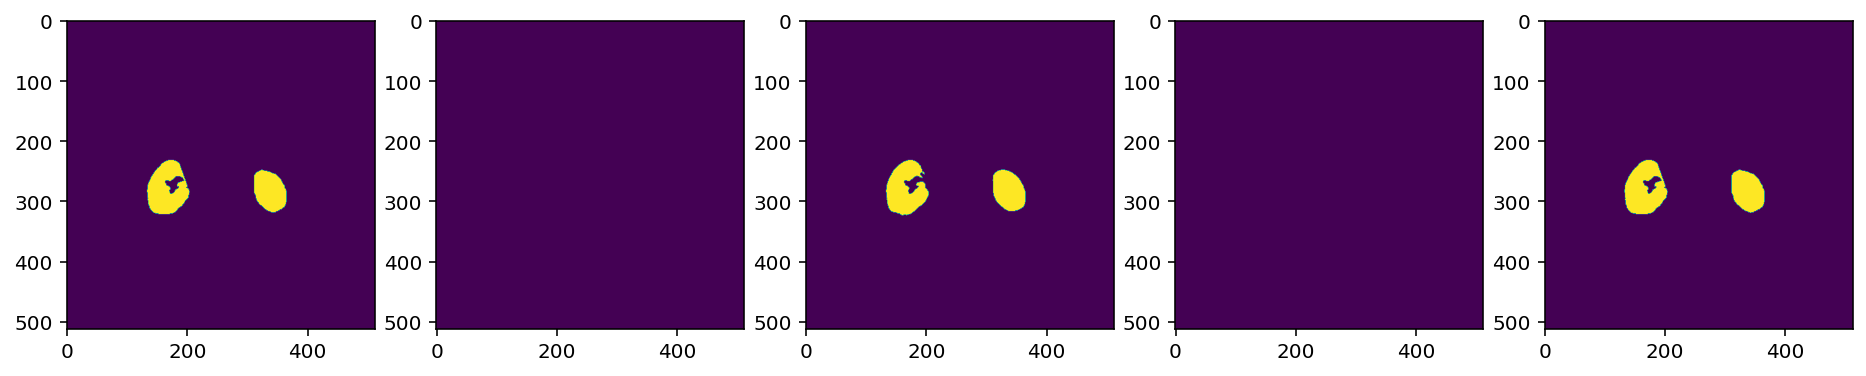

0.9865939370594563


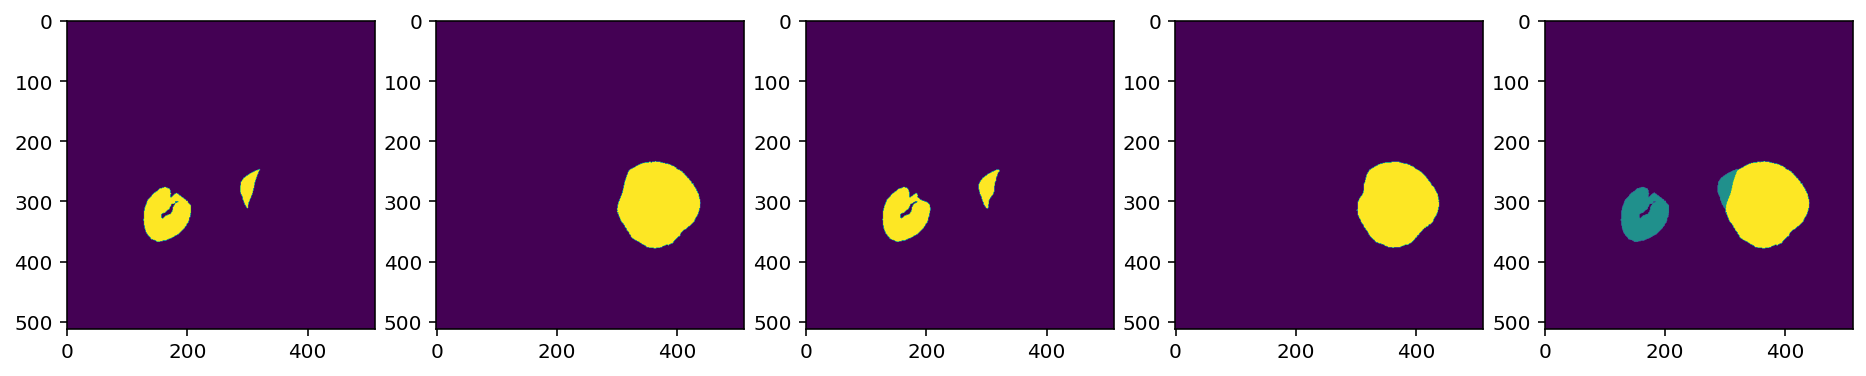

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 40 	Training Loss: 0.385139 	Validation Loss: 0.500961


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9751041788752046


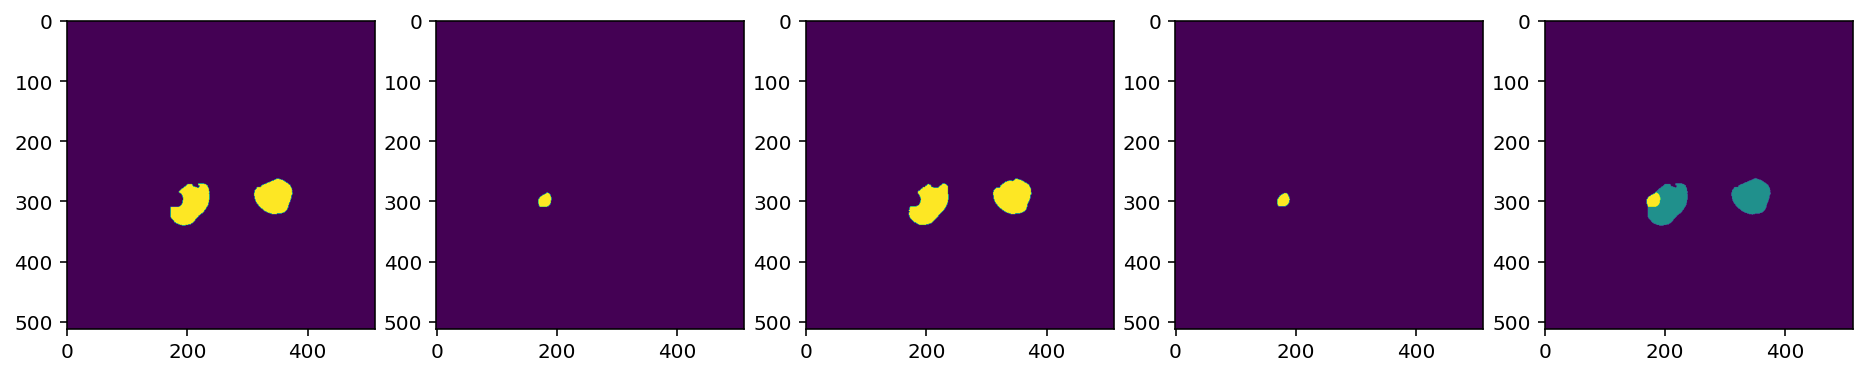

0.9840692835078473


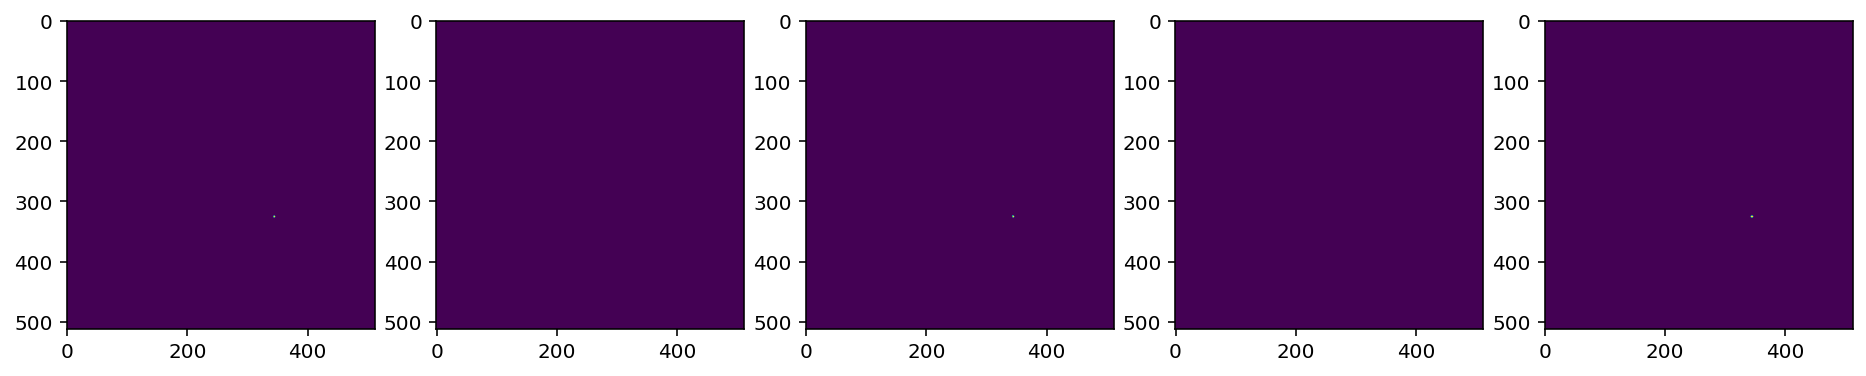

0.977304047262403


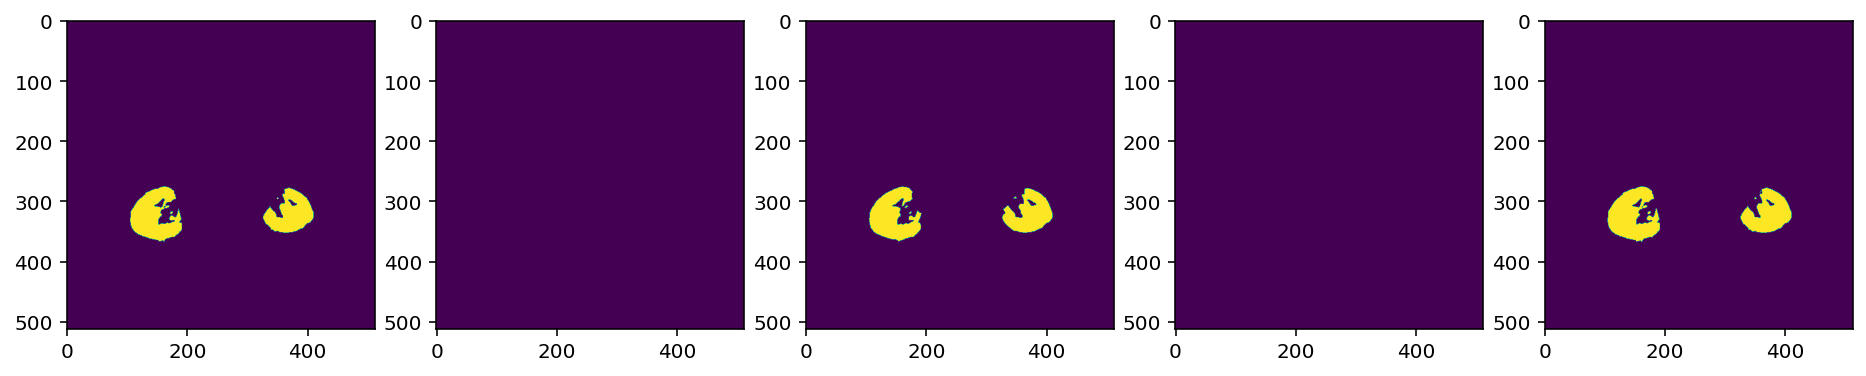

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 41 	Training Loss: 0.383937 	Validation Loss: 0.507912


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9630894266036369


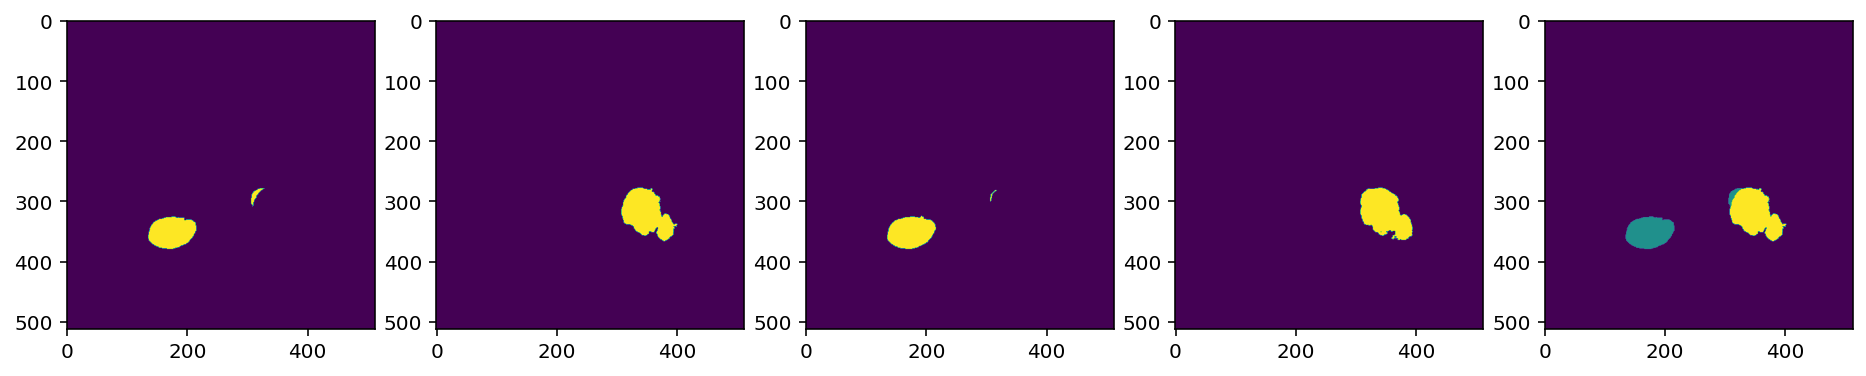

0.9850644735551572


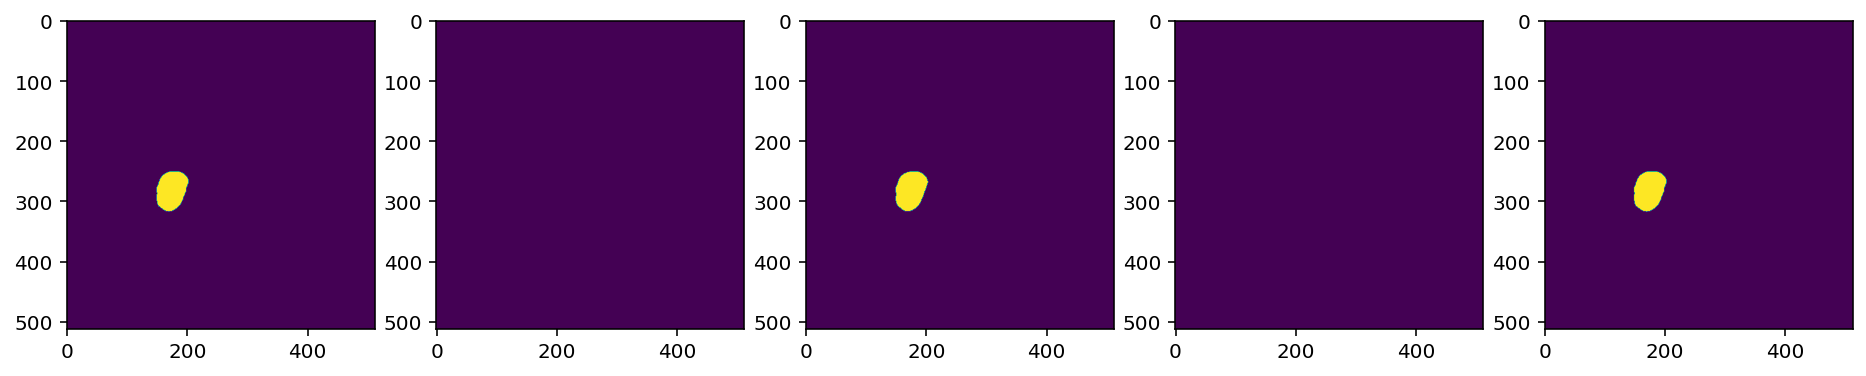

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 42 	Training Loss: 0.382348 	Validation Loss: 0.501585


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9901271085358831


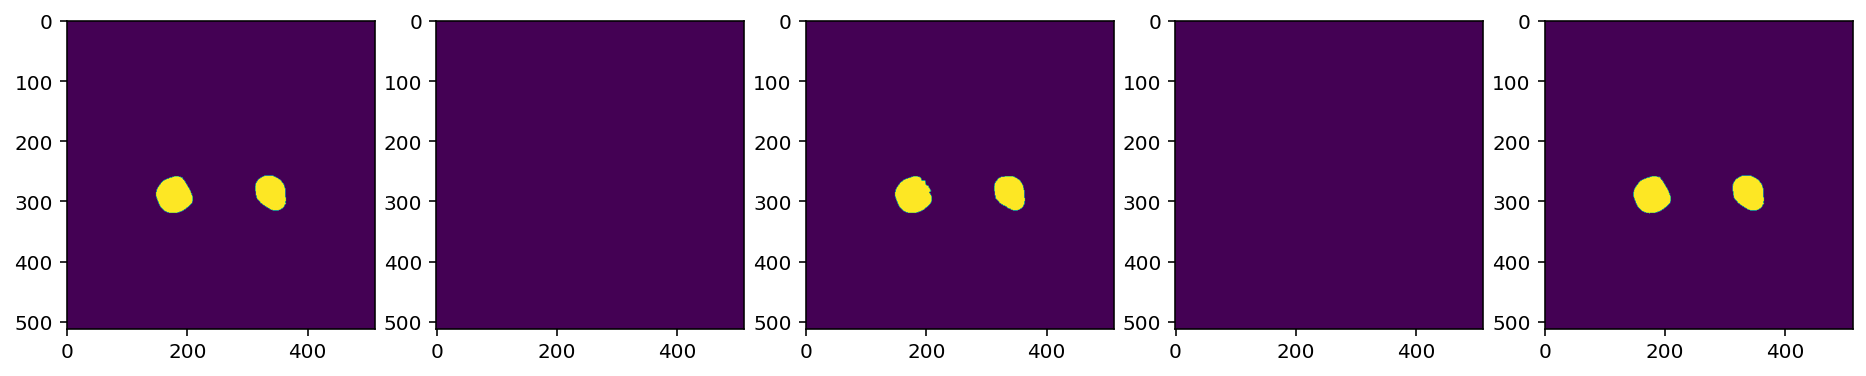

0.9596745939751554


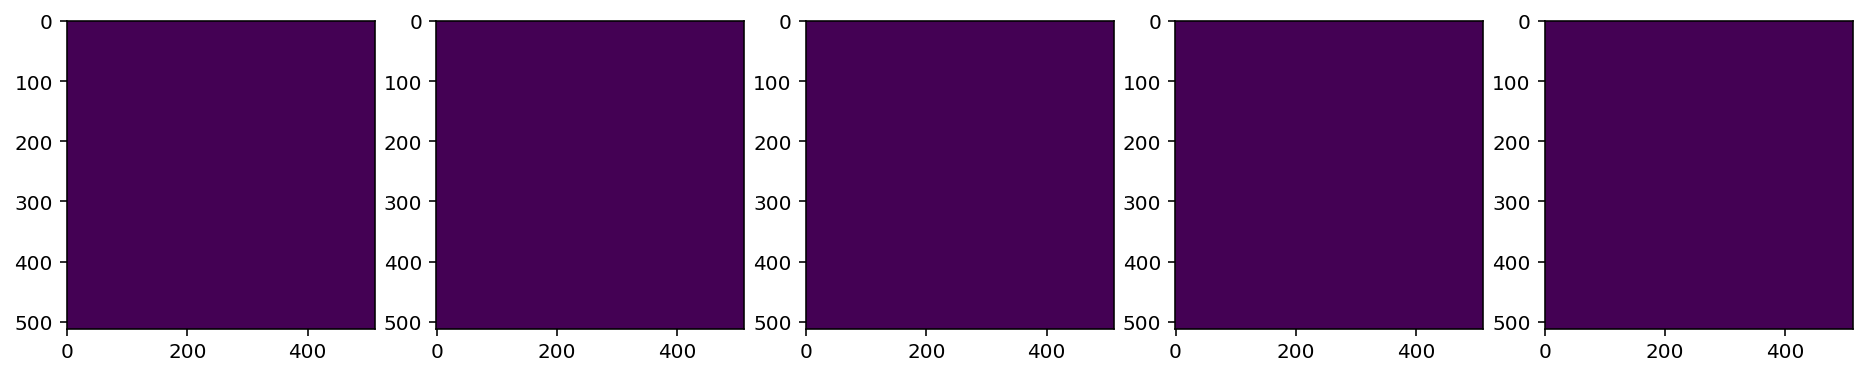

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 43 	Training Loss: 0.388545 	Validation Loss: 0.509282


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9729018873644995


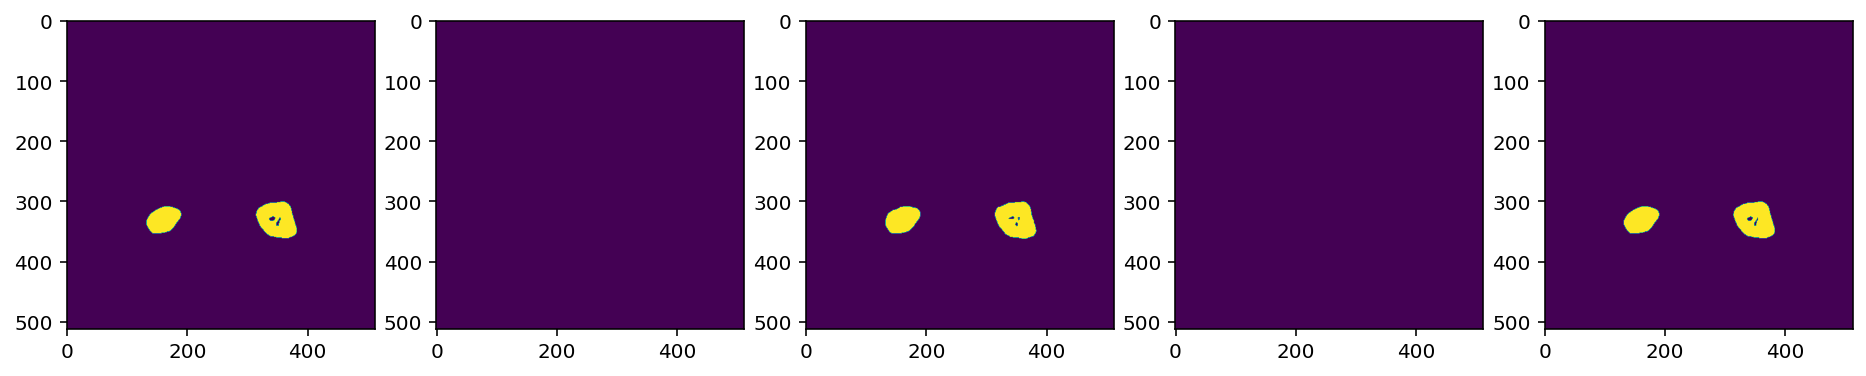

0.9849619612305579


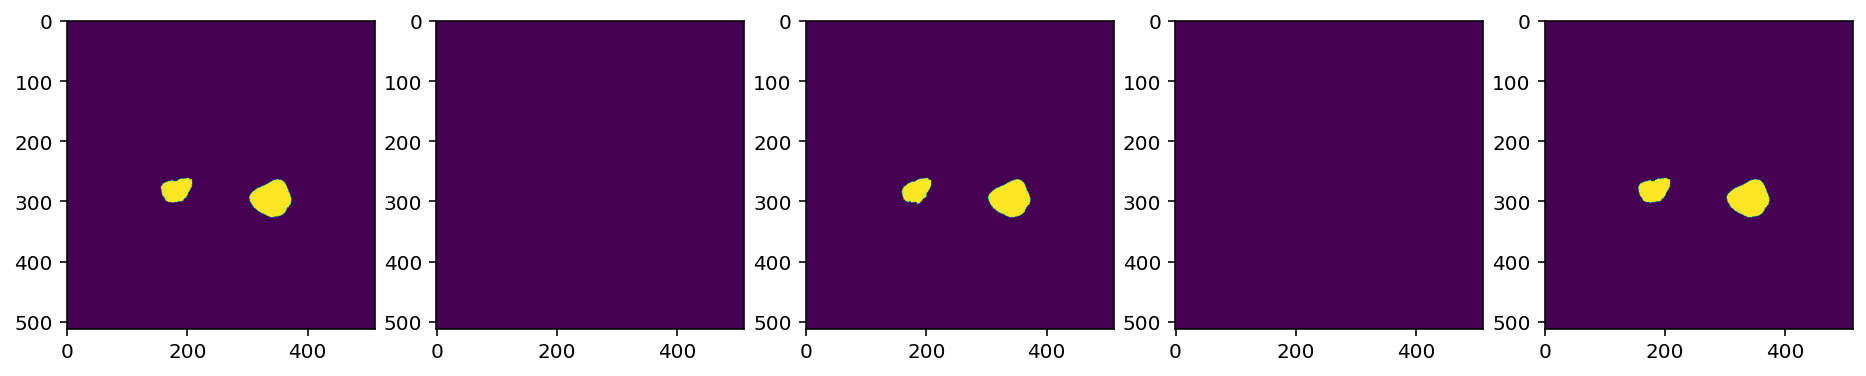

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 44 	Training Loss: 0.383367 	Validation Loss: 0.507766


  0%|          | 0/2240 [00:00<?, ?it/s]

0.985293170852672


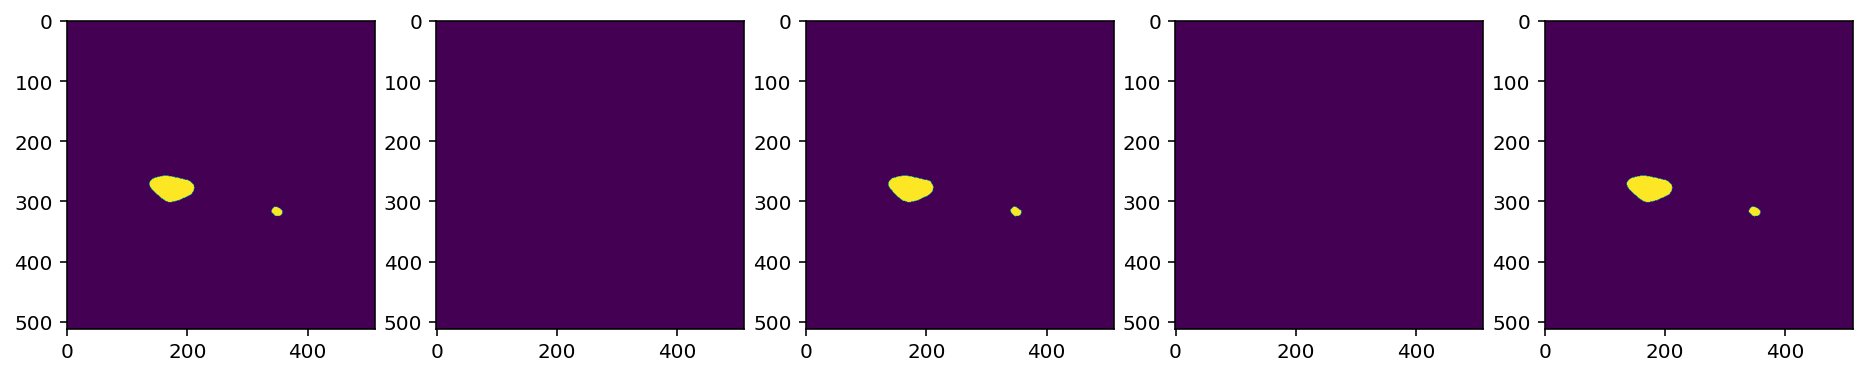

0.9748906435129091


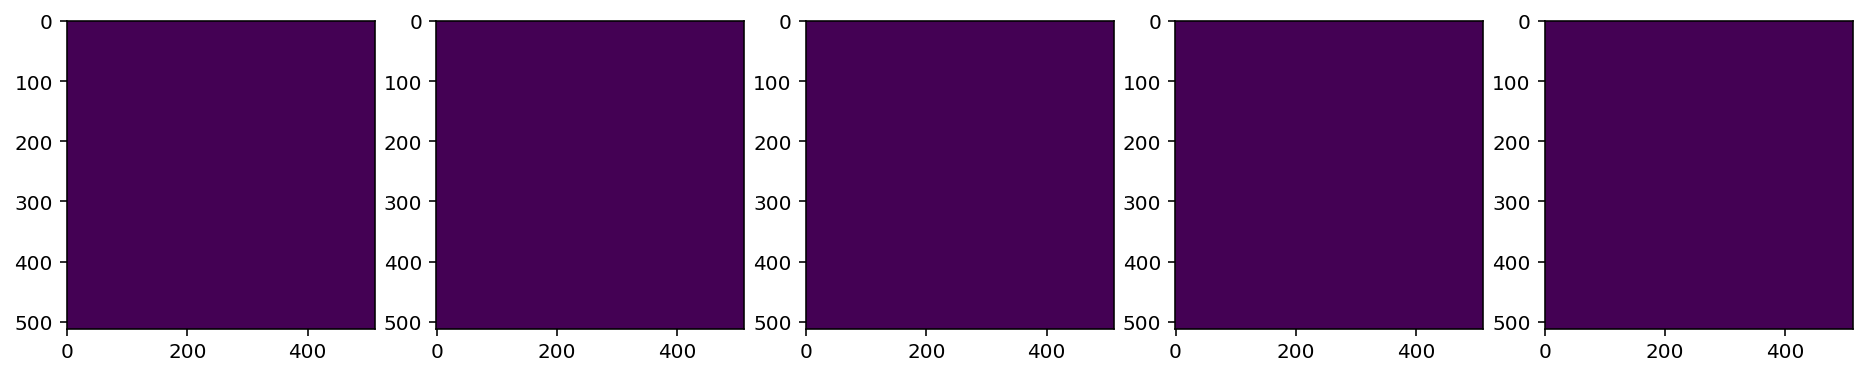

0.9757268073732677


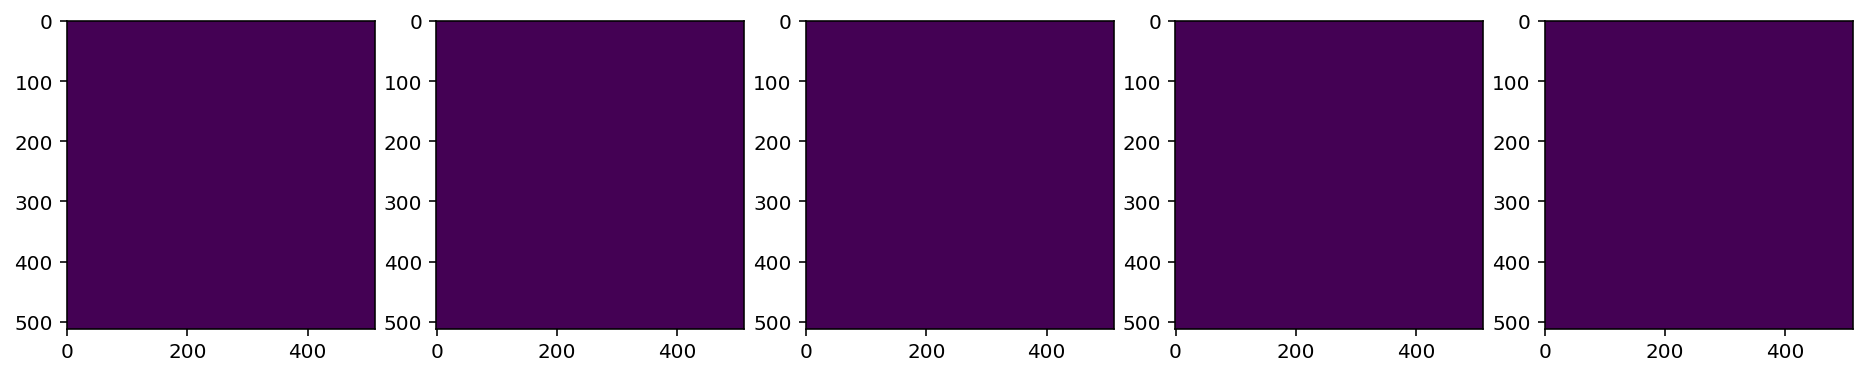

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 45 	Training Loss: 0.382363 	Validation Loss: 0.506005


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9618734476446508


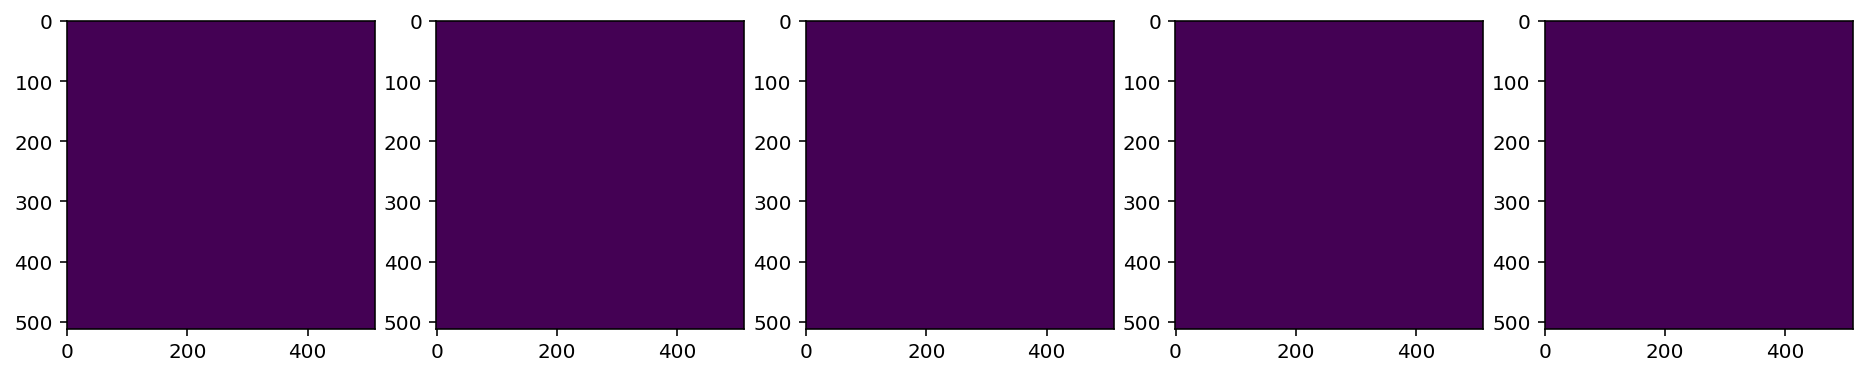

0.969411348533209


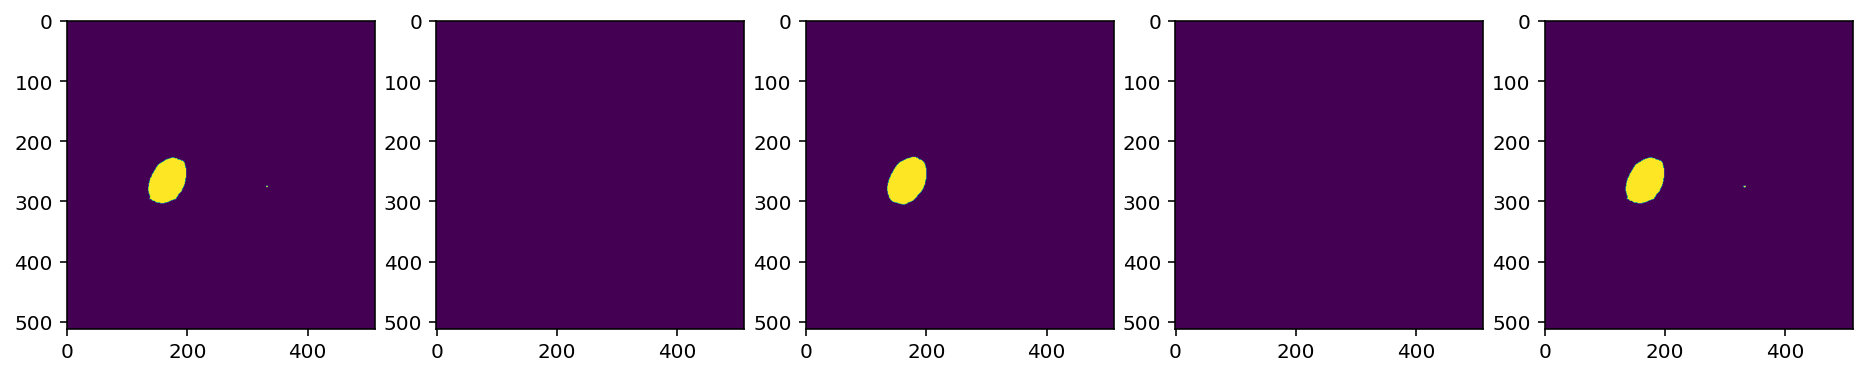

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 46 	Training Loss: 0.382255 	Validation Loss: 0.500863


  0%|          | 0/2240 [00:00<?, ?it/s]

0.97435031149816


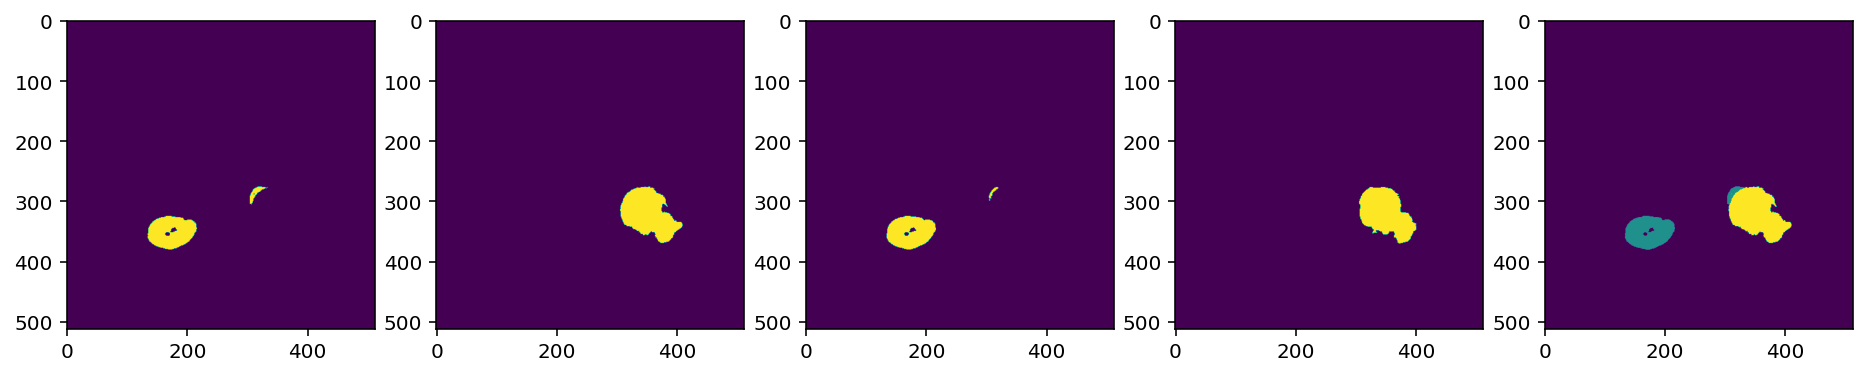

0.9861598603819697


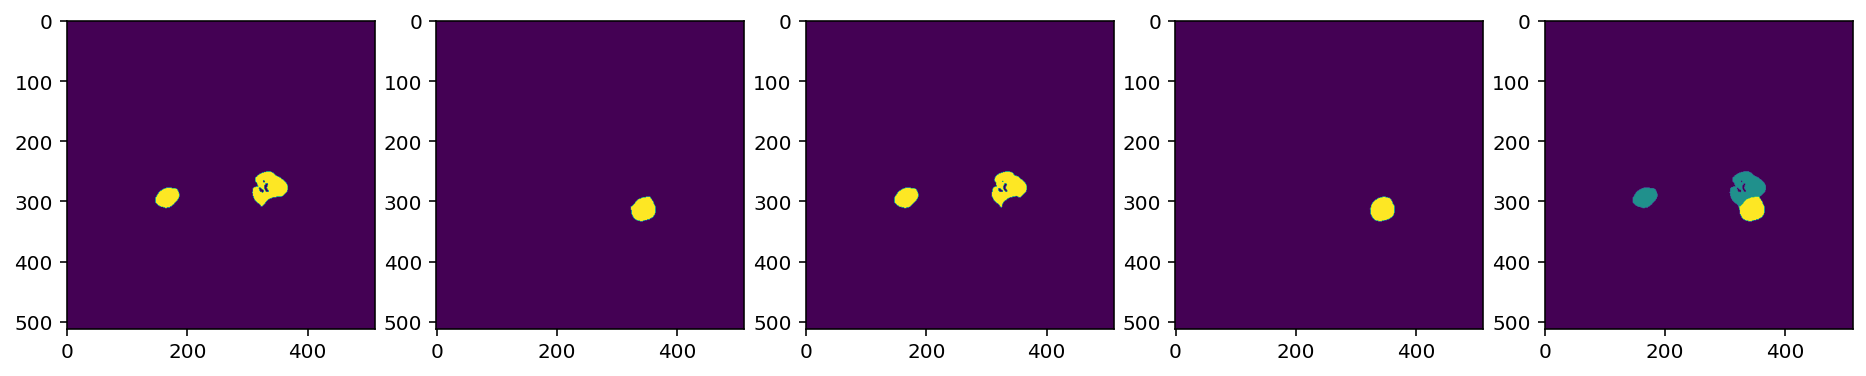

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 47 	Training Loss: 0.385334 	Validation Loss: 0.502177


  0%|          | 0/2240 [00:00<?, ?it/s]

0.9786200398847096


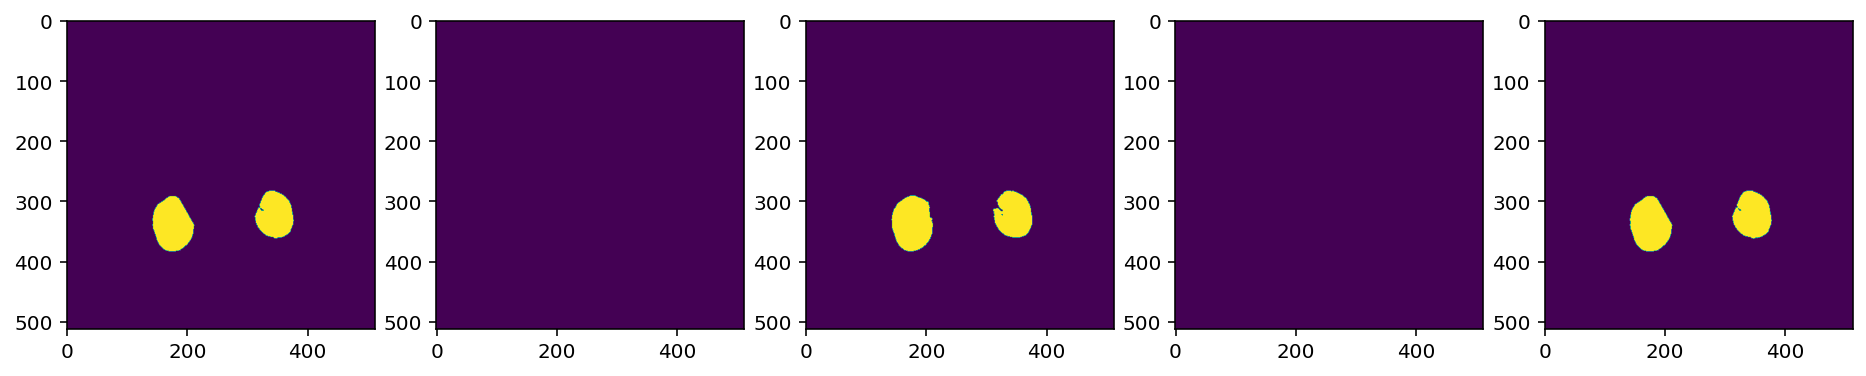

0.976185361572297


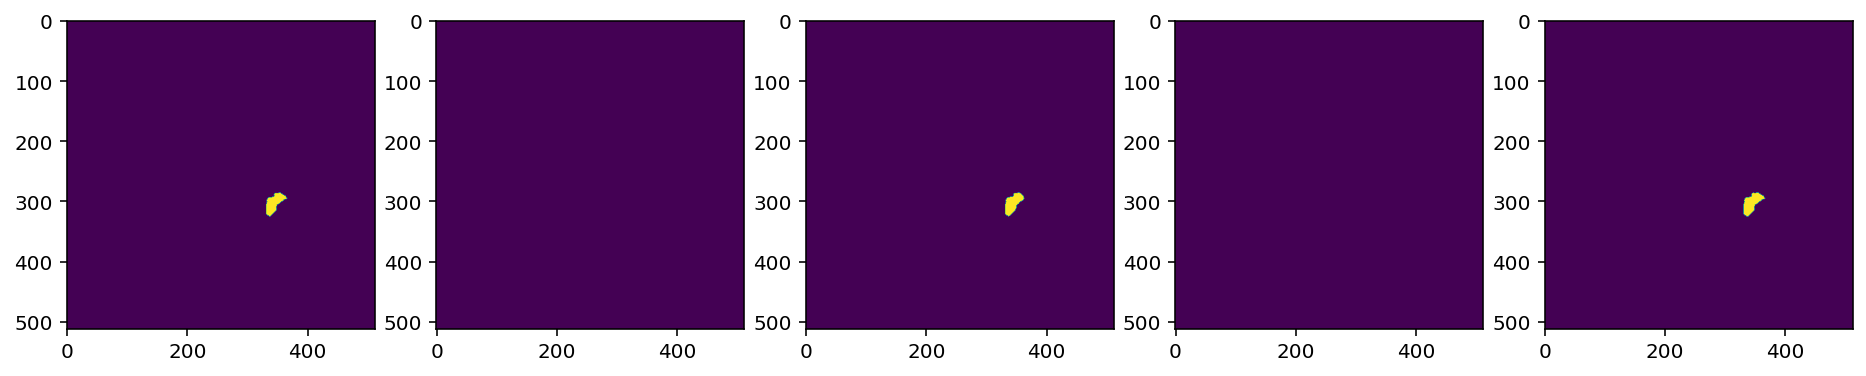

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 48 	Training Loss: 0.382060 	Validation Loss: 0.511613


  0%|          | 0/2240 [00:00<?, ?it/s]

0.49987220764160156


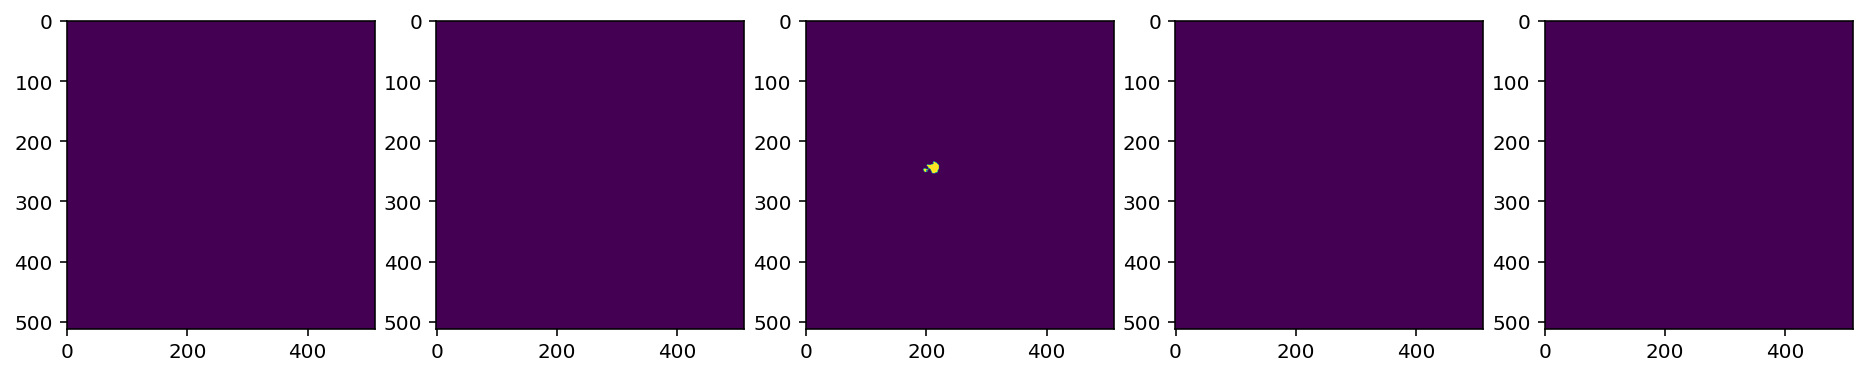

0.985919307824555


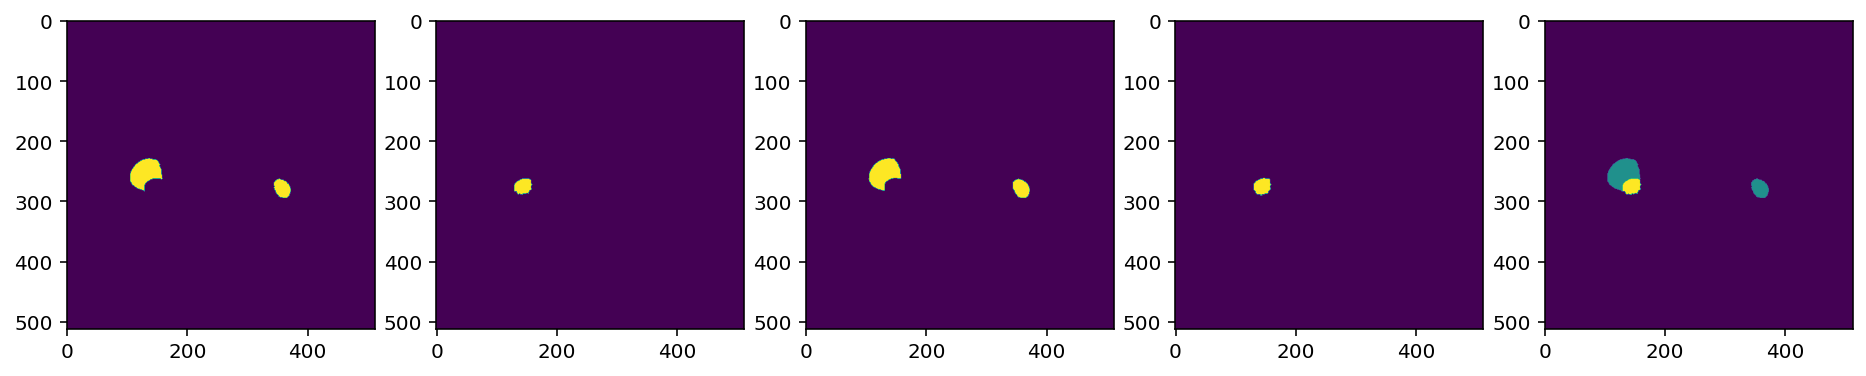

0.9781818139570844


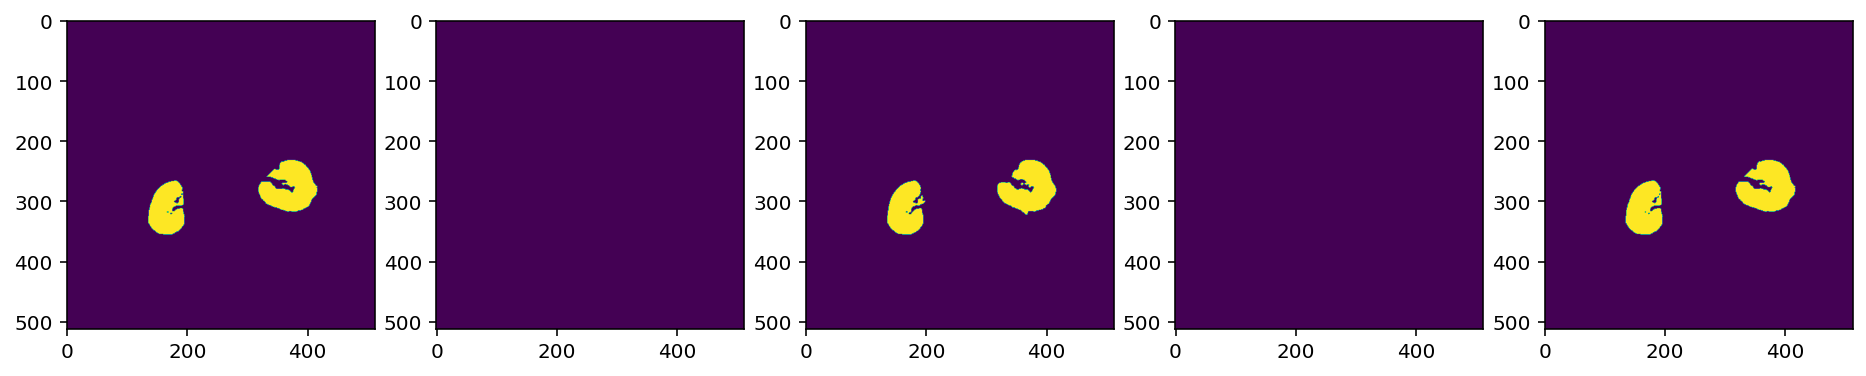

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch: 49 	Training Loss: 0.382510 	Validation Loss: 0.506147


In [ ]:
n_epochs =0
cnt =0
valid_loss_min = np.inf#0.489172 # track change in validation loss

# keep track of training and validation loss
train_loss = torch.zeros(n_epochs)
valid_loss = torch.zeros(n_epochs)
Iou=0
model.to(device)
for e in range(0, n_epochs):

   
    ###################
    # train the model #
    ###################
    model.train()
    for data, labels,a in tqdm(train_loader):
        # move tensors to GPU if CUDA is available
        data, labels = data.to(device), labels.to(device) #cpu에 있는 데이터를 gpu에 보냄
        # clear the gradients of all optimized variables
#         print(data.shape)
#         break
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        logits = model(data)
        
        # calculate the batch loss
        loss = criterion(logits, labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss[e] += loss.item()
        
        
#         z=logits.detach().cpu().numpy()
#         z = z.astype(np.uint8)
        cnt = cnt+1
        
        
        if cnt %1000==0:
            
            logits = logits.sigmoid()
            logits = mask_binarization(logits.detach().cpu(), 0.5)
            iou = compute_iou(logits,labels)
            print(iou)
            # y=torch.squeeze(labels[0])
            y=logits[0].detach().cpu().numpy()
            # x=data[0].detach().cpu().numpy()
            x=labels[0].detach().cpu().numpy()
            #y=labels[0].numpy()
            plt.figure(figsize=(16,18))
            plt.subplot(1,5,1)
            plt.imshow(x[0])
            plt.subplot(1,5,2)
            plt.imshow(x[1])
            plt.subplot(1,5,3)
            plt.imshow(y[0])
            plt.subplot(1,5,4)
            plt.imshow(y[1])
            plt.subplot(1,5,5)
            plt.imshow(a[0])
            plt.show()

    
    train_loss[e] /= len(train_loader)
    #torch.save(model.state_dict(), 'model_.pt')
        
    ######################    
    # validate the model #
    ######################
    with torch.no_grad(): 
        model.eval()
        for data, labels,a in tqdm(val_loader):
            # move tensors to GPU if CUDA is available
            data, labels = data.to(device), labels.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            logits = model(data)
            # calculate the batch loss
            loss = criterion(logits, labels)
            # update average validation loss 
            valid_loss[e] += loss.item()

    
    # calculate average losses
    valid_loss[e] /= len(val_loader)
    scheduler.step(valid_loss[e])    
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        e, train_loss[e], valid_loss[e]))
    
    # save model if validation loss has decreased
    if valid_loss[e] <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss[e]))
        torch.save(model.state_dict(), 'model_unet_light.pt')
        valid_loss_min = valid_loss[e]

In [ ]:
#Loss
plt.plot(train_loss)
plt.plot(valid_loss)

In [ ]:
model.load_state_dict(torch.load('model_unet_light.pt'))

<All keys matched successfully>

In [ ]:
len(test_loader)

640

torch.Size([1, 3, 512, 512])
torch.Size([1, 2, 512, 512])


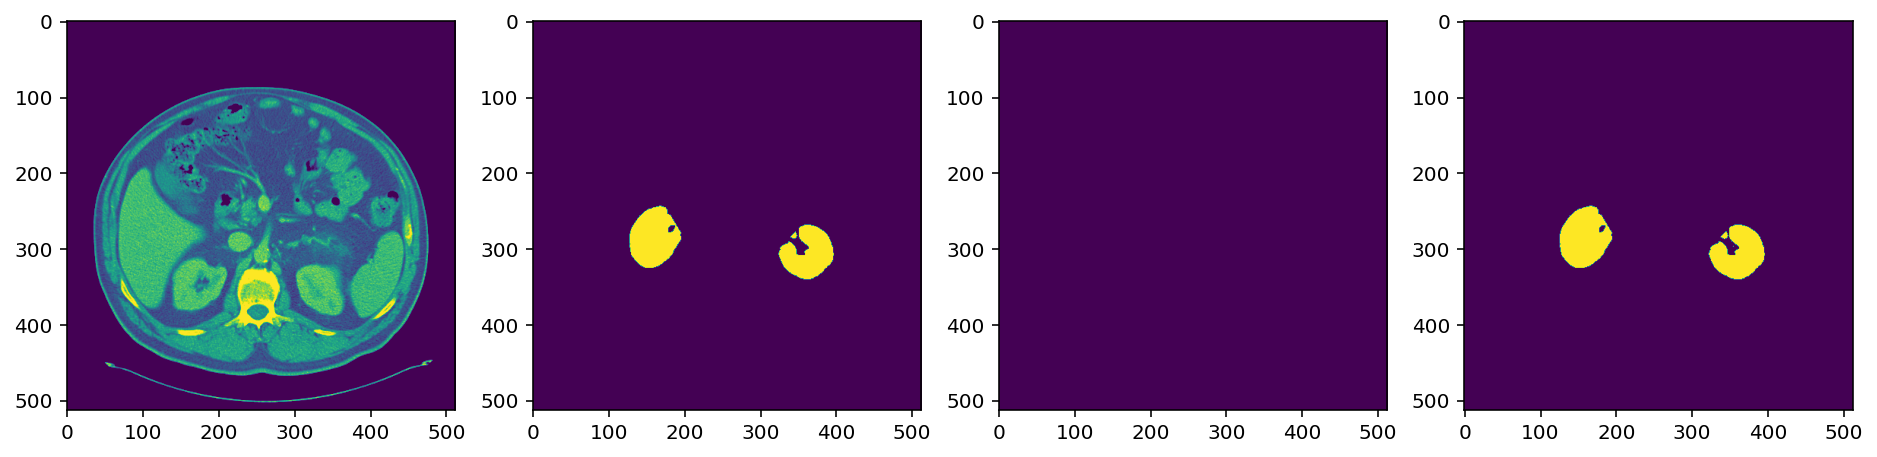

In [ ]:
images,labels,a = next(iter(test_loader))
print(images.shape)
print(labels.shape)
plt.figure(figsize=(16,18))
plt.subplot(1,4,1)
plt.imshow(images[0][0])
plt.subplot(1,4,2)
plt.imshow(labels[0][0])
plt.subplot(1,4,3)
plt.imshow(labels[0][1])
plt.subplot(1,4,4)
plt.imshow(a[0])
plt.show()

In [ ]:
len(test_loader)

640

In [ ]:
cnt =0
Iou=0
model.to(device)

with torch.no_grad(): 
        model.eval()
        for data, labels,a in tqdm(test_loader):
                data, labels = data.to(device), labels.to(device)
                # forward pass: compute predicted outputs by passing inputs to the model
                logits = model(data)
                logits = logits.sigmoid()
                logits = mask_binarization(logits.detach().cpu(), 0.5)
                iouu = compute_iou(logits,labels)
                iouu=np.round(iouu,3)*100
                if np.isnan(iouu)==True:
                    iouu=100
                Iou+=iouu

                labels=labels[0].detach().cpu().numpy()
                logits=logits[0].detach().cpu().numpy()
                cnt = cnt+1
                
print("Iou:",Iou/len(test_loader))


  0%|          | 0/640 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7

Iou: 58.51812500000001


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
